<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/AirLiquide/AirLiquide_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AIFREUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 13:00:38,485 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 13:00:38,487 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AIFREUR
2019-08-27 13:03:47,227 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 13:10:17,004 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 13:13:44,228 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 13:17:02,578 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 13:20:23,988 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 13:23:20,007 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 13:26:50,721 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 13:30:00,591 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 13:40:36,042 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AIFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AIFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AIFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  1.04998  1.05098  1.03797  1.04247  3.749024
2018-01-02 09:00:00  1.04288  1.04648  1.03897  1.04048  3.043659
2018-01-02 10:00:00  1.04047  1.04548  1.04047  1.04197  1.867866
2018-01-02 11:00:00  1.04248  1.04548  1.04197  1.04297  1.682944
2018-01-02 12:00:00  1.04297  1.04598  1.04247  1.04548  1.778887
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  1.06860  1.07548  1.06860  1.07098  1.729022
2018-12-31 09:00:00  1.07087  1.07298  1.06847  1.07298  1.284485
2018-12-31 10:00:00  1.07298  1.07798  1.07247  1.07697  1.126881
2018-12-31 11:00:00  1.07698  1.07698  1.07347  1.07398  0.945896
2018-12-31 12:00:00  1.07397  1.08398  1.07347  1.08397  1.866543

[2275 rows x 5 columns]

Open         High          Low        Close       Volume
count  2275.000000  2275.000000  2275.000000  2275.000000  2275.000000
mean      1.064897     1.067350     1.062410     1.064886     2.570276
std       0.034460     0.034328     0.034589     0.034554     1.959433
min       0.973380     0.975770     0.971470     0.973370     0.006624
25%       1.046480     1.049480     1.043920     1.046470     1.469962
50%       1.069970     1.072480     1.067470     1.069980     2.053412
75%       1.087725     1.089970     1.085470     1.087970     3.022347
max       1.150470     1.151980     1.147970     1.150480    21.550400

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  1.09597  1.09698  1.09447  1.09554  1.753845    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  1.095713  1.083281  1.088668  1.096830  1.095761  1.095284    1.096730    1.095175  1.090941  1.096488  1.095382  1.096383  1.096104  1.096488  1.095667  1.092177                1.098409                 1.096488                1.094566                1.099370                 1.096488                1.093606                1.100330                 1.096488                1.092645                1.101291                 1.096488                1.091684  1.095761  1.095786  1.093258                1.097683                 1.095761                1.093840                1.098643                 1.095761                1.092879                1.099604                 1.095761                1.091919                1.100565                 1.095761   
2018-01-09 14:00:00  1.09548  1.09658  1.09487  1.09647  6.132004    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  1.096092  1.086483  1.089257  1.096872  1.095919  1.095335    1.096730    1.095175  1.091544  1.096299  1.095656  1.096161  1.096101  1.096299  1.096005  1.092797                1.097859                 1.096299                1.094738                1.098640                 1.096299                1.093958                1.099420                 1.096299                1.093178                1.100200                 1.096299                1.092397  1.095919  1.096206  1.093774                1.097479                 1.095919                1.094358                1.098260                 1.095919                1.093578                1.099040                 1.095919                1.092798                1.099820                 1.095919   
2018-01-09 15:00:00  1.09647  1.09948  1.09547  1.09898 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000    2225.000000  2225.000000   2225.000000     2225.000000     2225.000000       2225.000000  2225.000000  2225.000000  2225.000000  2225.000000   2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000   
mean      1.064764     1.067214     1.062256     1.064737     2.586472    15.997753     2.019326   185.444045      30.423371    11.378427      0.034157        0.023820        0.002247          0.004045     6.597753     2.533483    26.943820     2.019326      2.005843    26.943820     1.064761     1.064708     0.041138     1.064729     1.064772     1.064255     1.064681     1.064599     1.064436     1.064769     1.064729     1.064767     1.064756     1.064769     1.064748     1.064858                1.072407                 1.064769                1.057130                1.076227                 1.064769                1.053311                1.080046                 1.064769                1.049492                1.083865                 1.064769                1.045673     1.064772     1.064742     1.064846                1.072410                 1.064772                1.057133                1.076229                 1.064772                1.053314                1.080049   
std       0.034705     0.034575     0.034828     0.034794     1.976061     8.580055     1.412650   101.900637       0.854312     2.620424      0.181674        0.152523        0.047362          0.063485     3.353096     1.102596    14.557378     1.412650      1.403830    14.557378     0.034460     0.033694     1.064414     0.034874     0.034412     0.034187     0.034562     0.034385     0.035176     0.034532     0.034830     0.034589     0.034567     0.034532     0.034721     0.034116                0.034363                 0.034532                0.035257                0.034490                 0.034532                0.035819                0.034757                 0.034532                0.036505                0.035161                 0.034532                0.037309     0.034412     0.034683     0.034180                0.034251                 0.034412                0.035130                0.034384                 0.034412                0.035689                0.034656   
min       0.973380     0.975770     0.9714

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.692247  0.687872  0.696884  0.689797  0.081101    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.686334  0.620159  0.976333  0.696165  0.692476  0.692985    0.702349    0.695899  0.661854  0.698373  0.689453  0.697661  0.693676  0.698373  0.689902  0.676783                0.660313                 0.698373                0.736746                0.636312                 0.698373                0.758672                0.613202                 0.698373                0.778416                0.592030                 0.698373                0.796456  0.692476  0.691221  0.682927                0.663999                 0.692476                0.726157                0.639362                 0.692476                0.748941                0.617878                 0.692476                0.769782                0.596713                 0.692476   
2018-01-09 14:00:00  0.689480  0.685602  0.699150  0.695048  0.284322    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.688578  0.640767  0.976590  0.696408  0.693415  0.693293    0.702349    0.695899  0.665195  0.697260  0.691003  0.696364  0.693653  0.697260  0.691825  0.680708                0.657142                 0.697260                0.737689                0.632180                 0.697260                0.760502                0.608143                 0.697260                0.781045                0.586127                 0.697260                0.799806  0.693415  0.693622  0.686168                0.662789                 0.693415                0.729088                0.637124                 0.693415                0.752684                0.614683                 0.693415                0.774251                0.592618                 0.693415   
2018-01-09 15:00:00  0.695070  0.702060  

140080

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk8z68l7q
  JVM stdout: /tmp/tmpk8z68l7q/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpk8z68l7q/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_zdpznr
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.781290  0.567643              0.283261  0.439360  0.193037
1  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.779601  0.586934              0.265082  0.449752  0.202276
2  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.768219  2.232883              0.265243  0.504502  0.254522
3  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.767938  0.639773              0.314672  0.455276  0.207277
4  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.753137  0.843370              0.328346  0.487953  0.238098
5  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.748793  0.630651              0.337436  0.462991  0.214361
6  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.745335  0.624927              0.283020  0.458051  0.209810
7              DeepLearning_1_AutoML_20190827_135046  0.718388  0.799886              0.318935  0.484975  0.235201
8  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.716779  0.635344              0.355494  0.469524  0.220453
9  DeepLearning_grid_1_AutoML_20190827_135046_mod...  0.706725  0.818891              0.391771  0.499466  0.249466

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.008680
1          CDLCLOSINGMARUBOZU             0.734804           0.734804    0.006378
2                 CDLLONGLINE             0.594092           0.594092    0.005157
3                         DIV             0.486079           0.486079    0.004219
4                         SUB             0.485536           0.485536    0.004214
...                       ...                  ...                ...         ...
1033  BBANDS_lowerband_12_7_2             0.082612           0.082612    0.000717
1034  BBANDS_middleband_8_2_5             0.082158           0.082158    0.000713
1035           CDLHARAMICROSS             0.080979           0.080979    0.000703
1036               CDL3INSIDE             0.078444           0.078444    0.000681
1037           CDL3LINESTRIKE             0.074932           0.074932    0.000650

[1038 rows x 4 columns]

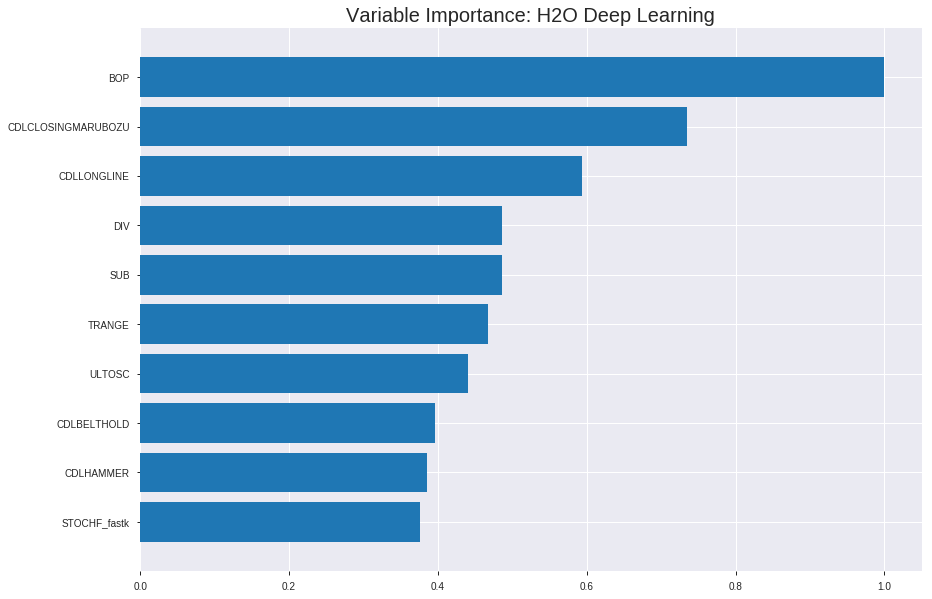

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_135046_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18121177279852474
RMSE: 0.42568976120941027
LogLoss: 0.5396570119112895
Mean Per-Class Error: 0.24619920919096572
AUC: 0.8188029471103084
pr_auc: 0.8137374878329793
Gini: 0.6376058942206169
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47978830858807137: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      444  325   0.4226   (325.0/769.0)
1      109  678   0.1385   (109.0/787.0)
Total  553  1003  0.2789   (434.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479788     0.757542  230
max f2                       0.341733     0.85396   298
max f0point5                 0.597804     0.764391  162
max accuracy                 0.520095     0.753856  203
max precision                0.991863     1         0
max recall                   0.107189     1         381
max specificity              0.991863     1         0
max absolute_mcc             0.520095     0.507628  203
max min_per_class_accuracy   0.521635     0.751625  202
max mean_per_class_accuracy  0.520095     0.753801  203

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 54.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.961775           1.97713   1.97713            1                0.974186  1                           0.974186            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.947744           1.85356   1.91534            0.9375           0.956297  0.96875                     0.965242            0.0190597       0.0393901                  85.3558   91.5343
    3        0.0302057                   0.932932           1.84532   1.893              0.933333         0.939978  0.957447                    0.957179            0.0177891       0.0571792                  84.532    89.2995
    4        0.0404884                   0.923394           1.97713   1.91436            1                0.927339  0.968254                    0.949601            0.0203304       0.0775095                  97.7128   91.4362
    5        0.0501285                   0.907003           1.71351   1.87574            0.866667         0.915869  0.948718                    0.943114            0.0165184       0.094028                   71.3511   87.5737
    6        0.100257                    0.842808           1.72365   1.79969            0.871795         0.871938  0.910256                    0.907526            0.0864041       0.180432                   72.365    79.9694
    7        0.150386                    0.793182           1.6983    1.7659             0.858974         0.816875  0.893162                    0.877309            0.0851334       0.265565                   69.8303   76.5897
    8        0.200514                    0.749078           1.749     1.76167            0.884615         0.769944  0.891026                    0.850468            0.0876747       0.35324                    74.8998   76.1672
    9        0.300129                    0.663561           1.44139   1.65537            0.729032         0.7038    0.837259                    0.801788            0.143583        0.496823                   44.139    65.5369
    10       0.400386                    0.583067           1.31809   1.57091            0.666667         0.62222   0.794543                    0.756824            0.132147        0.628971                   31.8086   57.0913
    11       0.5                         0.521934           1.21179   1.49936            0.612903         0.548876  0.758355                    0.715395            0.120712        0.749682                   21.1788   49.9365
    12       0.600257                    0.490263           0.697064  1.36536            0.352564         0.505446  0.690578                    0.680328            0.0698856       0.819568                   -30.2936  36.5362
    13       0.699871                    0.452363           0.752584  1.27814            0.380645         0.474598  0.646465                    0.651046            0.0749682       0.894536                   -24.7416  27.8144
    14       0.800129                    0.375492           0.557652  1.18787            0.282051         0.417886  0.600803                    0.621831            0.0559085       0.950445                   -44.2348  18.7865
    15       0.899743                    0.242434           0.318892  1.09166            0.16129          0.313234  0.552143                    0.587665            0.0317662       0.982211                   -68.1108  9.16573
    16       1                           0.022509           0.177435  1                  0.0897436        0.151151  0.505784                    0.543901         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18996128493179334
RMSE: 0.4358454828626693
LogLoss: 0.5642740904666171
Mean Per-Class Error: 0.25177756231567894
AUC: 0.7886821799377852
pr_auc: 0.7746300064874486
Gini: 0.5773643598755704
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48397054342491685: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      156  66   0.2973   (66.0/222.0)
1      46   177  0.2063   (46.0/223.0)
Total  202  243  0.2517   (112.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483971     0.759657  215
max f2                       0.0860029    0.841547  382
max f0point5                 0.496867     0.748858  196
max accuracy                 0.485682     0.748315  213
max precision                0.978894     1         0
max recall                   0.0684255    1         389
max specificity              0.978894     1         0
max absolute_mcc             0.483971     0.498544  215
max min_per_class_accuracy   0.495597     0.73991   198
max mean_per_class_accuracy  0.485682     0.748222  213

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 50.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.961668           1.99552   1.99552            1                0.969775   1                           0.969775            0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.944469           1.99552   1.99552            1                0.952861   1                           0.962258            0.0179372       0.0403587                  99.5516   99.5516
    3        0.0314607                   0.924615           1.19731   1.71044            0.6              0.931602   0.857143                    0.951309            0.0134529       0.0538117                  19.7309   71.0442
    4        0.0404494                   0.907646           1.99552   1.77379            1                0.916797   0.888889                    0.94364             0.0179372       0.0717489                  99.5516   77.3792
    5        0.0516854                   0.899665           1.59641   1.73523            0.8              0.905093   0.869565                    0.93526             0.0179372       0.0896861                  59.6413   73.5231
    6        0.101124                    0.847755           1.63269   1.6851             0.818182         0.865418   0.844444                    0.901115            0.0807175       0.170404                   63.2695   68.5102
    7        0.150562                    0.793073           1.90481   1.75725            0.954545         0.819345   0.880597                    0.874265            0.0941704       0.264574                   90.481    75.7245
    8        0.2                         0.751323           1.54199   1.70404            0.772727         0.776758   0.853933                    0.850163            0.0762332       0.340807                   54.1989   70.4036
    9        0.301124                    0.662581           1.33034   1.57854            0.666667         0.714588   0.791045                    0.804634            0.134529        0.475336                   33.0344   57.8542
    10       0.4                         0.561092           1.31523   1.51345            0.659091         0.609151   0.758427                    0.756312            0.130045        0.605381                   31.5226   51.3453
    11       0.501124                    0.493466           1.33034   1.4765             0.666667         0.520413   0.73991                     0.708709            0.134529        0.73991                    33.0344   47.6503
    12       0.6                         0.45885            0.770995  1.36024            0.386364         0.480121   0.681648                    0.671039            0.0762332       0.816143                   -22.9005  36.0239
    13       0.698876                    0.354817           0.544232  1.24479            0.272727         0.398915   0.623794                    0.632539            0.0538117       0.869955                   -45.5768  24.4791
    14       0.8                         0.259988           0.487793  1.1491             0.244444         0.311639   0.575843                    0.591976            0.0493274       0.919283                   -51.2207  14.9103
    15       0.898876                    0.145657           0.544232  1.08257            0.272727         0.200931   0.5425                      0.548961            0.0538117       0.973094                   -45.5768  8.25673
    16       1                           0.0367764          0.266069  1                  0.133333         0.0941928  0.501124                   


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:09:47  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:09:50  6 min 17.667 sec   177 obs/sec       0.242931  1             378        0.688711         2.95379             -0.897547      0.564885        0.556415           1.72999          0.494216                         0.705817           3.95898               -0.992718        0.580748          0.586606             1.59641            0.462921
    2019-08-27 14:10:36  7 min  4.083 sec   217 obs/sec       6.15681   25            9580       0.488588         0.670224            0.0450007      0.625813        0.651831           1.60642          0.485219                         0.486947           0.66695               0.051524         0.644791          0.624134             1.19731            0.440449
    2019-08-27 14:11:23  7 min 50.993 sec   236 obs/sec       13.1375   53            20442      0.464423         0.620406            0.137128       0.748839        0.745974           1.97713          0.332905                         0.463263           0.619036              0.141544         0.741314          0.707757             1.19731            0.323596
    2019-08-27 14:12:10  8 min 37.653 sec   244 obs/sec       20.2063   81            31441      0.447004         0.581909            0.200641       0.787345        0.786696           1.85356          0.316838                         0.448248           0.591582              0.196292         0.765937          0.742016             1.19731            0.321348
    2019-08-27 14:12:55  9 min 23.324 sec   249 obs/sec       27.1774   109           42288      0.435781         0.56036             0.240277       0.800043        0.799044           1.97713          0.289203                         0.449026           0.590169              0.193499         0.772775          0.74894              1.99552            0.285393
    2019-08-27 14:13:41  10 min  8.915 sec  253 obs/sec       34.2545   137           53300      0.429564         0.549248            0.261799       0.810053        0.808419           1.97713          0.273779                         0.443828           0.579267              0.212064         0.786289          0.760483             1.99552            0.276404
    2019-08-27 14:14:27  10 min 54.737 sec  256 obs/sec       41.4897   166           64558      0.425179         0.538786            0.276795       0.808739        0.807464           1.97713          0.304627                         0.440101           0.575132              0.22524          0.780299          0.758969             1.99552            0.285393
    2019-08-27 14:15:12  11 min 40.258 sec  257 obs/sec       48.5244   194           75504      0.42569          0.539657            0.275056       0.818803        0.813737           1.97713          0.27892                          0.435845           0.564274              0.240151         0.788682          0.77463              1.99552            0.251685
    2019-08-

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.008679701824765625
CDLCLOSINGMARUBOZU       0.7348037958145142     0.7348037958145142   0.006377877847375946
CDLLONGLINE              0.5940924286842346     0.5940924286842346   0.005156545137329993
DIV                      0.48607927560806274    0.48607927560806274  0.004219023175476055
SUB                      0.48553580045700073    0.48553580045700073  0.0042143059732156676
---                      ---                    ---                  ---
BBANDS_lowerband_12_7_2  0.08261170983314514    0.08261170983314514  0.0007170450085857582
BBANDS_middleband_8_2_5  0.08215848356485367    0.08215848356485367  0.000713111139717837
CDLHARAMICROSS           0.08097923547029495    0.08097923547029495  0.0007028756178796443
CDL3INSIDE               0.07844400405883789    0.07844400405883789  0.0006808705651714173
CDL3LINESTRIKE           0.07493159174919128    0.07493159174919128  0.0006503838736380484


See the whole table with table.as_data_frame()


('accuracy', 0.7219730941704036)

('F1', 0.7586206896551725)

('auc', 0.7812902187902189)

('logloss', 0.5676432083941918)

('mean_per_class_error', 0.2785151222651223)

('rmse', 0.4393603083439143)

('mse', 0.19303748054805944)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


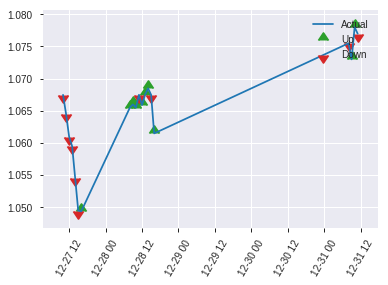


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19303748054805944
RMSE: 0.4393603083439143
LogLoss: 0.5676432083941918
Mean Per-Class Error: 0.2785151222651223
AUC: 0.7812902187902189
pr_auc: 0.7466885588366656
Gini: 0.5625804375804377
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41182406975942953: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   50   0.4505   (50.0/111.0)
1      13   99   0.1161   (13.0/112.0)
Total  74   149  0.2825   (63.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411824     0.758621  148
max f2                       0.202005     0.863142  194
max f0point5                 0.499178     0.72      96
max accuracy                 0.445565     0.721973  135
max precision                0.973484     1         0
max recall                   0.127525     1         203
max specificity              0.973484     1         0
max absolute_mcc             0.411824     0.460287  148
max min_per_class_accuracy   0.491688     0.696429  107
max mean_per_class_accuracy  0.445565     0.721485  135

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 48.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.945622           1.32738    1.32738            0.666667         0.962937   0.666667                    0.962937            0.0178571       0.0178571                  32.7381   32.7381
    2        0.0224215                   0.924837           1.99107    1.59286            1                0.929308   0.8                         0.949485            0.0178571       0.0357143                  99.1071   59.2857
    3        0.0313901                   0.899293           1.99107    1.70663            1                0.915402   0.857143                    0.939747            0.0178571       0.0535714                  99.1071   70.6633
    4        0.0403587                   0.882826           1.99107    1.76984            1                0.889321   0.888889                    0.928541            0.0178571       0.0714286                  99.1071   76.9841
    5        0.0538117                   0.871008           1.99107    1.82515            1                0.878593   0.916667                    0.916054            0.0267857       0.0982143                  99.1071   82.5149
    6        0.103139                    0.782006           1.44805    1.6448             0.727273         0.83618    0.826087                    0.877853            0.0714286       0.169643                   44.8052   64.4798
    7        0.152466                    0.716866           1.81006    1.69827            0.909091         0.751364   0.852941                    0.83693             0.0892857       0.258929                   81.0065   69.8267
    8        0.201794                    0.66791            1.44805    1.6371             0.727273         0.694389   0.822222                    0.802087            0.0714286       0.330357                   44.8052   63.7103
    9        0.300448                    0.588172           1.44805    1.57503            0.727273         0.627843   0.791045                    0.744872            0.142857        0.473214                   44.8052   57.5027
    10       0.399103                    0.507881           1.08604    1.45415            0.545455         0.550999   0.730337                    0.696949            0.107143        0.580357                   8.6039    45.4153
    11       0.502242                    0.489148           1.12539    1.38664            0.565217         0.497035   0.696429                    0.655895            0.116071        0.696429                   12.5388   38.6639
    12       0.600897                    0.45238            1.17654    1.35215            0.590909         0.474048   0.679104                    0.626039            0.116071        0.8125                     17.6542   35.2146
    13       0.699552                    0.403398           0.814529   1.27633            0.409091         0.423589   0.641026                    0.597489            0.0803571       0.892857                   -18.5471  27.6328
    14       0.798206                    0.28644            0.452516   1.17451            0.227273         0.341602   0.589888                    0.565862            0.0446429       0.9375                     -54.7484  17.4508
    15       0.896861                    0.159895           0.543019   1.10504            0.272727         0.23264    0.555                       0.529208            0.0535714       0.991071                   -45.6981  10.5045
    16       1                           0.0114451          0.0865683  1                  0.0434783        0.0921077  0.502242 

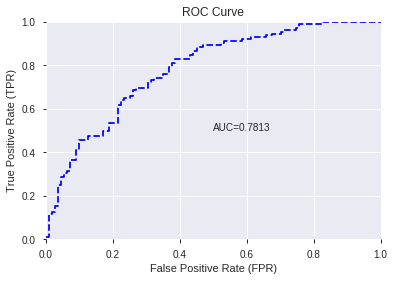

This function is available for GLM models only


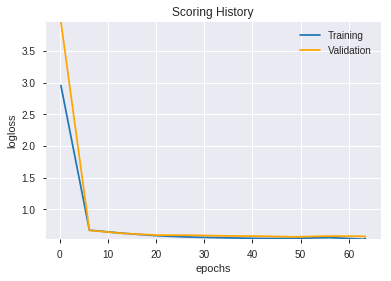

--2019-08-27 14:17:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  59.8MB/s    in 5.7s    

2019-08-27 14:17:06 (61.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_135046_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_135046_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_141717_model_8  0.790782  0.577652              0.242479  0.439952  0.193558
1  DeepLearning_grid_1_AutoML_20190827_141717_model_5  0.783703  0.575564              0.246782  0.442880  0.196143
2  DeepLearning_grid_1_AutoML_20190827_141717_model_9  0.782497  0.564273              0.247265  0.435846  0.189961
3  DeepLearning_grid_1_AutoML_20190827_141717_model_4  0.779440  0.756601              0.292431  0.483373  0.233650
4  DeepLearning_grid_1_AutoML_20190827_141717_model_3  0.774453  0.639201              0.323962  0.455354  0.207348
5  DeepLearning_grid_1_AutoML_20190827_141717_model_7  0.773407  0.634524              0.265364  0.446534  0.199393
6  DeepLearning_grid_1_AutoML_20190827_141717_model_6  0.773327  0.593686              0.287725  0.451674  0.204009
7               DeepLearning_1_AutoML_20190827_141717  0.756515  0.655116              0.287564  0.462500  0.213906
8  DeepLearning_grid_1_AutoML_20190827_141717_model_2  0.747989  0.672365              0.355695  0.471616  0.222422
9  DeepLearning_grid_1_AutoML_20190827_141717_model_1  0.735521  0.893222              0.333172  0.512695  0.262856

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.041690
1                  BOP             0.818208           0.818208    0.034111
2                 hour             0.687076           0.687076    0.028644
3               ULTOSC             0.602591           0.602591    0.025122
4               SAREXT             0.589581           0.589581    0.024579
5            CDLHAMMER             0.570024           0.570024    0.023764
6            CORREL_12             0.566056           0.566056    0.023599
7                  SUB             0.560688           0.560688    0.023375
8       STOCHRSI_fastd             0.548455           0.548455    0.022865
9                  OBV             0.546100           0.546100    0.022767
10                 DIV             0.540349           0.540349    0.022527
11        CDLSHORTLINE             0.528788           0.528788    0.022045
12          MINUS_DI_8             0.523930           0.523930    0.021842
13             BETA_12             0.517054           0.517054    0.021556
14      CDLSPINNINGTOP             0.511674           0.511674    0.021332
15          aroonup_14             0.504175           0.504175    0.021019
16              BETA_8             0.491936           0.491936    0.020509
17         AROONOSC_14             0.491136           0.491136    0.020475
18              TRANGE             0.485086           0.485086    0.020223
19          PLUS_DM_12             0.482921           0.482921    0.020133
20      STOCHRSI_fastk             0.481629           0.481629    0.020079
21             WILLR_8             0.481092           0.481092    0.020057
22               CCI_8             0.479095           0.479095    0.019973
23         CDLLONGLINE             0.465033           0.465033    0.019387
24        STOCHF_fastk             0.461640           0.461640    0.019246
25           CORREL_14             0.460744           0.460744    0.019208
26           CORREL_24             0.449835           0.449835    0.018753
27         CDLMARUBOZU             0.439755           0.439755    0.018333
28            WILLR_14             0.439017           0.439017    0.018302
29         CDLHIGHWAVE             0.429816           0.429816    0.017919
30            WILLR_12             0.429505           0.429505    0.017906
31          PLUS_DI_12             0.424774           0.424774    0.017709
32        CDLENGULFING             0.421495           0.421495    0.017572
33           aroonup_8             0.421474           0.421474    0.017571
34                  AD             0.420897           0.420897    0.017547
35          AROONOSC_8             0.420449           0.420449    0.017528
36           PLUS_DI_8             0.416202           0.416202    0.017351
37               ADOSC             0.412793           0.412793    0.017209
38      is_month_start             0.409946           0.409946    0.017091
39     CDLSHOOTINGSTAR             0.408068           0.408068    0.017012
40           PLUS_DM_8             0.405694           0.405694    0.016913
41              CCI_12             0.403479           0.403479    0.016821
42         CDLBELTHOLD             0.402985           0.402985    0.016800
43   CDLGRAVESTONEDOJI             0.400904           0.400904    0.016714
44              Volume             0.372578           0.372578    0.015533
45            WILLR_20             0.366449           0.366449    0.015277
46         CDL3OUTSIDE             0.346507           0.346507    0.014446
47    CDLDRAGONFLYDOJI             0.343595           0.343595    0.014324
48           CDLTAKURI             0.318422           0.318422    0.013275
49       CDLHANGINGMAN             0.287036           0.287036    0.011966

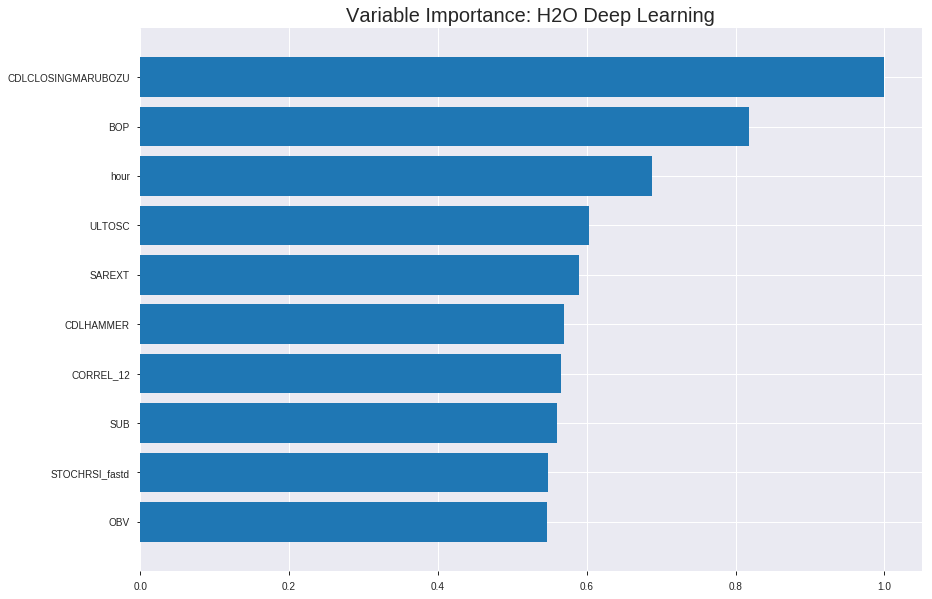

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_141717_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.15219703930736117
RMSE: 0.39012438953154566
LogLoss: 0.4608517610044201
Mean Per-Class Error: 0.21538723370505442
AUC: 0.8701956203125233
pr_auc: 0.8741871242514507
Gini: 0.7403912406250466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41683169081150706: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      557  212  0.2757   (212.0/769.0)
1      132  655  0.1677   (132.0/787.0)
Total  689  867  0.2211   (344.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416832     0.792019  228
max f2                       0.261535     0.875912  304
max f0point5                 0.578012     0.810811  155
max accuracy                 0.482927     0.784062  194
max precision                0.99947      1         0
max recall                   0.127868     1         359
max specificity              0.99947      1         0
max absolute_mcc             0.482927     0.571439  194
max min_per_class_accuracy   0.449168     0.780178  211
max mean_per_class_accuracy  0.482927     0.784613  194

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 49.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.998107           1.97713    1.97713            1                0.998851   1                           0.998851            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.996501           1.97713    1.97713            1                0.997133   1                           0.997992            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.994509           1.97713    1.97713            1                0.99558    1                           0.997222            0.0190597       0.0597205                  97.7128   97.7128
    4        0.0404884                   0.989546           1.97713    1.97713            1                0.992543   1                           0.996034            0.0203304       0.0800508                  97.7128   97.7128
    5        0.0501285                   0.984431           1.97713    1.97713            1                0.987024   1                           0.994301            0.0190597       0.0991105                  97.7128   97.7128
    6        0.100257                    0.923371           1.92643    1.95178            0.974359         0.960444   0.987179                    0.977373            0.0965693       0.19568                    92.6433   95.1781
    7        0.150386                    0.837314           1.85039    1.91798            0.935897         0.883182   0.970085                    0.945976            0.0927573       0.288437                   85.0389   91.7983
    8        0.200514                    0.742031           1.77435    1.88207            0.897436         0.786436   0.951923                    0.906091            0.0889454       0.377382                   77.4346   88.2074
    9        0.300129                    0.627145           1.64548    1.80355            0.832258         0.682613   0.912206                    0.831917            0.163914        0.541296                   64.5481   80.3547
    10       0.400386                    0.526038           1.24204    1.66295            0.628205         0.571348   0.841091                    0.76667             0.124524        0.66582                    24.2042   66.2946
    11       0.5                         0.45013            1.10974    1.55273            0.56129          0.486859   0.785347                    0.710924            0.110546        0.776366                   10.9743   55.2732
    12       0.600257                    0.389301           0.798456   1.42675            0.403846         0.419288   0.721627                    0.662214            0.0800508       0.856417                   -20.1544  42.675
    13       0.699871                    0.329609           0.688806   1.32172            0.348387         0.360276   0.668503                    0.619238            0.068615        0.925032                   -31.1194  32.1717
    14       0.800129                    0.256374           0.506956   1.21963            0.25641          0.295637   0.616867                    0.578691            0.0508259       0.975858                   -49.3044  21.9626
    15       0.899743                    0.162793           0.191335   1.10578            0.0967742        0.211676   0.559286                    0.538057            0.0190597       0.994917                   -80.8665  10.578
    16       1                           0.000629419        0.0506956  1                  0.025641         0.0810906  0.505784   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17577287949229636
RMSE: 0.41925276324944644
LogLoss: 0.5231803392146813
Mean Per-Class Error: 0.2518078616733326
AUC: 0.8185169474407142
pr_auc: 0.8196486460369217
Gini: 0.6370338948814285
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3854031511175461: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      150  72   0.3243   (72.0/222.0)
1      41   182  0.1839   (41.0/223.0)
Total  191  254  0.2539   (113.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385403     0.763103  228
max f2                       0.0839841    0.855061  368
max f0point5                 0.461415     0.758621  181
max accuracy                 0.395302     0.748315  223
max precision                0.998774     1         0
max recall                   0.0839841    1         368
max specificity              0.998774     1         0
max absolute_mcc             0.392925     0.499921  224
max min_per_class_accuracy   0.432006     0.743243  202
max mean_per_class_accuracy  0.395302     0.748192  223

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 47.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.995064           1.99552   1.99552            1                0.997422   1                           0.997422            0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.990827           1.99552   1.99552            1                0.993193   1                           0.995542            0.0179372       0.0403587                  99.5516   99.5516
    3        0.0314607                   0.98707            1.99552   1.99552            1                0.989359   1                           0.993334            0.0224215       0.0627803                  99.5516   99.5516
    4        0.0404494                   0.983429           1.49664   1.88465            0.75             0.984952   0.944444                    0.991471            0.0134529       0.0762332                  49.6637   88.4654
    5        0.0516854                   0.976094           1.99552   1.90875            1                0.98143    0.956522                    0.989288            0.0224215       0.0986547                  99.5516   90.8754
    6        0.101124                    0.910513           1.90481   1.90683            0.954545         0.950776   0.955556                    0.97046             0.0941704       0.192825                   90.481    90.6826
    7        0.150562                    0.794478           1.7234    1.8466             0.863636         0.836423   0.925373                    0.926448            0.0852018       0.278027                   72.34     84.6597
    8        0.2                         0.720588           1.7234    1.81614            0.863636         0.761065   0.910112                    0.885567            0.0852018       0.363229                   72.34     81.6143
    9        0.301124                    0.601785           1.37469   1.66789            0.688889         0.663221   0.835821                    0.810898            0.139013        0.502242                   37.4689   66.7894
    10       0.4                         0.505627           1.26987   1.56951            0.636364         0.551922   0.786517                    0.746882            0.125561        0.627803                   26.9874   56.9507
    11       0.501124                    0.432006           1.15296   1.48545            0.577778         0.46207    0.744395                    0.689409            0.116592        0.744395                   15.2965   48.5451
    12       0.6                         0.369341           0.816347  1.37519            0.409091         0.398079   0.689139                    0.641399            0.0807175       0.825112                   -18.3653  37.5187
    13       0.698876                    0.306241           0.725642  1.28329            0.363636         0.340278   0.643087                    0.598797            0.0717489       0.896861                   -27.4358  28.329
    14       0.8                         0.244768           0.443448  1.17713            0.222222         0.274577   0.589888                    0.557814            0.044843        0.941704                   -55.6552  17.713
    15       0.898876                    0.124204           0.453526  1.09753            0.227273         0.188628   0.55                        0.517204            0.044843        0.986547                   -54.6474  9.75336
    16       1                           0.00534994         0.133034  1                  0.0666667        0.0649067  0.501124                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:22:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:22:25  1 min  7.261 sec  650 obs/sec       0.604113  1             940        0.44988          0.617603            0.190322       0.787988        0.787306           1.72999          0.322622                         0.449772           0.618069              0.190817         0.793853          0.784237             1.99552            0.276404
    2019-08-27 14:22:35  1 min 17.245 sec  1014 obs/sec      6.86054   11            10675      0.418167         0.522884            0.300452       0.819414        0.822134           1.97713          0.273779                         0.422017           0.531087              0.287603         0.810942          0.811904             1.99552            0.267416
    2019-08-27 14:22:44  1 min 26.337 sec  1134 obs/sec      13.6639   22            21261      0.420556         0.528212            0.292434       0.830185        0.838041           1.97713          0.25964                          0.425047           0.537246              0.277337         0.812467          0.811545             1.99552            0.25618
    2019-08-27 14:22:53  1 min 35.431 sec  1217 obs/sec      21.0861   34            32810      0.405395         0.492508            0.342533       0.845409        0.848715           1.97713          0.242931                         0.425641           0.542111              0.275317         0.812538          0.805581             1.99552            0.260674
    2019-08-27 14:23:02  1 min 44.765 sec  1277 obs/sec      29.081    47            45250      0.400281         0.483672            0.359016       0.852762        0.860277           1.97713          0.246787                         0.422436           0.531501              0.286189         0.810124          0.809864             1.99552            0.265169
    2019-08-27 14:23:12  1 min 53.878 sec  1321 obs/sec      37.0913   60            57714      0.390124         0.460852            0.39113        0.870196        0.874187           1.97713          0.22108                          0.419253           0.52318               0.296905         0.818517          0.819649             1.99552            0.253933
    2019-08-27 14:23:21  2 min  2.927 sec  1353 obs/sec      45.0861   73            70154      0.37687          0.432665            0.431801       0.883292        0.852731           1.97713          0.206941                         0.432387           0.567636              0.252161         0.79452           0.778233             1.99552            0.267416
    2019-08-27 14:23:22  2 min  3.846 sec  1352 obs/sec      45.0861   73            70154      0.390124         0.460852            0.39113        0.870196        0.874187           1.97713          0.22108                          0.419253           0.52318               0.296905         0.818517          0.819649             1.99552            0.253933

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.04168970593575271
BOP                 0.818207859992981      0.818207859992981    0.034110845077428904
hour                0.6870757341384888     0.6870757341384888   0.028643985311825007
ULTOSC              0.6025914549827576     0.6025914549827576   0.025121860557628533
SAREXT              0.5895805358886719     0.5895805358886719   0.02457943916664223
---                 ---                    ---                  ---
WILLR_20            0.3664492070674896     0.3664492070674896   0.015277159683033397
CDL3OUTSIDE         0.34650665521621704    0.34650665521621704  0.014445760560745343
CDLDRAGONFLYDOJI    0.343595415353775      0.343595415353775    0.014324391826971693
CDLTAKURI           0.3184216022491455     0.3184216022491455   0.013274902961358092
CDLHANGINGMAN       0.2870360314846039     0.2870360314846039   0.011966447745558594


See the whole table with table.as_data_frame()


('accuracy', 0.757847533632287)

('F1', 0.7750000000000001)

('auc', 0.7907818532818532)

('logloss', 0.5776515103534707)

('mean_per_class_error', 0.2424790862290862)

('rmse', 0.4399519783151827)

('mse', 0.193557743223443)

deeplearning prediction progress: |███████████████████████████████████████| 100%


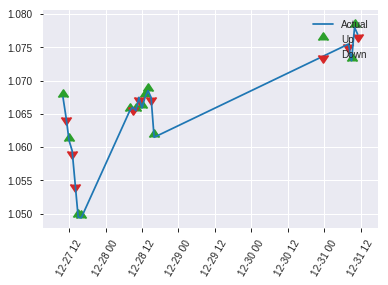


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.193557743223443
RMSE: 0.4399519783151827
LogLoss: 0.5776515103534707
Mean Per-Class Error: 0.2424790862290862
AUC: 0.7907818532818532
pr_auc: 0.745459385481877
Gini: 0.5815637065637065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41116333625317825: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   35   0.3153   (35.0/111.0)
1      19   93   0.1696   (19.0/112.0)
Total  95   128  0.2422   (54.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411163     0.775     127
max f2                       0.194957     0.863142  194
max f0point5                 0.411163     0.745192  127
max accuracy                 0.411163     0.757848  127
max precision                0.778043     0.909091  21
max recall                   0.154286     1         203
max specificity              0.990673     0.990991  0
max absolute_mcc             0.411163     0.52077   127
max min_per_class_accuracy   0.449623     0.720721  111
max mean_per_class_accuracy  0.411163     0.757521  127

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 46.59 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.982768           1.32738    1.32738            0.666667         0.988876  0.666667                    0.988876            0.0178571       0.0178571                  32.7381    32.7381
    2        0.0224215                   0.968024           0.995536   1.19464            0.5              0.971832  0.6                         0.982059            0.00892857      0.0267857                  -0.446429  19.4643
    3        0.0313901                   0.957549           1.99107    1.42219            1                0.962395  0.714286                    0.976441            0.0178571       0.0446429                  99.1071    42.2194
    4        0.0403587                   0.917943           1.99107    1.54861            1                0.951268  0.777778                    0.970847            0.0178571       0.0625                     99.1071    54.8611
    5        0.0538117                   0.903594           1.99107    1.65923            1                0.909336  0.833333                    0.955469            0.0267857       0.0892857                  99.1071    65.9226
    6        0.103139                    0.746154           1.81006    1.73137            0.909091         0.828209  0.869565                    0.894605            0.0892857       0.178571                   81.0065    73.1366
    7        0.152466                    0.697126           1.26705    1.58114            0.636364         0.726226  0.794118                    0.84013             0.0625          0.241071                   26.7045    58.1145
    8        0.201794                    0.640443           1.44805    1.54861            0.727273         0.664906  0.777778                    0.797297            0.0714286       0.3125                     44.8052    54.8611
    9        0.300448                    0.551689           1.53856    1.54531            0.772727         0.600968  0.776119                    0.732831            0.151786        0.464286                   53.8555    54.5309
    10       0.399103                    0.497583           1.26705    1.47652            0.636364         0.522927  0.741573                    0.680945            0.125           0.589286                   26.7045    47.6525
    11       0.502242                    0.449623           1.29852    1.43997            0.652174         0.47448   0.723214                    0.638546            0.133929        0.723214                   29.8525    43.9971
    12       0.600897                    0.401754           1.17654    1.39672            0.590909         0.42488   0.701493                    0.603466            0.116071        0.839286                   17.6542    39.6722
    13       0.699552                    0.357973           0.633523   1.28909            0.318182         0.382617  0.647436                    0.572321            0.0625          0.901786                   -36.6477   28.9091
    14       0.798206                    0.29434            0.452516   1.18569            0.227273         0.324854  0.595506                    0.541735            0.0446429       0.946429                   -54.7484   18.5694
    15       0.896861                    0.174584           0.452516   1.10504            0.227273         0.233306  0.555                       0.507808            0.0446429       0.991071                   -54.7484   10.5045
    16       1                           0.0260659          0.0865683  1                  0.0434783        0.1019    0.502242  

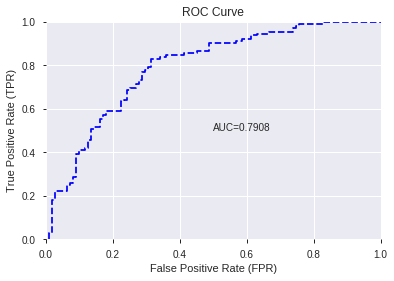

This function is available for GLM models only


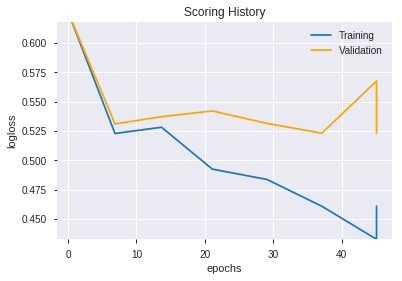

--2019-08-27 14:24:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_141717_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_141717_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'hour',
 'ULTOSC',
 'SAREXT',
 'CDLHAMMER',
 'CORREL_12',
 'SUB',
 'STOCHRSI_fastd',
 'OBV',
 'DIV',
 'CDLSHORTLINE',
 'MINUS_DI_8',
 'BETA_12',
 'CDLSPINNINGTOP',
 'aroonup_14',
 'BETA_8',
 'AROONOSC_14',
 'TRANGE',
 'PLUS_DM_12',
 'STOCHRSI_fastk',
 'WILLR_8',
 'CCI_8',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'CORREL_14',
 'CORREL_24',
 'CDLMARUBOZU',
 'WILLR_14',
 'CDLHIGHWAVE',
 'WILLR_12',
 'PLUS_DI_12',
 'CDLENGULFING',
 'aroonup_8',
 'AD',
 'AROONOSC_8',
 'PLUS_DI_8',
 'ADOSC',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'PLUS_DM_8',
 'CCI_12',
 'CDLBELTHOLD',
 'CDLGRAVESTONEDOJI',
 'Volume',
 'WILLR_20',
 'CDL3OUTSIDE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHANGINGMAN']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_142435_model_1  0.782819  0.57107              0.265404  0.440478  0.194021

variable  relative_importance  scaled_importance  percentage
0                  SUB             2.091614           1.000000    0.183300
1                  DIV             1.515234           0.724433    0.132789
2                  BOP             0.823048           0.393499    0.072128
3   CDLCLOSINGMARUBOZU             0.494237           0.236295    0.043313
4               ULTOSC             0.464848           0.222244    0.040737
5           MINUS_DI_8             0.455329           0.217693    0.039903
6             WILLR_14             0.432897           0.206968    0.037937
7                CCI_8             0.365406           0.174701    0.032023
8            CDLTAKURI             0.339747           0.162433    0.029774
9            PLUS_DI_8             0.339280           0.162209    0.029733
10    CDLDRAGONFLYDOJI             0.301160           0.143985    0.026392
11        STOCHF_fastk             0.291710           0.139467    0.025564
12           PLUS_DM_8             0.254797           0.121818    0.022329
13           CDLHAMMER             0.237916           0.113748    0.020850
14           aroonup_8             0.214313           0.102463    0.018781
15          AROONOSC_8             0.196630           0.094009    0.017232
16            WILLR_12             0.176049           0.084169    0.015428
17           CORREL_24             0.167035           0.079860    0.014638
18              CCI_12             0.166178           0.079450    0.014563
19         CDLLONGLINE             0.163536           0.078187    0.014332
20             BETA_12             0.155465           0.074328    0.013624
21     CDLSHOOTINGSTAR             0.150290           0.071854    0.013171
22         CDLMARUBOZU             0.144421           0.069047    0.012656
23                hour             0.132228           0.063218    0.011588
24         AROONOSC_14             0.127578           0.060995    0.011180
25              BETA_8             0.109716           0.052455    0.009615
26           CORREL_12             0.104831           0.050119    0.009187
27      STOCHRSI_fastd             0.082269           0.039333    0.007210
28          PLUS_DM_12             0.080861           0.038659    0.007086
29   CDLGRAVESTONEDOJI             0.077811           0.037201    0.006819
30              SAREXT             0.077373           0.036992    0.006781
31      CDLSPINNINGTOP             0.069315           0.033139    0.006074
32         CDL3OUTSIDE             0.067577           0.032308    0.005922
33          aroonup_14             0.066635           0.031858    0.005840
34              Volume             0.058027           0.027743    0.005085
35              TRANGE             0.057595           0.027536    0.005047
36          PLUS_DI_12             0.054101           0.025866    0.004741
37      is_month_start             0.040430           0.019329    0.003543
38         CDLBELTHOLD             0.038452           0.018384    0.003370
39       CDLHANGINGMAN             0.034011           0.016261    0.002981
40                 OBV             0.032025           0.015311    0.002807
41        CDLSHORTLINE             0.030064           0.014373    0.002635
42             WILLR_8             0.021455           0.010258    0.001880
43                  AD             0.020801           0.009945    0.001823
44        CDLENGULFING             0.020420           0.009763    0.001789
45      STOCHRSI_fastk             0.017169           0.008209    0.001505
46            WILLR_20             0.014613           0.006986    0.001281
47               ADOSC             0.012936           0.006185    0.001134
48         CDLHIGHWAVE             0.012812           0.006125    0.001123
49           CORREL_14             0.008632           0.004127    0.000756

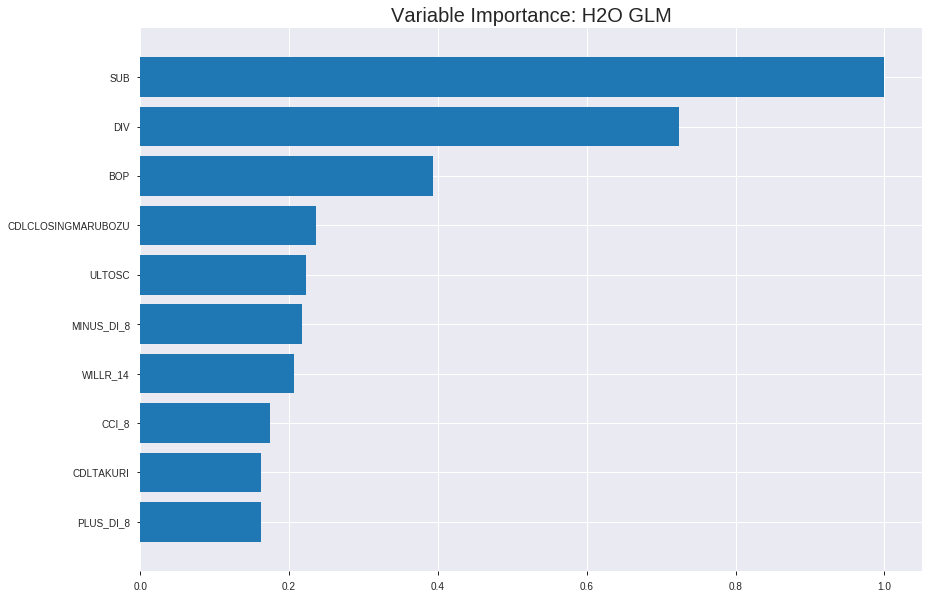

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_142435_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1735715919493564
RMSE: 0.4166192409735254
LogLoss: 0.5201621433886376
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2156.8657950370343
Residual deviance: 1618.7445902254403
AIC: 1720.7445902254403
AUC: 0.8196943835374246
pr_auc: 0.822653824393931
Gini: 0.6393887670748493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3904308203963759: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      459  310  0.4031   (310.0/769.0)
1      110  677  0.1398   (110.0/787.0)
Total  569  987  0.2699   (420.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390431     0.763247  253
max f2                       0.154932     0.854882  343
max f0point5                 0.664104     0.759253  134
max accuracy                 0.479982     0.743573  218
max precision                0.984991     1         0
max recall                   0.0198354    1         393
max specificity              0.984991     1         0
max absolute_mcc             0.479982     0.489125  218
max min_per_class_accuracy   0.526228     0.737321  196
max mean_per_class_accuracy  0.479982     0.742937  218

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.963505           1.97713   1.97713            1                0.972721   1                           0.972721            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.950249           1.97713   1.97713            1                0.95843    1                           0.965576            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.936358           1.84532   1.93506            0.933333         0.943106   0.978723                    0.958405            0.0177891       0.0584498                  84.532    93.5062
    4        0.0404884                   0.930653           1.60642   1.8516             0.8125           0.933728   0.936508                    0.952138            0.0165184       0.0749682                  60.6417   85.1596
    5        0.0501285                   0.915985           1.84532   1.85039            0.933333         0.922198   0.935897                    0.94638             0.0177891       0.0927573                  84.532    85.0389
    6        0.100257                    0.875535           1.87574   1.86306            0.948718         0.893661   0.942308                    0.92002             0.094028        0.186785                   87.5737   86.3063
    7        0.150386                    0.822048           1.749     1.82504            0.884615         0.848965   0.923077                    0.896335            0.0876747       0.27446                    74.8998   82.5042
    8        0.200514                    0.781              1.67295   1.78702            0.846154         0.803365   0.903846                    0.873093            0.0838628       0.358323                   67.2955   78.702
    9        0.300129                    0.693194           1.49241   1.68924            0.754839         0.740882   0.85439                     0.829211            0.148666        0.506989                   49.2413   68.9238
    10       0.400386                    0.609732           1.22937   1.57409            0.621795         0.650982   0.796148                    0.784583            0.123253        0.630241                   22.9368   57.4086
    11       0.5                         0.528381           1.03321   1.46633            0.522581         0.568925   0.741645                    0.741617            0.102922        0.733164                   3.3209    46.6328
    12       0.600257                    0.434608           0.937869  1.37806            0.474359         0.483347   0.697002                    0.69848             0.094028        0.827192                   -6.21314  37.8063
    13       0.699871                    0.315038           0.67605   1.27814            0.341935         0.37592    0.646465                    0.652569            0.0673443       0.894536                   -32.395   27.8144
    14       0.800129                    0.21611            0.544978  1.18628            0.275641         0.266415   0.6                         0.604184            0.0546379       0.949174                   -45.5022  18.6277
    15       0.899743                    0.113289           0.318892  1.09025            0.16129          0.164788   0.551429                    0.555537            0.0317662       0.98094                    -68.1108  9.02451
    16       1                           0.00258433         0.190108  1                  0.0961538        0.0592877  0.505784                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17719508879836918
RMSE: 0.420945470100783
LogLoss: 0.5311972457654347
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 616.9374079624531
Residual deviance: 472.7655487312369
AIC: 574.7655487312369
AUC: 0.8143457358703996
pr_auc: 0.8140788793532495
Gini: 0.6286914717407992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4172101744858455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      159  63   0.2838   (63.0/222.0)
1      46   177  0.2063   (46.0/223.0)
Total  205  240  0.2449   (109.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41721      0.764579  213
max f2                       0.0949787    0.853468  351
max f0point5                 0.524652     0.763547  174
max accuracy                 0.488459     0.755056  186
max precision                0.968075     1         0
max recall                   0.0279551    1         382
max specificity              0.968075     1         0
max absolute_mcc             0.41721      0.511522  213
max min_per_class_accuracy   0.459547     0.748879  196
max mean_per_class_accuracy  0.488459     0.75511   186

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 46.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.950174           1.99552   1.99552            1                0.956374   1                           0.956374            0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.929547           1.99552   1.99552            1                0.938373   1                           0.948374            0.0179372       0.0403587                  99.5516   99.5516
    3        0.0314607                   0.920352           1.59641   1.85298            0.8              0.925596   0.928571                    0.940239            0.0179372       0.058296                   59.6413   85.2979
    4        0.0404494                   0.915828           1.99552   1.88465            1                0.918469   0.944444                    0.935401            0.0179372       0.0762332                  99.5516   88.4654
    5        0.0516854                   0.910975           1.99552   1.90875            1                0.913773   0.956522                    0.930699            0.0224215       0.0986547                  99.5516   90.8754
    6        0.101124                    0.869785           1.90481   1.90683            0.954545         0.892253   0.955556                    0.911903            0.0941704       0.192825                   90.481    90.6826
    7        0.150562                    0.807509           1.81411   1.87638            0.909091         0.836483   0.940299                    0.887139            0.0896861       0.282511                   81.4105   87.638
    8        0.2                         0.766888           1.45128   1.7713             0.727273         0.784107   0.88764                     0.86167             0.0717489       0.35426                    45.1284   77.13
    9        0.301124                    0.677825           1.286     1.60833            0.644444         0.718808   0.80597                     0.813694            0.130045        0.484305                   28.5999   60.8326
    10       0.4                         0.566633           1.36058   1.54709            0.681818         0.625783   0.775281                    0.767244            0.134529        0.618834                   36.0579   54.7085
    11       0.501124                    0.458056           1.286     1.4944             0.644444         0.513982   0.748879                    0.716137            0.130045        0.748879                   28.5999   49.44
    12       0.6                         0.340936           0.816347  1.38266            0.409091         0.403733   0.692884                    0.664655            0.0807175       0.829596                   -18.3653  38.2661
    13       0.698876                    0.240605           0.680289  1.28329            0.340909         0.291081   0.643087                    0.611802            0.0672646       0.896861                   -31.9711  28.329
    14       0.8                         0.16229            0.443448  1.17713            0.222222         0.204751   0.589888                    0.560349            0.044843        0.941704                   -55.6552  17.713
    15       0.898876                    0.072912           0.408174  1.09254            0.204545         0.119526   0.5475                      0.511859            0.0403587       0.982063                   -59.1826  9.25448
    16       1                           0.00365885         0.177379  1                  0.0888889        0.0310025  0.501124                    0.4632


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:24:36  0.000 sec   2            .21E2     51            1.3614362825067925  1.361601498150941
     2019-08-27 14:24:36  0.076 sec   4            .13E2     51            1.3490387287736312  1.3490529096547639
     2019-08-27 14:24:36  0.111 sec   6            .83E1     51            1.3320391828155473  1.3317240437590188
     2019-08-27 14:24:36  0.135 sec   8            .51E1     51            1.3100091463108219  1.3090852125583283
     2019-08-27 14:24:36  0.158 sec   10           .32E1     51            1.2830466454511809  1.2812054275949842
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:24:36  0.742 sec   52           .14E-3    51            1.0403242867772755  1.0623944915308694
     2019-08-27 14:24:36  0.755 sec   53           .89E-4    51            1.0400141064376207  1.062396598764465
     2019-08-27 14:24:36  0.764 sec   54           .56E-4    51            1.0398274389436133  1.0624569652862654
     2019-08-27 14:24:36  0.774 sec   55           .34E-4    51            1.0397254821362596  1.062540276723851
     2019-08-27 14:24:36  0.791 sec   56           .21E-4    51            1.0396737973903956  1.0626271135399787


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7354260089686099)

('F1', 0.7773584905660378)

('auc', 0.7828185328185328)

('logloss', 0.5710696059813591)

('mean_per_class_error', 0.26451898326898327)

('rmse', 0.4404777446265985)

('mse', 0.19402064351133494)

glm prediction progress: |████████████████████████████████████████████████| 100%


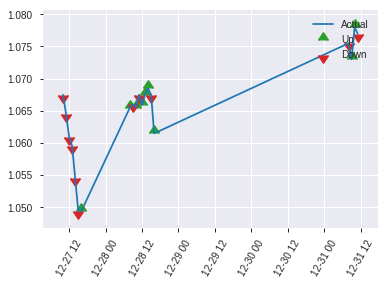


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19402064351133494
RMSE: 0.4404777446265985
LogLoss: 0.5710696059813591
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.15034943754756
Residual deviance: 254.69704426768615
AIC: 356.6970442676861
AUC: 0.7828185328185328
pr_auc: 0.7397385230906621
Gini: 0.5656370656370655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2609655964064331: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   50   0.4505   (50.0/111.0)
1      9    103  0.0804   (9.0/112.0)
Total  70   153  0.2646   (59.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.260966     0.777358  152
max f2                       0.220043     0.862069  160
max f0point5                 0.484201     0.739051  108
max accuracy                 0.484201     0.735426  108
max precision                0.956536     1         0
max recall                   0.0361518    1         211
max specificity              0.956536     1         0
max absolute_mcc             0.260966     0.505506  152
max min_per_class_accuracy   0.484201     0.723214  108
max mean_per_class_accuracy  0.484201     0.735481  108

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 44.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.927764           1.99107    1.99107            1                0.941031   1                           0.941031            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.906083           0.995536   1.59286            0.5              0.916116   0.8                         0.931065            0.00892857      0.0357143                  -0.446429  59.2857
    3        0.0313901                   0.889674           1.99107    1.70663            1                0.893415   0.857143                    0.920308            0.0178571       0.0535714                  99.1071    70.6633
    4        0.0403587                   0.867334           1.99107    1.76984            1                0.878033   0.888889                    0.910913            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.860474           1.32738    1.65923            0.666667         0.865025   0.833333                    0.899441            0.0178571       0.0892857                  32.7381    65.9226
    6        0.103139                    0.805833           1.62906    1.6448             0.818182         0.824442   0.826087                    0.863572            0.0803571       0.169643                   62.9058    64.4798
    7        0.152466                    0.758937           1.62906    1.63971            0.818182         0.783622   0.823529                    0.837706            0.0803571       0.25                       62.9058    63.9706
    8        0.201794                    0.719056           1.26705    1.54861            0.636364         0.737506   0.777778                    0.813213            0.0625          0.3125                     26.7045    54.8611
    9        0.300448                    0.598813           1.17654    1.42644            0.590909         0.666366   0.716418                    0.764994            0.116071        0.428571                   17.6542    42.6439
    10       0.399103                    0.540998           1.81006    1.52127            0.909091         0.57165    0.764045                    0.717201            0.178571        0.607143                   81.0065    52.1268
    11       0.502242                    0.479219           1.12539    1.43997            0.565217         0.506938   0.723214                    0.674022            0.116071        0.723214                   12.5388    43.9971
    12       0.600897                    0.364287           1.08604    1.38186            0.545455         0.420743   0.69403                     0.632439            0.107143        0.830357                   8.6039     38.1863
    13       0.699552                    0.245079           0.905032   1.31462            0.454545         0.303676   0.660256                    0.586075            0.0892857       0.919643                   -9.49675   31.4618
    14       0.798206                    0.158552           0.27151    1.18569            0.136364         0.20337    0.595506                    0.538775            0.0267857       0.946429                   -72.849    18.5694
    15       0.896861                    0.0773035          0.452516   1.10504            0.227273         0.111886   0.555                       0.491817            0.0446429       0.991071                   -54.7484   10.5045
    16       1                           0.00404525         0.0865683  1                  0.0434783        0.0

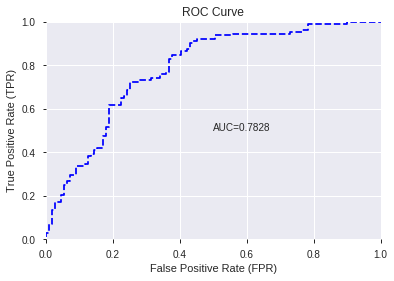

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


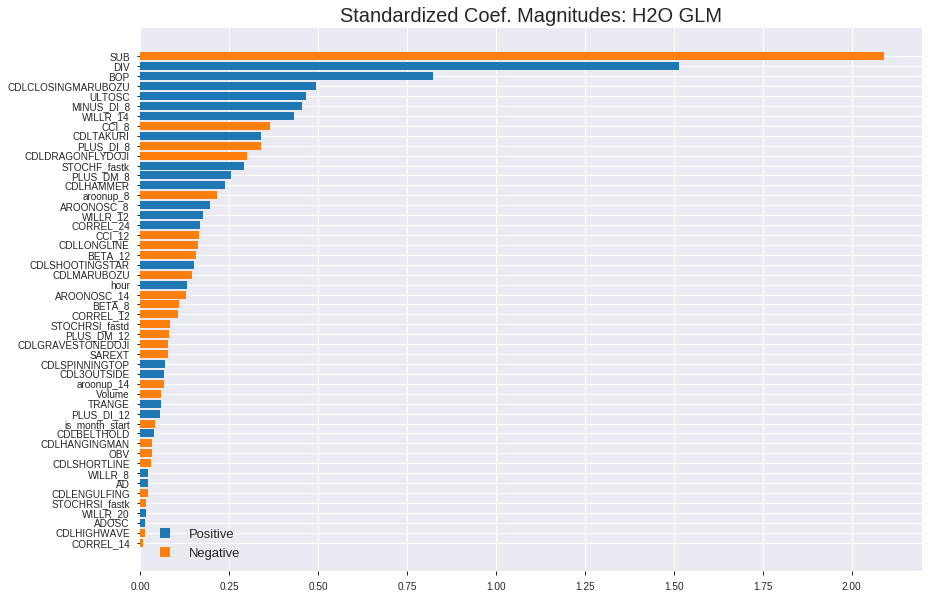

'log_likelihood'
--2019-08-27 14:24:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.44
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.44|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_142435_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_142435_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SUB',
 'DIV',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'MINUS_DI_8',
 'WILLR_14',
 'CCI_8',
 'CDLTAKURI',
 'PLUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'PLUS_DM_8',
 'CDLHAMMER',
 'aroonup_8',
 'AROONOSC_8',
 'WILLR_12',
 'CORREL_24',
 'CCI_12',
 'CDLLONGLINE',
 'BETA_12',
 'CDLSHOOTINGSTAR',
 'CDLMARUBOZU',
 'hour',
 'AROONOSC_14',
 'BETA_8',
 'CORREL_12',
 'STOCHRSI_fastd',
 'PLUS_DM_12',
 'CDLGRAVESTONEDOJI',
 'SAREXT',
 'CDLSPINNINGTOP',
 'CDL3OUTSIDE',
 'aroonup_14',
 'Volume',
 'TRANGE',
 'PLUS_DI_12',
 'is_month_start',
 'CDLBELTHOLD',
 'CDLHANGINGMAN',
 'OBV',
 'CDLSHORTLINE',
 'WILLR_8',
 'AD',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'WILLR_20',
 'ADOSC',
 'CDLHIGHWAVE',
 'CORREL_14']

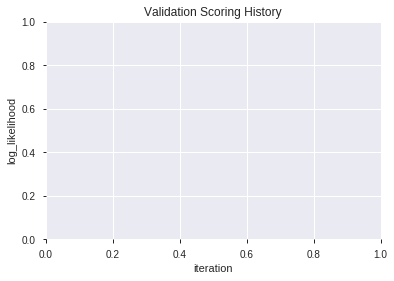

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_142449_model_4  0.804778  0.550338              0.269908  0.430959  0.185726
1  XGBoost_grid_1_AutoML_20190827_142449_model_3  0.792712  0.551100              0.265122  0.432219  0.186814
2  XGBoost_grid_1_AutoML_20190827_142449_model_2  0.790621  0.562405              0.247265  0.436167  0.190241
3  XGBoost_grid_1_AutoML_20190827_142449_model_6  0.789977  0.550827              0.251609  0.432872  0.187378
4               XGBoost_2_AutoML_20190827_142449  0.787725  0.568736              0.242479  0.440521  0.194059
5               XGBoost_3_AutoML_20190827_142449  0.785634  0.565270              0.246863  0.439572  0.193223
6               XGBoost_1_AutoML_20190827_142449  0.781049  0.568171              0.283301  0.441166  0.194627
7  XGBoost_grid_1_AutoML_20190827_142449_model_5  0.777831  0.572785              0.278676  0.441985  0.195350
8  XGBoost_grid_1_AutoML_20190827_142449_model_7  0.771638  0.571863              0.278596  0.442085  0.195439
9  XGBoost_grid_1_AutoML_20190827_142449_model_1  0.770833  0.576435              0.269385  0.444745  0.197798

variable  relative_importance  scaled_importance  percentage
0              BOP          1988.256958           1.000000    0.381164
1     STOCHF_fastk           496.256104           0.249594    0.095136
2              DIV           491.069916           0.246985    0.094142
3           ULTOSC           241.516953           0.121472    0.046301
4           TRANGE           167.915726           0.084454    0.032191
5             hour           157.453049           0.079191    0.030185
6            CCI_8           144.500305           0.072677    0.027702
7            ADOSC           139.617645           0.070221    0.026766
8          WILLR_8           127.288445           0.064020    0.024402
9        CORREL_24           116.610069           0.058649    0.022355
10  STOCHRSI_fastd           100.705452           0.050650    0.019306
11             SUB            99.765732           0.050177    0.019126
12      PLUS_DI_12            88.422218           0.044472    0.016951
13       aroonup_8            78.575737           0.039520    0.015064
14      MINUS_DI_8            76.021965           0.038235    0.014574
15              AD            56.361313           0.028347    0.010805
16         BETA_12            55.837345           0.028084    0.010704
17      PLUS_DM_12            55.600285           0.027964    0.010659
18          BETA_8            53.889690           0.027104    0.010331
19      aroonup_14            52.854095           0.026583    0.010133
20          SAREXT            45.494091           0.022881    0.008722
21       CORREL_14            41.065258           0.020654    0.007873
22        WILLR_20            39.605835           0.019920    0.007593
23       PLUS_DI_8            33.121765           0.016659    0.006350
24       PLUS_DM_8            33.043652           0.016619    0.006335
25        WILLR_14            32.300549           0.016246    0.006192
26          Volume            29.094147           0.014633    0.005578
27             OBV            28.058596           0.014112    0.005379
28       CORREL_12            26.554848           0.013356    0.005091
29  STOCHRSI_fastk            26.202650           0.013179    0.005023
30      AROONOSC_8            25.858889           0.013006    0.004957
31          CCI_12            25.090628           0.012619    0.004810
32        WILLR_12            24.512463           0.012329    0.004699
33     AROONOSC_14             9.547979           0.004802    0.001830
34  CDLSPINNINGTOP             8.201885           0.004125    0.001572

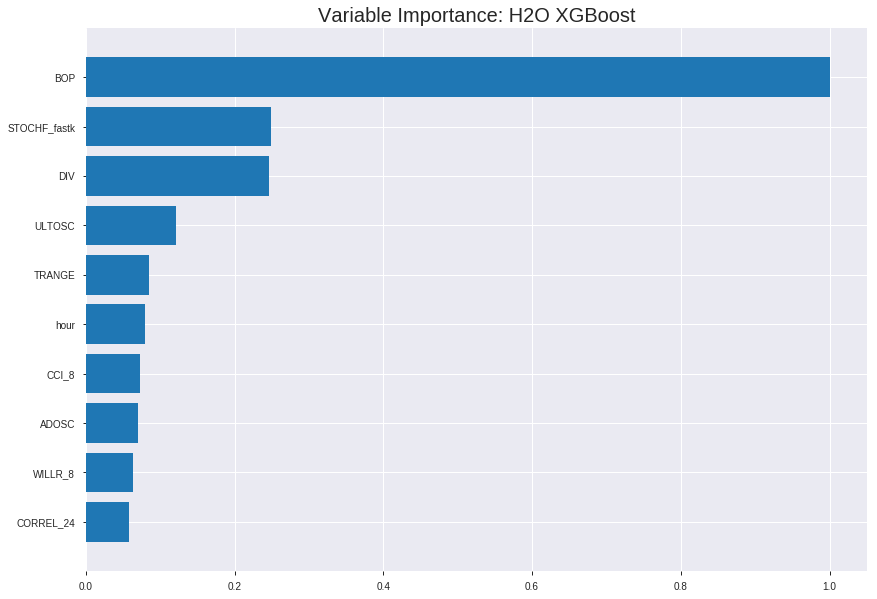

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_142449_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1642940339065592
RMSE: 0.4053320045426455
LogLoss: 0.5036243279584511
Mean Per-Class Error: 0.22673797056524836
AUC: 0.8480939453373496
pr_auc: 0.8439503853911616
Gini: 0.6961878906746992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45747052133083344: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      525  244  0.3173   (244.0/769.0)
1      122  665  0.155    (122.0/787.0)
Total  647  909  0.2352   (366.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457471     0.784198  229
max f2                       0.249251     0.863048  325
max f0point5                 0.649999     0.79124   124
max accuracy                 0.536619     0.773136  189
max precision                0.898019     1         0
max recall                   0.121607     1         387
max specificity              0.898019     1         0
max absolute_mcc             0.536619     0.546553  189
max min_per_class_accuracy   0.524592     0.772432  195
max mean_per_class_accuracy  0.536619     0.773262  189

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.864803           1.97713    1.97713            1                0.879767  1                           0.879767            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.855825           1.97713    1.97713            1                0.859993  1                           0.86988             0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.850072           1.84532    1.93506            0.933333         0.852903  0.978723                    0.864462            0.0177891       0.0584498                  84.532    93.5062
    4        0.0404884                   0.844226           1.85356    1.91436            0.9375           0.847577  0.968254                    0.860174            0.0190597       0.0775095                  85.3558   91.4362
    5        0.0501285                   0.835617           1.84532    1.90108            0.933333         0.840313  0.961538                    0.856354            0.0177891       0.0952986                  84.532    90.1085
    6        0.100257                    0.812302           1.79969    1.85039            0.910256         0.82284   0.935897                    0.839597            0.090216        0.185515                   79.9694   85.0389
    7        0.150386                    0.781128           1.77435    1.82504            0.897436         0.798079  0.923077                    0.825758            0.0889454       0.27446                    77.4346   82.5042
    8        0.200514                    0.741685           1.6983     1.79336            0.858974         0.758917  0.907051                    0.809047            0.0851334       0.359593                   69.8303   79.3357
    9        0.300129                    0.677467           1.63273    1.74004            0.825806         0.710965  0.880086                    0.776493            0.162643        0.522236                   63.2725   74.0042
    10       0.400386                    0.595671           1.33076    1.63756            0.673077         0.633893  0.82825                     0.740786            0.133418        0.655654                   33.0759   63.7557
    11       0.5                         0.52763            1.13525    1.53748            0.574194         0.563811  0.777635                    0.705528            0.113088        0.768742                   13.5254   53.7484
    12       0.600257                    0.445321           0.81113    1.41617            0.410256         0.488511  0.716274                    0.669281            0.0813215       0.850064                   -18.887   41.6166
    13       0.699871                    0.341386           0.688806   1.31264            0.348387         0.395867  0.663912                    0.630365            0.068615        0.918679                   -31.1194  31.2639
    14       0.800129                    0.253194           0.443586   1.20375            0.224359         0.294746  0.608835                    0.588312            0.0444727       0.963151                   -55.6414  20.3746
    15       0.899743                    0.172826           0.29338    1.10296            0.148387         0.214317  0.557857                    0.546905            0.0292249       0.992376                   -70.662   10.2955
    16       1                           0.0920313          0.0760434  1                  0.0384615        0.14112   0.505784                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19081166484138673
RMSE: 0.4368199455626846
LogLoss: 0.564025519941608
Mean Per-Class Error: 0.27184583686825836
AUC: 0.7859350381771906
pr_auc: 0.7404649063235779
Gini: 0.5718700763543811
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29300278425216675: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  107  0.482    (107.0/222.0)
1      23   200  0.1031   (23.0/223.0)
Total  138  307  0.2921   (130.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293003     0.754717  283
max f2                       0.173197     0.86166   342
max f0point5                 0.475442     0.733772  191
max accuracy                 0.475442     0.72809   191
max precision                0.816478     0.857143  31
max recall                   0.114502     1         393
max specificity              0.867225     0.995495  0
max absolute_mcc             0.475442     0.457029  191
max min_per_class_accuracy   0.456665     0.721973  202
max mean_per_class_accuracy  0.475442     0.728154  191

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 46.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.859613           1.19731   1.19731            0.6              0.863193  0.6                         0.863193            0.0134529       0.0134529                  19.7309    19.7309
    2        0.0202247                   0.85274            0.997758  1.10862            0.5              0.857945  0.555556                    0.86086             0.00896861      0.0224215                  -0.224215  10.862
    3        0.0314607                   0.843506           1.99552   1.42537            1                0.849102  0.714286                    0.856661            0.0224215       0.044843                   99.5516    42.5368
    4        0.0404494                   0.836765           1.49664   1.44121            0.75             0.839923  0.722222                    0.852941            0.0134529       0.058296                   49.6637    44.1206
    5        0.0516854                   0.832299           1.99552   1.56171            1                0.834347  0.782609                    0.848899            0.0224215       0.0807175                  99.5516    56.1708
    6        0.101124                    0.799497           1.63269   1.59641            0.818182         0.815164  0.8                         0.832406            0.0807175       0.161435                   63.2695    59.6413
    7        0.150562                    0.761783           1.90481   1.69768            0.954545         0.778648  0.850746                    0.814754            0.0941704       0.255605                   90.481     69.7678
    8        0.2                         0.72569            1.54199   1.65919            0.772727         0.743467  0.831461                    0.797133            0.0762332       0.331839                   54.1989    65.9193
    9        0.301124                    0.642074           1.37469   1.56365            0.688889         0.686282  0.783582                    0.759907            0.139013        0.470852                   37.4689    56.365
    10       0.4                         0.547375           1.17917   1.46861            0.590909         0.588878  0.735955                    0.71763             0.116592        0.587444                   17.9168    46.861
    11       0.501124                    0.452882           1.33034   1.44071            0.666667         0.497446  0.721973                    0.673198            0.134529        0.721973                   33.0344    44.0709
    12       0.6                         0.361888           0.907053  1.35277            0.454545         0.405422  0.677903                    0.62907             0.0896861       0.811659                   -9.29474   35.2765
    13       0.698876                    0.281246           0.907053  1.28971            0.454545         0.323428  0.646302                    0.585828            0.0896861       0.901345                   -9.29474   28.9706
    14       0.8                         0.20252            0.487793  1.18834            0.244444         0.24514   0.595506                    0.542764            0.0493274       0.950673                   -51.2207   18.8341
    15       0.898876                    0.145881           0.317468  1.09254            0.159091         0.169674  0.5475                      0.501724            0.0313901       0.982063                   -68.2532   9.25448
    16       1                           0.104767           0.177379  1                  0.0888889        0.128143  0.501124                    0.4


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:25:01  4.678 sec   0                  0.5              0.693147            0.5             0                  1                0.494216                         0.5                0.693147              0.5               0                    1                  0.498876
    2019-08-27 14:25:01  4.798 sec   5                  0.475453         0.644966            0.803509        0.774259           1.87827          0.280848                         0.478088           0.650016              0.765816          0.735101             1.71044            0.280899
    2019-08-27 14:25:01  4.868 sec   10                 0.459102         0.61334             0.810585        0.799749           1.87307          0.279563                         0.464733           0.623906              0.772967          0.732186             1.59641            0.301124
    2019-08-27 14:25:01  4.934 sec   15                 0.446885         0.589483            0.816649        0.81181            1.85356          0.267995                         0.454424           0.603438              0.780057          0.746621             1.59641            0.292135
    2019-08-27 14:25:02  5.006 sec   20                 0.438432         0.572539            0.82064         0.815701           1.97713          0.260925                         0.448303           0.590745              0.782814          0.746872             1.59641            0.27191
    2019-08-27 14:25:02  5.091 sec   25                 0.431502         0.558425            0.824335        0.818654           1.72999          0.255141                         0.443777           0.581136              0.78337           0.747891             1.59641            0.303371
    2019-08-27 14:25:02  5.164 sec   30                 0.426498         0.547996            0.828579        0.824625           1.85356          0.26928                          0.441542           0.575929              0.782996          0.739662             1.19731            0.260674
    2019-08-27 14:25:02  5.243 sec   35                 0.42196          0.538422            0.831339        0.826484           1.85356          0.260283                         0.440374           0.572746              0.781734          0.741808             1.19731            0.31236
    2019-08-27 14:25:02  5.331 sec   40                 0.418603         0.531201            0.833407        0.830845           1.97713          0.256427                         0.440169           0.571707              0.780532          0.739129             1.19731            0.307865
    2019-08-27 14:25:02  5.415 sec   45                 0.415158         0.52409             0.836767        0.833392           1.97713          0.250643                         0.439525           0.569925              0.780703          0.738124             1.19731            0.292135
    2019-08-27 14:25:02  5.500 sec   50                 0.412569         0.518607            0.839304        0.83516            1.97713          0.248715                         0.438667           0.568069              0.78243           0.741199             1.19731            0.305618
    2019-08-27 14:25:02  5.617 sec   55                 0.410065         0.513306            0.841742        0.838218           1.97713          0.244216                         0.438019           0.566663              0.783339          0.7

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             1988.2569580078125     1.0                   0.3811643389818352
STOCHF_fastk    496.256103515625       0.2495935455007094    0.0951361587849105
DIV             491.0699157714844      0.2469851362992463    0.09414192621584068
ULTOSC          241.51695251464844     0.12147169989368117   0.04630068019497484
TRANGE          167.9157257080078      0.0844537347306736    0.032190751973164455
---             ---                    ---                   ---
AROONOSC_8      25.858888626098633     0.01300580818890162   0.004957350281247225
CCI_12          25.090627670288086     0.01261940895980986   0.004810068674507373
WILLR_12        24.512462615966797     0.012328619053609508  0.004699229932127927
AROONOSC_14     9.547979354858398      0.004802185812252986  0.0018304219807953569
CDLSPINNINGTOP  8.201885223388672      0.004125163596362701  0.001572365255399519


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.757847533632287)

('F1', 0.7744360902255638)

('auc', 0.8047779922779923)

('logloss', 0.550338051510852)

('mean_per_class_error', 0.24239864864864868)

('rmse', 0.4309591703180315)

('mse', 0.18572580648120607)

xgboost prediction progress: |████████████████████████████████████████████| 100%


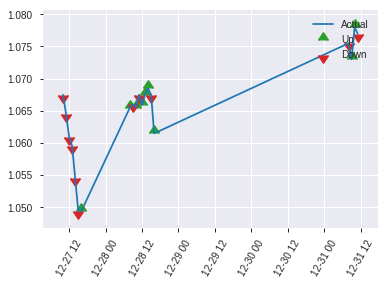


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18572580648120607
RMSE: 0.4309591703180315
LogLoss: 0.550338051510852
Mean Per-Class Error: 0.24239864864864868
AUC: 0.8047779922779923
pr_auc: 0.7662277638260384
Gini: 0.6095559845559846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2825947403907776: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   51   0.4595   (51.0/111.0)
1      9    103  0.0804   (9.0/112.0)
Total  69   154  0.2691   (60.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282595     0.774436  153
max f2                       0.255082     0.873786  169
max f0point5                 0.417266     0.748355  123
max accuracy                 0.417266     0.757848  123
max precision                0.892771     1         0
max recall                   0.129917     1         208
max specificity              0.892771     1         0
max absolute_mcc             0.417266     0.518466  123
max min_per_class_accuracy   0.454385     0.738739  111
max mean_per_class_accuracy  0.417266     0.757601  123

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 45.17 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.845387           1.32738    1.32738            0.666667         0.868533  0.666667                    0.868533            0.0178571       0.0178571                  32.7381   32.7381
    2        0.0224215                   0.831509           1.99107    1.59286            1                0.833862  0.8                         0.854664            0.0178571       0.0357143                  99.1071   59.2857
    3        0.0313901                   0.815863           1.99107    1.70663            1                0.822667  0.857143                    0.845522            0.0178571       0.0535714                  99.1071   70.6633
    4        0.0403587                   0.809462           1.99107    1.76984            1                0.813913  0.888889                    0.838498            0.0178571       0.0714286                  99.1071   76.9841
    5        0.0538117                   0.796977           1.99107    1.82515            1                0.802424  0.916667                    0.829479            0.0267857       0.0982143                  99.1071   82.5149
    6        0.103139                    0.753472           1.81006    1.81793            0.909091         0.770554  0.913043                    0.801298            0.0892857       0.1875                     81.0065   81.7935
    7        0.152466                    0.722491           1.44805    1.69827            0.727273         0.739168  0.852941                    0.781197            0.0714286       0.258929                   44.8052   69.8267
    8        0.201794                    0.678303           1.26705    1.59286            0.636364         0.70143   0.8                         0.761698            0.0625          0.321429                   26.7045   59.2857
    9        0.300448                    0.587106           1.35755    1.51559            0.681818         0.625464  0.761194                    0.716965            0.133929        0.455357                   35.7549   51.5592
    10       0.399103                    0.526363           1.53856    1.52127            0.772727         0.55382   0.764045                    0.676637            0.151786        0.607143                   53.8555   52.1268
    11       0.502242                    0.454385           1.29852    1.47553            0.652174         0.495818  0.741071                    0.639504            0.133929        0.741071                   29.8525   47.5526
    12       0.600897                    0.374093           0.905032   1.38186            0.454545         0.413369  0.69403                     0.602378            0.0892857       0.830357                   -9.49675  38.1863
    13       0.699552                    0.277899           0.905032   1.31462            0.454545         0.326762  0.660256                    0.563509            0.0892857       0.919643                   -9.49675  31.4618
    14       0.798206                    0.220803           0.543019   1.21925            0.272727         0.25509   0.61236                     0.52539             0.0535714       0.973214                   -45.6981  21.9252
    15       0.896861                    0.158794           0.181006   1.10504            0.0909091        0.194069  0.555                       0.488944            0.0178571       0.991071                   -81.8994  10.5045
    16       1                           0.0923135          0.0865683  1                  0.0434783        0.128016  0.502242                   

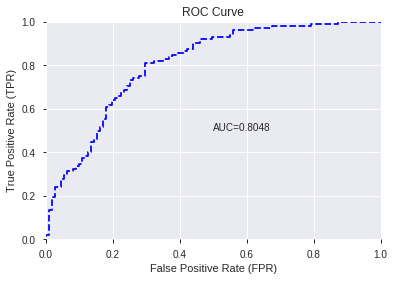

This function is available for GLM models only


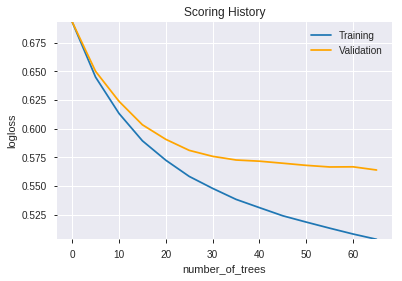

--2019-08-27 14:25:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_142449_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_142449_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'ULTOSC',
 'TRANGE',
 'hour',
 'CCI_8',
 'ADOSC',
 'WILLR_8',
 'CORREL_24',
 'STOCHRSI_fastd',
 'SUB',
 'PLUS_DI_12',
 'aroonup_8',
 'MINUS_DI_8',
 'AD',
 'BETA_12',
 'PLUS_DM_12',
 'BETA_8',
 'aroonup_14',
 'SAREXT',
 'CORREL_14',
 'WILLR_20',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'WILLR_14',
 'Volume',
 'OBV',
 'CORREL_12',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'CCI_12',
 'WILLR_12',
 'AROONOSC_14',
 'CDLSPINNINGTOP']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_142523_model_1  0.764559  0.59006              0.283261  0.451409  0.20377

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.386984           1.000000  3.446596e-02
1           CDLCLOSINGMARUBOZU             0.246825           0.637818  2.198301e-02
2                       ULTOSC             0.200082           0.517030  1.781995e-02
3                          SUB             0.163099           0.421463  1.452613e-02
4                    CDLHAMMER             0.156067           0.403290  1.389978e-02
...                        ...                  ...                ...           ...
1033                    T3_8_6             0.000057           0.000146  5.044044e-06
1034  BBANDS_middleband_12_5_5             0.000051           0.000131  4.531932e-06
1035                    T3_8_2             0.000042           0.000109  3.751535e-06
1036                 MAVP_20_1             0.000014           0.000036  1.249510e-06
1037           MACDFIX_hist_14             0.000007           0.000018  6.108620e-07

[1038 rows x 4 columns]

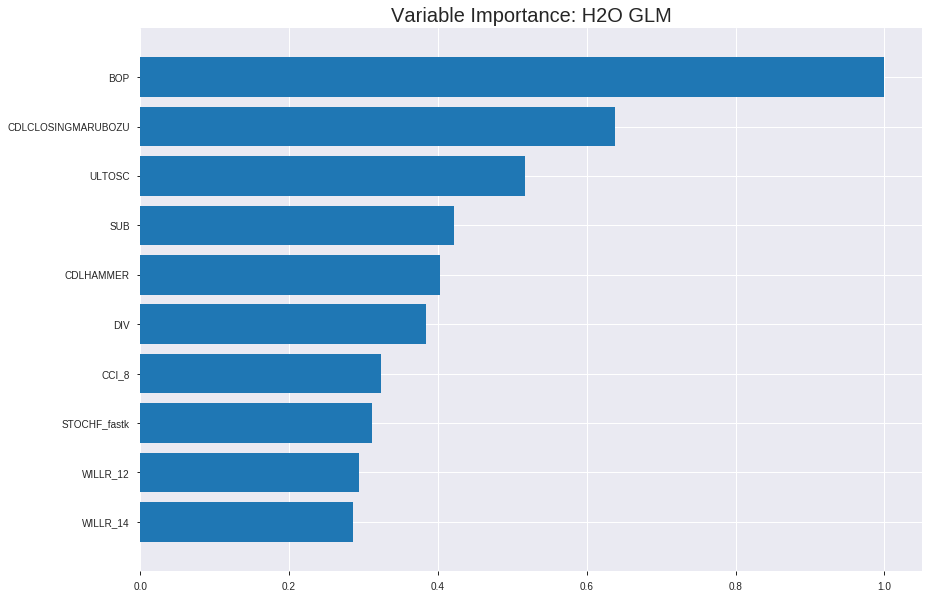

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_142523_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17196969619842795
RMSE: 0.4146922909802254
LogLoss: 0.518339540967966
Null degrees of freedom: 1555
Residual degrees of freedom: 517
Null deviance: 2156.8657950370343
Residual deviance: 1613.0726514923101
AIC: 3691.07265149231
AUC: 0.8281750090465513
pr_auc: 0.8253984377807736
Gini: 0.6563500180931026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48500286322934977: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      543  226  0.2939   (226.0/769.0)
1      162  625  0.2058   (162.0/787.0)
Total  705  851  0.2494   (388.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485003     0.763126  204
max f2                       0.271965     0.860338  299
max f0point5                 0.624321     0.765054  140
max accuracy                 0.520157     0.755784  189
max precision                0.981315     1         0
max recall                   0.0749906    1         381
max specificity              0.981315     1         0
max absolute_mcc             0.520157     0.51148   189
max min_per_class_accuracy   0.525433     0.754765  187
max mean_per_class_accuracy  0.520157     0.755722  189

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.923099           1.85356   1.85356            0.9375           0.943331  0.9375                      0.943331            0.0190597       0.0190597                  85.3558   85.3558
    2        0.0205656                   0.913408           1.85356   1.85356            0.9375           0.917859  0.9375                      0.930595            0.0190597       0.0381194                  85.3558   85.3558
    3        0.0302057                   0.89623            1.84532   1.85093            0.933333         0.90588   0.93617                     0.922707            0.0177891       0.0559085                  84.532    85.0929
    4        0.0404884                   0.882651           1.85356   1.8516             0.9375           0.889597  0.936508                    0.914298            0.0190597       0.0749682                  85.3558   85.1596
    5        0.0501285                   0.867979           1.84532   1.85039            0.933333         0.873537  0.935897                    0.906459            0.0177891       0.0927573                  84.532    85.0389
    6        0.100257                    0.813369           1.85039   1.85039            0.935897         0.83926   0.935897                    0.87286             0.0927573       0.185515                   85.0389   85.0389
    7        0.150386                    0.772971           1.77435   1.82504            0.897436         0.791638  0.923077                    0.845786            0.0889454       0.27446                    77.4346   82.5042
    8        0.200514                    0.736247           1.72365   1.79969            0.871795         0.755782  0.910256                    0.823285            0.0864041       0.360864                   72.365    79.9694
    9        0.300129                    0.666262           1.51792   1.70617            0.767742         0.700924  0.862955                    0.782673            0.151207        0.512071                   51.7924   70.6173
    10       0.400386                    0.591471           1.17867   1.57409            0.596154         0.629589  0.796148                    0.744341            0.11817         0.630241                   17.8673   57.4086
    11       0.5                         0.526631           1.21179   1.50191            0.612903         0.558686  0.75964                     0.707353            0.120712        0.750953                   21.1788   50.1906
    12       0.600257                    0.446259           0.760434  1.37806            0.384615         0.483735  0.697002                    0.670003            0.0762389       0.827192                   -23.9566  37.8063
    13       0.699871                    0.364991           0.714317  1.28359            0.36129          0.405876  0.649219                    0.632409            0.0711563       0.898348                   -28.5683  28.359
    14       0.800129                    0.263788           0.595673  1.19739            0.301282         0.317814  0.605622                    0.59299             0.0597205       0.958069                   -40.4327  19.7393
    15       0.899743                    0.163207           0.255113  1.09307            0.129032         0.212283  0.552857                    0.55084             0.025413        0.983482                   -74.4887  9.30695
    16       1                           0.0146979          0.164761  1                  0.0833333        0.101432  0.505784                    0.505784          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1856621688021222
RMSE: 0.43088533138425844
LogLoss: 0.5584087144137981
Null degrees of freedom: 444
Residual degrees of freedom: -594
Null deviance: 616.9374079624531
Residual deviance: 496.9837558282803
AIC: 2574.98375582828
AUC: 0.7985294711752111
pr_auc: 0.7955179030178986
Gini: 0.5970589423504222
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36015276116865674: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      138  84   0.3784   (84.0/222.0)
1      38   185  0.1704   (38.0/223.0)
Total  176  269  0.2742   (122.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360153     0.752033  243
max f2                       0.176169     0.844622  323
max f0point5                 0.483109     0.74318   191
max accuracy                 0.483109     0.737079  191
max precision                0.930647     1         0
max recall                   0.0331368    1         392
max specificity              0.930647     1         0
max absolute_mcc             0.483109     0.475035  191
max min_per_class_accuracy   0.467129     0.730942  202
max mean_per_class_accuracy  0.483109     0.737143  191

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.910853           1.99552   1.99552            1                0.918766  1                           0.918766            0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.895834           1.49664   1.77379            0.75             0.902496  0.888889                    0.911535            0.0134529       0.0358744                  49.6637   77.3792
    3        0.0314607                   0.870238           1.99552   1.85298            1                0.885093  0.928571                    0.902092            0.0224215       0.058296                   99.5516   85.2979
    4        0.0404494                   0.862613           1.99552   1.88465            1                0.865399  0.944444                    0.893938            0.0179372       0.0762332                  99.5516   88.4654
    5        0.0516854                   0.847738           1.59641   1.82199            0.8              0.854627  0.913043                    0.885392            0.0179372       0.0941704                  59.6413   82.1993
    6        0.101124                    0.795681           1.90481   1.86248            0.954545         0.818028  0.933333                    0.852458            0.0941704       0.188341                   90.481    86.2481
    7        0.150562                    0.750439           1.90481   1.87638            0.954545         0.775649  0.940299                    0.827238            0.0941704       0.282511                   90.481    87.638
    8        0.2                         0.717049           1.36058   1.74888            0.681818         0.735173  0.876404                    0.80448             0.0672646       0.349776                   36.0579   74.8879
    9        0.301124                    0.626006           1.41903   1.63811            0.711111         0.670901  0.820896                    0.759621            0.143498        0.493274                   41.9033   63.811
    10       0.4                         0.555935           1.13382   1.51345            0.568182         0.596437  0.758427                    0.719284            0.112108        0.605381                   13.3816   51.3453
    11       0.501124                    0.460815           1.24165   1.45861            0.622222         0.50267   0.730942                    0.675572            0.125561        0.730942                   24.1654   45.8606
    12       0.6                         0.361056           0.907053  1.36771            0.454545         0.408024  0.685393                    0.631482            0.0896861       0.820628                   -9.29474  36.7713
    13       0.698876                    0.267369           0.680289  1.27046            0.340909         0.320015  0.636656                    0.587416            0.0672646       0.887892                   -31.9711  27.0457
    14       0.8                         0.196483           0.443448  1.16592            0.222222         0.235361  0.58427                     0.542915            0.044843        0.932735                   -55.6552  16.5919
    15       0.898876                    0.0987888          0.362821  1.07758            0.181818         0.145367  0.54                        0.499184            0.0358744       0.96861                    -63.7179  7.75785
    16       1                           0.00558276         0.310414  1                  0.155556         0.056789  0.501124                    0.454448           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:25:27  0.000 sec   2            .21E2     1036          1.3501221704332167  1.3540850147249932
     2019-08-27 14:25:29  2.108 sec   4            .16E2     1039          1.3415685266790163  1.3460929226027503
     2019-08-27 14:25:31  4.271 sec   6            .11E2     1039          1.331311082429487   1.3364632668252545
     2019-08-27 14:25:33  6.347 sec   8            .83E1     1039          1.3190733814031272  1.3248791967075426
     2019-08-27 14:25:35  8.374 sec   10           .6E1      1039          1.3046437435654437  1.3111097993741547
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:26:06  39.099 sec  40           .51E-1    1039          1.0253452908824798  1.1179594095797873
     2019-08-27 14:26:08  41.107 sec  42           .37E-1    1039          1.0148789619563163  1.120757421775046
     2019-08-27 14:26:10  43.095 sec  44           .27E-1    1039          1.005196601676401   1.1246843881904651
     2019-08-27 14:26:12  45.122 sec  46           .2E-1     1039          0.9961721395784079  1.1297001879903352
     2019-08-27 14:26:14  47.310 sec  48           .14E-1    1039          0.9877023819106222  1.1358434448691004


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.7586206896551725)

('auc', 0.764559202059202)

('logloss', 0.5900597597759324)

('mean_per_class_error', 0.26954633204633205)

('rmse', 0.4514090299638031)

('mse', 0.2037701123328617)

glm prediction progress: |████████████████████████████████████████████████| 100%


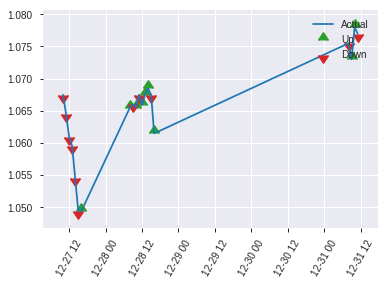


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2037701123328617
RMSE: 0.4514090299638031
LogLoss: 0.5900597597759324
Null degrees of freedom: 222
Residual degrees of freedom: -816
Null deviance: 309.15034943754756
Residual deviance: 263.1666528600659
AIC: 2341.166652860066
AUC: 0.764559202059202
pr_auc: 0.7154022570260392
Gini: 0.529118404118404
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31736763504533566: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   50   0.4505   (50.0/111.0)
1      13   99   0.1161   (13.0/112.0)
Total  74   149  0.2825   (63.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317368     0.758621  148
max f2                       0.110735     0.860465  196
max f0point5                 0.434968     0.718085  112
max accuracy                 0.351475     0.730942  135
max precision                0.922513     1         0
max recall                   0.0778088    1         205
max specificity              0.922513     1         0
max absolute_mcc             0.351475     0.472449  135
max min_per_class_accuracy   0.435008     0.711712  111
max mean_per_class_accuracy  0.351475     0.730454  135

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 42.69 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.89517            1.99107    1.99107            1                0.910569  1                           0.910569            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.855144           0.995536   1.59286            0.5              0.873538  0.8                         0.895756            0.00892857      0.0357143                  -0.446429  59.2857
    3        0.0313901                   0.835643           0.995536   1.42219            0.5              0.844529  0.714286                    0.88112             0.00892857      0.0446429                  -0.446429  42.2194
    4        0.0403587                   0.823768           1.99107    1.54861            1                0.829813  0.777778                    0.869718            0.0178571       0.0625                     99.1071    54.8611
    5        0.0538117                   0.80694            1.99107    1.65923            1                0.815853  0.833333                    0.856252            0.0267857       0.0892857                  99.1071    65.9226
    6        0.103139                    0.74136            1.62906    1.6448             0.818182         0.772576  0.826087                    0.816233            0.0803571       0.169643                   62.9058    64.4798
    7        0.152466                    0.693609           1.08604    1.46402            0.545455         0.72163   0.735294                    0.785626            0.0535714       0.223214                   8.6039     46.4023
    8        0.201794                    0.647275           1.26705    1.41587            0.636364         0.667716  0.711111                    0.756804            0.0625          0.285714                   26.7045    41.5873
    9        0.300448                    0.562186           1.53856    1.45616            0.772727         0.604641  0.731343                    0.70684             0.151786        0.4375                     53.8555    45.6157
    10       0.399103                    0.493241           1.26705    1.40941            0.636364         0.53399   0.707865                    0.664113            0.125           0.5625                     26.7045    40.941
    11       0.502242                    0.435008           1.47166    1.42219            0.73913          0.461639  0.714286                    0.622533            0.151786        0.714286                   47.1661    42.2194
    12       0.600897                    0.363042           1.08604    1.367              0.545455         0.395252  0.686567                    0.585218            0.107143        0.821429                   8.6039     36.7004
    13       0.699552                    0.297825           0.814529   1.28909            0.409091         0.325639  0.647436                    0.548611            0.0803571       0.901786                   -18.5471   28.9091
    14       0.798206                    0.176657           0.362013   1.17451            0.181818         0.235059  0.589888                    0.509857            0.0357143       0.9375                     -63.7987   17.4508
    15       0.896861                    0.0878845          0.543019   1.10504            0.272727         0.142499  0.555                       0.469448            0.0535714       0.991071                   -45.6981   10.5045
    16       1                           0.00862929         0.0865683  1                  0.0434783        0.056467  0.502242   

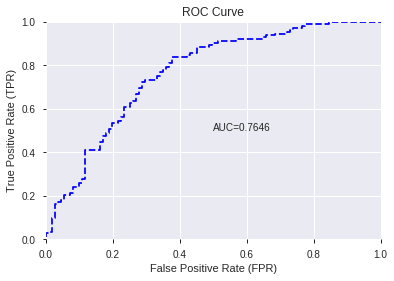

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


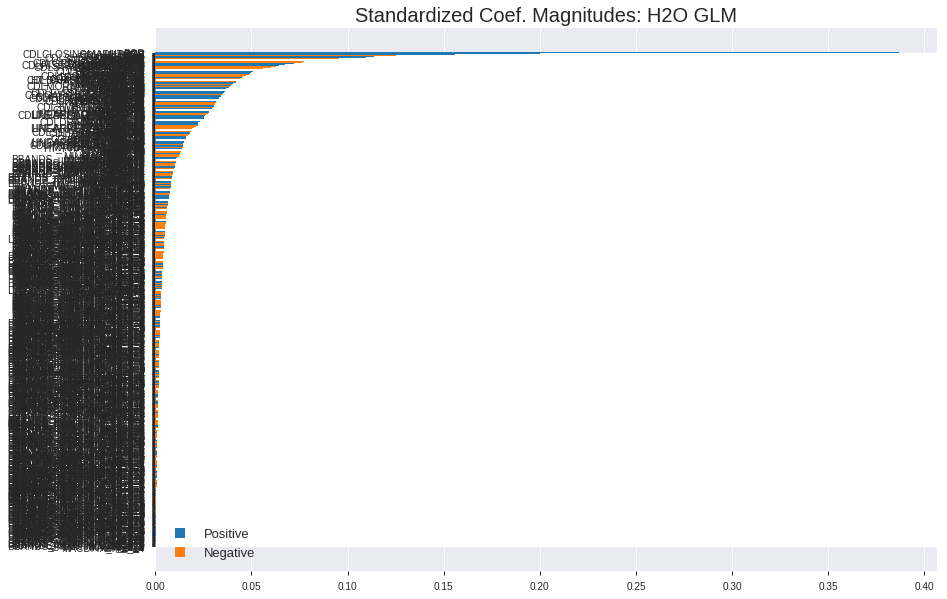

'log_likelihood'
--2019-08-27 14:26:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_142523_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_142523_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

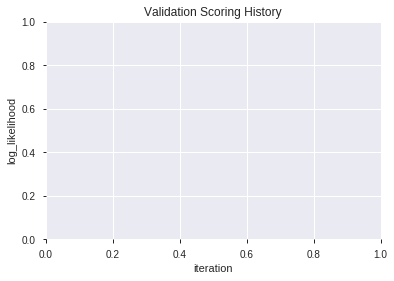

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_142644_model_7  0.810087  0.542549              0.247265  0.427068  0.182387
1  XGBoost_grid_1_AutoML_20190827_142644_model_3  0.805904  0.549343              0.256314  0.430728  0.185527
2               XGBoost_2_AutoML_20190827_142644  0.803089  0.549129              0.265444  0.430126  0.185008
3  XGBoost_grid_1_AutoML_20190827_142644_model_4  0.799550  0.555980              0.279078  0.433426  0.187858
4  XGBoost_grid_1_AutoML_20190827_142644_model_2  0.796573  0.557134              0.242761  0.434620  0.188895
5  XGBoost_grid_1_AutoML_20190827_142644_model_5  0.795528  0.552504              0.265002  0.432089  0.186701
6               XGBoost_1_AutoML_20190827_142644  0.793275  0.558789              0.260859  0.436147  0.190224
7               XGBoost_3_AutoML_20190827_142644  0.788127  0.558491              0.269868  0.435641  0.189783
8  XGBoost_grid_1_AutoML_20190827_142644_model_6  0.787725  0.559071              0.301641  0.436090  0.190174
9  XGBoost_grid_1_AutoML_20190827_142644_model_1  0.783864  0.572179              0.274453  0.442679  0.195964

variable  relative_importance  scaled_importance  percentage
0                        BOP          1671.249023           1.000000    0.145385
1               STOCHF_fastk           578.011353           0.345856    0.050282
2                        DIV           513.211792           0.307083    0.044645
3         CDLCLOSINGMARUBOZU           250.357269           0.149802    0.021779
4                     TRANGE           217.255432           0.129996    0.018899
..                       ...                  ...                ...         ...
387  BBANDS_upperband_14_3_3             1.367250           0.000818    0.000119
388  BBANDS_lowerband_14_3_3             1.335766           0.000799    0.000116
389  BBANDS_upperband_12_0_4             1.246557           0.000746    0.000108
390   LINEARREG_INTERCEPT_14             0.435912           0.000261    0.000038
391  BBANDS_upperband_20_3_4             0.374161           0.000224    0.000033

[392 rows x 4 columns]

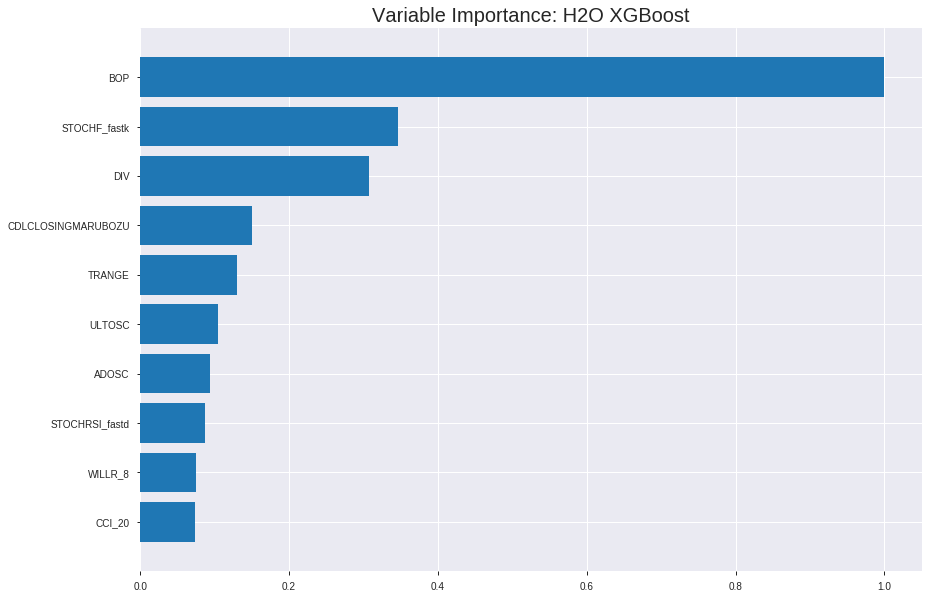

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_142644_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08211926687336393
RMSE: 0.2865645945914532
LogLoss: 0.3074095773586456
Mean Per-Class Error: 0.06166030241092657
AUC: 0.9836484617558076
pr_auc: 0.9829859519314527
Gini: 0.9672969235116151
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5103288094202677: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      724  45   0.0585   (45.0/769.0)
1      51   736  0.0648   (51.0/787.0)
Total  775  781  0.0617   (96.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510329     0.938776  205
max f2                       0.392722     0.95532   247
max f0point5                 0.60615      0.951017  169
max accuracy                 0.510329     0.938303  205
max precision                0.965061     1         0
max recall                   0.23056      1         309
max specificity              0.965061     1         0
max absolute_mcc             0.510329     0.876627  205
max min_per_class_accuracy   0.501617     0.936468  207
max mean_per_class_accuracy  0.510329     0.93834   205

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.949322           1.97713    1.97713            1                0.956821   1                           0.956821            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.939806           1.97713    1.97713            1                0.943927   1                           0.950374            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.931197           1.97713    1.97713            1                0.935591   1                           0.945656            0.0190597       0.0597205                  97.7128   97.7128
    4        0.0404884                   0.92481            1.97713    1.97713            1                0.927801   1                           0.941121            0.0203304       0.0800508                  97.7128   97.7128
    5        0.0501285                   0.916608           1.97713    1.97713            1                0.91954    1                           0.936971            0.0190597       0.0991105                  97.7128   97.7128
    6        0.100257                    0.883927           1.97713    1.97713            1                0.901025   1                           0.918998            0.0991105       0.198221                   97.7128   97.7128
    7        0.150386                    0.850376           1.97713    1.97713            1                0.866972   1                           0.901656            0.0991105       0.297332                   97.7128   97.7128
    8        0.200514                    0.820545           1.97713    1.97713            1                0.835503   1                           0.885118            0.0991105       0.396442                   97.7128   97.7128
    9        0.300129                    0.747568           1.92611    1.96019            0.974194         0.787843   0.991435                    0.852832            0.191868        0.58831                    92.6106   96.0194
    10       0.400386                    0.645181           1.92643    1.95174            0.974359         0.702762   0.987159                    0.815254            0.193139        0.781449                   92.6433   95.174
    11       0.5                         0.512304           1.51792    1.86531            0.767742         0.582311   0.943445                    0.768845            0.151207        0.932656                   51.7924   86.5311
    12       0.600257                    0.360915           0.51963    1.64055            0.262821         0.433739   0.829764                    0.712875            0.0520966       0.984752                   -48.037   64.0551
    13       0.699871                    0.265691           0.127557   1.4252             0.0645161        0.308565   0.720845                    0.655328            0.0127065       0.997459                   -87.2443  42.5203
    14       0.800129                    0.186853           0.0253478  1.2498             0.0128205        0.222879   0.632129                    0.601142            0.0025413       1                          -97.4652  24.9799
    15       0.899743                    0.124169           0          1.11143            0                0.154081   0.562143                    0.551646            0               1                          -100      11.1429
    16       1                           0.0420003          0          1                  0                0.0928013  0.505784  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18650692515147707
RMSE: 0.4318644754451066
LogLoss: 0.5519303278131575
Mean Per-Class Error: 0.26737163172140754
AUC: 0.7971760998666828
pr_auc: 0.7805349004599185
Gini: 0.5943521997333656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3051755130290985: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  93   0.4189   (93.0/222.0)
1      29   194  0.13     (29.0/223.0)
Total  158  287  0.2742   (122.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305176     0.760784  261
max f2                       0.164131     0.852987  342
max f0point5                 0.56401      0.744081  151
max accuracy                 0.432645     0.732584  194
max precision                0.954247     1         0
max recall                   0.0737865    1         393
max specificity              0.954247     1         0
max absolute_mcc             0.305176     0.471271  261
max min_per_class_accuracy   0.417163     0.726457  201
max mean_per_class_accuracy  0.432645     0.732628  194

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 45.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.935416           1.99552   1.99552            1                0.941709  1                           0.941709            0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.930598           1.49664   1.77379            0.75             0.932902  0.888889                    0.937794            0.0134529       0.0358744                  49.6637   77.3792
    3        0.0314607                   0.917092           1.99552   1.85298            1                0.923638  0.928571                    0.932739            0.0224215       0.058296                   99.5516   85.2979
    4        0.0404494                   0.91036            1.99552   1.88465            1                0.912593  0.944444                    0.928262            0.0179372       0.0762332                  99.5516   88.4654
    5        0.0516854                   0.890609           1.59641   1.82199            0.8              0.896677  0.913043                    0.921396            0.0179372       0.0941704                  59.6413   82.1993
    6        0.101124                    0.815356           1.7234    1.77379            0.863636         0.860578  0.888889                    0.891662            0.0852018       0.179372                   72.34     77.3792
    7        0.150562                    0.777979           1.54199   1.69768            0.772727         0.793968  0.850746                    0.859583            0.0762332       0.255605                   54.1989   69.7678
    8        0.2                         0.729897           1.45128   1.63677            0.727273         0.747503  0.820225                    0.831878            0.0717489       0.327354                   45.1284   63.6771
    9        0.301124                    0.637116           1.50772   1.59343            0.755556         0.68707   0.798507                    0.783249            0.152466        0.479821                   50.7723   59.3434
    10       0.4                         0.531314           1.40593   1.54709            0.704545         0.585068  0.775281                    0.73426             0.139013        0.618834                   40.5932   54.7085
    11       0.501124                    0.413175           1.06428   1.44966            0.533333         0.46613   0.726457                    0.680153            0.107623        0.726457                   6.4275    44.9657
    12       0.6                         0.337989           0.952405  1.36771            0.477273         0.379105  0.685393                    0.630542            0.0941704       0.820628                   -4.75948  36.7713
    13       0.698876                    0.250966           0.680289  1.27046            0.340909         0.297389  0.636656                    0.583408            0.0672646       0.887892                   -31.9711  27.0457
    14       0.8                         0.196853           0.576482  1.18274            0.288889         0.221907  0.592697                    0.537713            0.058296        0.946188                   -42.3518  18.2735
    15       0.898876                    0.137829           0.317468  1.08756            0.159091         0.16529   0.545                       0.496746            0.0313901       0.977578                   -68.2532  8.75561
    16       1                           0.0470497          0.221724  1                  0.111111         0.101144  0.501124                    0.456741         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:27:39  35.171 sec  0                  0.5              0.693147            0.5             0                  1                0.494216                         0.5                0.693147              0.5               0                    1                  0.498876
    2019-08-27 14:27:40  36.301 sec  5                  0.462404         0.620159            0.882406        0.885814           1.97713          0.21401                          0.476708           0.647224              0.754888          0.757612             1.99552            0.314607
    2019-08-27 14:27:40  36.575 sec  10                 0.433366         0.565888            0.909288        0.915558           1.97713          0.170308                         0.462468           0.619217              0.774441          0.774407             1.99552            0.32809
    2019-08-27 14:27:40  36.846 sec  15                 0.411013         0.524773            0.927357        0.933085           1.97713          0.151028                         0.45079            0.596038              0.790904          0.787505             1.99552            0.289888
    2019-08-27 14:27:41  37.109 sec  20                 0.391277         0.488686            0.937154        0.942342           1.97713          0.137532                         0.44556            0.584672              0.785743          0.779885             1.99552            0.296629
    2019-08-27 14:27:41  37.389 sec  25                 0.374912         0.458727            0.943712        0.947768           1.97713          0.12982                          0.440208           0.572889              0.791944          0.782385             1.99552            0.289888
    2019-08-27 14:27:41  37.744 sec  30                 0.36084          0.433257            0.950727        0.953496           1.97713          0.114396                         0.437216           0.566127              0.794005          0.780005             1.99552            0.283146
    2019-08-27 14:27:42  38.010 sec  35                 0.347767         0.410053            0.957184        0.958544           1.97713          0.106684                         0.435438           0.562011              0.792853          0.778512             1.59641            0.289888
    2019-08-27 14:27:42  38.261 sec  40                 0.336653         0.390512            0.963144        0.962845           1.97713          0.0957584                        0.433941           0.558575              0.794005          0.780287             1.99552            0.28764
    2019-08-27 14:27:42  38.511 sec  45                 0.32614          0.37215             0.967051        0.967893           1.97713          0.0899743                        0.432252           0.554426              0.794146          0.781425             1.99552            0.283146
    2019-08-27 14:27:42  38.760 sec  50                 0.317578         0.357545            0.971381        0.971804           1.97713          0.0841902                        0.432685           0.554389              0.792692          0.780493             1.99552            0.27191
    2019-08-27 14:27:43  39.030 sec  55                 0.308815         0.343083            0.975398        0.975505           1.97713          0.0764781                        0.432082           0.552872              0.795439          0.78

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1671.2490234375        1.0                     0.1453846417187054
STOCHF_fastk             578.0113525390625      0.34585591041973074     0.050282137622669226
DIV                      513.2117919921875      0.30708277748853396     0.044645119583155445
CDLCLOSINGMARUBOZU       250.35726928710938     0.14980249249280836     0.021778981699635998
TRANGE                   217.25543212890625     0.12999584686789856     0.018899399621809122
---                      ---                    ---                     ---
BBANDS_upperband_14_3_3  1.3672504425048828     0.0008181009671991674   0.00011893931600597732
BBANDS_lowerband_14_3_3  1.3357658386230469     0.0007992620009886879   0.00011620041965311596
BBANDS_upperband_12_0_4  1.2465572357177734     0.0007458835985757518   0.00010844001974279437
LINEARREG_INTERCEPT_14   0.4359121322631836     0.00026083014927756246  3.792069780215487e-05
BBANDS_upperband_20_3_4  0.3741607666015625     0.00022388091861497207  3.254884714049236e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.784313725490196)

('auc', 0.8100868725868726)

('logloss', 0.542548743083489)

('mean_per_class_error', 0.24682271557271562)

('rmse', 0.42706781142832706)

('mse', 0.18238691555818112)

xgboost prediction progress: |████████████████████████████████████████████| 100%


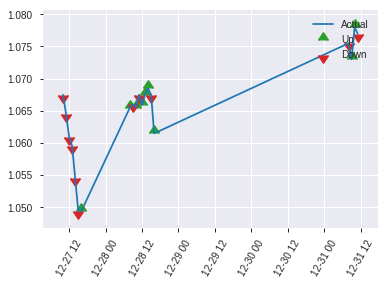


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18238691555818112
RMSE: 0.42706781142832706
LogLoss: 0.542548743083489
Mean Per-Class Error: 0.24682271557271562
AUC: 0.8100868725868726
pr_auc: 0.7761683132002051
Gini: 0.6201737451737452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32910844683647156: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   43   0.3874   (43.0/111.0)
1      12   100  0.1071   (12.0/112.0)
Total  80   143  0.2466   (55.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329108     0.784314  142
max f2                       0.179693     0.865079  181
max f0point5                 0.39962      0.746644  120
max accuracy                 0.39962      0.753363  120
max precision                0.940662     1         0
max recall                   0.10239      1         208
max specificity              0.940662     1         0
max absolute_mcc             0.329108     0.52693   142
max min_per_class_accuracy   0.420229     0.72973   111
max mean_per_class_accuracy  0.39962      0.753177  120

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 44.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.918037           1.99107    1.99107            1                0.927166   1                           0.927166            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.910626           0.995536   1.59286            0.5              0.914385   0.8                         0.922054            0.00892857      0.0357143                  -0.446429  59.2857
    3        0.0313901                   0.90378            1.99107    1.70663            1                0.906351   0.857143                    0.917567            0.0178571       0.0535714                  99.1071    70.6633
    4        0.0403587                   0.902833           1.99107    1.76984            1                0.90331    0.888889                    0.914399            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.885073           1.32738    1.65923            0.666667         0.892091   0.833333                    0.908822            0.0178571       0.0892857                  32.7381    65.9226
    6        0.103139                    0.809133           1.81006    1.73137            0.909091         0.845687   0.869565                    0.878627            0.0892857       0.178571                   81.0065    73.1366
    7        0.152466                    0.733548           1.81006    1.75683            0.909091         0.765928   0.882353                    0.842165            0.0892857       0.267857                   81.0065    75.6828
    8        0.201794                    0.691645           1.26705    1.6371             0.636364         0.705705   0.822222                    0.808809            0.0625          0.330357                   26.7045    63.7103
    9        0.300448                    0.591344           1.35755    1.54531            0.681818         0.649201   0.776119                    0.7564              0.133929        0.464286                   35.7549    54.5309
    10       0.399103                    0.518999           1.53856    1.54364            0.772727         0.561806   0.775281                    0.708298            0.151786        0.616071                   53.8555    54.364
    11       0.502242                    0.420229           1.12539    1.45775            0.565217         0.474452   0.732143                    0.660276            0.116071        0.732143                   12.5388    45.7749
    12       0.600897                    0.350754           1.08604    1.39672            0.545455         0.381829   0.701493                    0.614561            0.107143        0.839286                   8.6039     39.6722
    13       0.699552                    0.269147           0.814529   1.31462            0.409091         0.31451    0.660256                    0.572246            0.0803571       0.919643                   -18.5471   31.4618
    14       0.798206                    0.190772           0.452516   1.20807            0.227273         0.232338   0.606742                    0.530235            0.0446429       0.964286                   -54.7484   20.8066
    15       0.896861                    0.12063            0.0905032  1.08513            0.0454545        0.161538   0.545                       0.489678            0.00892857      0.973214                   -90.9497   8.51339
    16       1                           0.0683663          0.259705   1                  0.130435         0.09

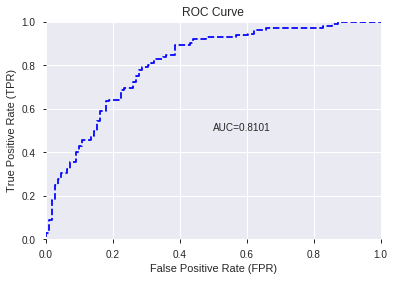

This function is available for GLM models only


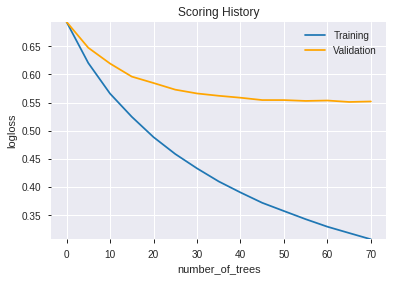

--2019-08-27 14:27:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_142644_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_142644_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_142754_model_8  0.788288  0.581718              0.265364  0.442989  0.196240
1  DeepLearning_grid_1_AutoML_20190827_142754_model_7  0.784588  0.642787              0.274292  0.466602  0.217718
2  DeepLearning_grid_1_AutoML_20190827_142754_model_9  0.780164  0.569781              0.256395  0.440196  0.193773
3  DeepLearning_grid_1_AutoML_20190827_142754_model_6  0.772442  0.580298              0.337757  0.444807  0.197854
4  DeepLearning_grid_1_AutoML_20190827_142754_model_3  0.770029  0.653582              0.260175  0.457597  0.209395
5  DeepLearning_grid_1_AutoML_20190827_142754_model_5  0.767375  0.597302              0.283181  0.453373  0.205547
6  DeepLearning_grid_1_AutoML_20190827_142754_model_2  0.766972  0.598034              0.319498  0.448368  0.201033
7               DeepLearning_1_AutoML_20190827_142754  0.752252  0.629550              0.328346  0.458667  0.210375
8  DeepLearning_grid_1_AutoML_20190827_142754_model_1  0.747587  0.869039              0.333132  0.496555  0.246567
9  DeepLearning_grid_1_AutoML_20190827_142754_model_4  0.735441  0.782911              0.342021  0.493325  0.243369

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.039050
1   CDLCLOSINGMARUBOZU             0.934352           0.934352    0.036487
2               ULTOSC             0.653304           0.653304    0.025512
3                 hour             0.634026           0.634026    0.024759
4                  SUB             0.632851           0.632851    0.024713
5                  DIV             0.606432           0.606432    0.023681
6                  OBV             0.602925           0.602925    0.023544
7           MINUS_DI_8             0.585832           0.585832    0.022877
8            CDLHAMMER             0.584119           0.584119    0.022810
9               TRANGE             0.569451           0.569451    0.022237
10              SAREXT             0.566294           0.566294    0.022114
11            WILLR_14             0.562409           0.562409    0.021962
12      STOCHRSI_fastd             0.548588           0.548588    0.021423
13           CORREL_12             0.539637           0.539637    0.021073
14          aroonup_14             0.528352           0.528352    0.020632
15               CCI_8             0.526103           0.526103    0.020544
16           CORREL_24             0.524777           0.524777    0.020493
17              CCI_12             0.518465           0.518465    0.020246
18        CDLSHORTLINE             0.515532           0.515532    0.020132
19             WILLR_8             0.507384           0.507384    0.019813
20      CDLSPINNINGTOP             0.506814           0.506814    0.019791
21      STOCHRSI_fastk             0.500961           0.500961    0.019563
22             BETA_12             0.498254           0.498254    0.019457
23            WILLR_12             0.495591           0.495591    0.019353
24         AROONOSC_14             0.495041           0.495041    0.019331
25           CORREL_14             0.486579           0.486579    0.019001
26                  AD             0.479867           0.479867    0.018739
27              BETA_8             0.478936           0.478936    0.018703
28         CDLMARUBOZU             0.471831           0.471831    0.018425
29        STOCHF_fastk             0.466133           0.466133    0.018203
30         CDLLONGLINE             0.460282           0.460282    0.017974
31     CDLSHOOTINGSTAR             0.459989           0.459989    0.017963
32           PLUS_DI_8             0.459471           0.459471    0.017942
33               ADOSC             0.458621           0.458621    0.017909
34           aroonup_8             0.457872           0.457872    0.017880
35            WILLR_20             0.454052           0.454052    0.017731
36         CDLHIGHWAVE             0.448833           0.448833    0.017527
37        CDLENGULFING             0.446560           0.446560    0.017438
38         CDLBELTHOLD             0.441735           0.441735    0.017250
39      is_month_start             0.436406           0.436406    0.017042
40          PLUS_DM_12             0.432804           0.432804    0.016901
41   CDLGRAVESTONEDOJI             0.421400           0.421400    0.016456
42          PLUS_DI_12             0.418941           0.418941    0.016360
43          AROONOSC_8             0.416217           0.416217    0.016253
44              Volume             0.415914           0.415914    0.016242
45           PLUS_DM_8             0.404509           0.404509    0.015796
46           CDLTAKURI             0.399287           0.399287    0.015592
47         CDL3OUTSIDE             0.389573           0.389573    0.015213
48    CDLDRAGONFLYDOJI             0.384772           0.384772    0.015025
49       CDLHANGINGMAN             0.379941           0.379941    0.014837

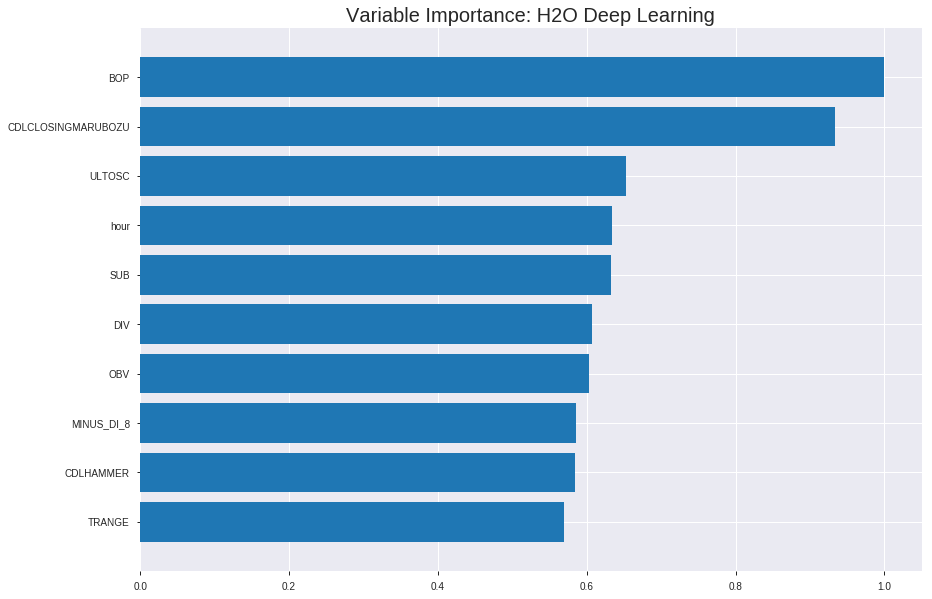

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_142754_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1690413631121772
RMSE: 0.41114640106922645
LogLoss: 0.5076814441806724
Mean Per-Class Error: 0.24421888192887342
AUC: 0.8364631371622414
pr_auc: 0.8452040717372726
Gini: 0.6729262743244828
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3754519629472082: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      497  272  0.3537   (272.0/769.0)
1      120  667  0.1525   (120.0/787.0)
Total  617  939  0.2519   (392.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375452     0.772885  246
max f2                       0.233625     0.856403  320
max f0point5                 0.508793     0.784066  179
max accuracy                 0.430722     0.755784  218
max precision                0.991905     1         0
max recall                   0.11283      1         370
max specificity              0.991905     1         0
max absolute_mcc             0.508793     0.517449  179
max min_per_class_accuracy   0.430722     0.755527  218
max mean_per_class_accuracy  0.430722     0.755781  218

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 47.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.980628           1.97713   1.97713            1                0.986011  1                           0.986011            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.973149           1.97713   1.97713            1                0.976972  1                           0.981491            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.962601           1.97713   1.97713            1                0.968466  1                           0.977334            0.0190597       0.0597205                  97.7128   97.7128
    4        0.0404884                   0.953872           1.85356   1.94575            0.9375           0.958003  0.984127                    0.972425            0.0190597       0.0787802                  85.3558   94.5745
    5        0.0501285                   0.941524           1.84532   1.92643            0.933333         0.947496  0.974359                    0.967631            0.0177891       0.0965693                  84.532    92.6433
    6        0.100257                    0.863889           1.85039   1.88841            0.935897         0.900365  0.955128                    0.933998            0.0927573       0.189327                   85.0389   88.8411
    7        0.150386                    0.788492           1.85039   1.87574            0.935897         0.821285  0.948718                    0.896427            0.0927573       0.282084                   85.0389   87.5737
    8        0.200514                    0.723585           1.72365   1.83772            0.871795         0.75711   0.929487                    0.861598            0.0864041       0.368488                   72.365    83.7715
    9        0.300129                    0.599741           1.44139   1.70617            0.729032         0.663619  0.862955                    0.795887            0.143583        0.512071                   44.139    70.6173
    10       0.400386                    0.495269           1.34343   1.61534            0.679487         0.541525  0.817014                    0.732195            0.134689        0.64676                    34.3433   61.5342
    11       0.5                         0.43162            1.04596   1.50191            0.529032         0.462806  0.75964                     0.678525            0.104193        0.750953                   4.59647   50.1906
    12       0.600257                    0.377164           0.912521  1.40346            0.461538         0.404351  0.70985                     0.632732            0.0914867       0.84244                    -8.74792  40.3465
    13       0.699871                    0.324213           0.574005  1.28541            0.290323         0.349989  0.650138                    0.592488            0.0571792       0.899619                   -42.5995  28.5406
    14       0.800129                    0.256931           0.532304  1.19104            0.269231         0.290203  0.60241                     0.554611            0.0533672       0.952986                   -46.7696  19.1041
    15       0.899743                    0.1674             0.29338   1.09166            0.148387         0.214885  0.552143                    0.516999            0.0292249       0.982211                   -70.662   9.16573
    16       1                           0.0202887          0.177435  1                  0.0897436        0.108762  0.505784                    0.47607          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17834036705167164
RMSE: 0.4223036431901478
LogLoss: 0.5288365563219545
Mean Per-Class Error: 0.24933341413162036
AUC: 0.8143760352280532
pr_auc: 0.810121620226418
Gini: 0.6287520704561065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.316263327760873: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  100  0.4505   (100.0/222.0)
1      26   197  0.1166   (26.0/223.0)
Total  148  297  0.2831   (126.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316263     0.757692  267
max f2                       0.165864     0.855365  352
max f0point5                 0.446974     0.761397  188
max accuracy                 0.446974     0.750562  188
max precision                0.98828      1         0
max recall                   0.0762929    1         386
max specificity              0.98828      1         0
max absolute_mcc             0.446974     0.503473  188
max min_per_class_accuracy   0.415706     0.730942  202
max mean_per_class_accuracy  0.446974     0.750667  188

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 46.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.985227           1.99552   1.99552            1                0.98672    1                           0.98672             0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.97633            1.99552   1.99552            1                0.983835   1                           0.985438            0.0179372       0.0403587                  99.5516   99.5516
    3        0.0314607                   0.96718            1.59641   1.85298            0.8              0.970559   0.928571                    0.980124            0.0179372       0.058296                   59.6413   85.2979
    4        0.0404494                   0.962746           1.99552   1.88465            1                0.964997   0.944444                    0.976762            0.0179372       0.0762332                  99.5516   88.4654
    5        0.0516854                   0.949994           1.99552   1.90875            1                0.956886   0.956522                    0.972442            0.0224215       0.0986547                  99.5516   90.8754
    6        0.101124                    0.862846           1.81411   1.86248            0.909091         0.91513    0.933333                    0.944423            0.0896861       0.188341                   81.4105   86.2481
    7        0.150562                    0.799137           1.7234    1.81681            0.863636         0.823357   0.910448                    0.90467             0.0852018       0.273543                   72.34     81.6813
    8        0.2                         0.735675           1.63269   1.7713             0.818182         0.765848   0.88764                     0.870354            0.0807175       0.35426                    63.2695   77.13
    9        0.301124                    0.616706           1.33034   1.62322            0.666667         0.674828   0.813433                    0.804693            0.134529        0.488789                   33.0344   62.3218
    10       0.4                         0.477774           1.45128   1.58072            0.727273         0.546424   0.792135                    0.740851            0.143498        0.632287                   45.1284   58.0717
    11       0.501124                    0.406536           0.975585  1.45861            0.488889         0.444688   0.730942                    0.681087            0.0986547       0.730942                   -2.44145  45.8606
    12       0.6                         0.351154           0.8617    1.36024            0.431818         0.379187   0.681648                    0.631336            0.0852018       0.816143                   -13.83    36.0239
    13       0.698876                    0.296866           0.8617    1.28971            0.431818         0.326601   0.646302                    0.588222            0.0852018       0.901345                   -13.83    28.9706
    14       0.8                         0.223767           0.487793  1.18834            0.244444         0.259066   0.595506                    0.546615            0.0493274       0.950673                   -51.2207  18.8341
    15       0.898876                    0.13462            0.362821  1.09753            0.181818         0.186346   0.55                        0.506986            0.0358744       0.986547                   -63.7179  9.75336
    16       1                           0.0237894          0.133034  1                  0.0666667        0.0857169  0.501124                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:33:04  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:33:05  1 min  7.866 sec  620 obs/sec       0.592545  1             922        0.487526         0.815226            0.0491464      0.766002        0.762698           1.97713          0.318766                         0.495685           0.845149              0.0171821        0.766796          0.734671             1.59641            0.330337
    2019-08-27 14:33:15  1 min 17.292 sec  1026 obs/sec      6.61825   11            10298      0.417735         0.522293            0.301898       0.823434        0.820897           1.97713          0.264781                         0.424711           0.541778              0.278478         0.809245          0.797015             1.99552            0.283146
    2019-08-27 14:33:24  1 min 26.647 sec  1165 obs/sec      13.8593   23            21565      0.411146         0.507681            0.323744       0.836463        0.845204           1.97713          0.251928                         0.422304           0.528837              0.286635         0.814376          0.810122             1.99552            0.283146
    2019-08-27 14:33:33  1 min 35.984 sec  1221 obs/sec      21.1048   35            32839      0.412431         0.510789            0.319511       0.843291        0.853332           1.97713          0.247429                         0.427775           0.542472              0.268029         0.805135          0.799925             1.99552            0.285393
    2019-08-27 14:33:43  1 min 45.683 sec  1288 obs/sec      29.5578   49            45992      0.39779          0.476601            0.366967       0.857739        0.869551           1.97713          0.233933                         0.428429           0.550236              0.265789         0.80975           0.803634             1.99552            0.283146
    2019-08-27 14:33:52  1 min 54.726 sec  1326 obs/sec      37.3663   62            58142      0.387053         0.452502            0.400681       0.871234        0.861889           1.97713          0.22108                          0.424276           0.537738              0.279958         0.809407          0.80711              1.99552            0.247191
    2019-08-27 14:34:02  2 min  4.334 sec  1356 obs/sec      45.8181   76            71293      0.374316         0.427321            0.439476       0.891826        0.883609           1.97713          0.19473                          0.429892           0.551268              0.260769         0.800661          0.801166             1.99552            0.262921
    2019-08-27 14:34:03  2 min  5.310 sec  1355 obs/sec      45.8181   76            71293      0.411146         0.507681            0.323744       0.836463        0.845204           1.97713          0.251928                         0.422304           0.528837              0.286635         0.814376          0.810122             1.99552            0.283146

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.039050265772251826
CDLCLOSINGMARUBOZU  0.9343523979187012     0.9343523979187012   0.03648670946366608
ULTOSC              0.6533036231994629     0.6533036231994629   0.02551168011591409
hour                0.6340261697769165     0.6340261697769165   0.024758890436351447
SUB                 0.6328510642051697     0.6328510642051697   0.02471300225146428
---                 ---                    ---                  ---
PLUS_DM_8           0.4045092761516571     0.4045092761516571   0.01579619474106342
CDLTAKURI           0.39928746223449707    0.39928746223449707  0.015592281519785076
CDL3OUTSIDE         0.3895733952522278     0.3895733952522278   0.015212944622398004
CDLDRAGONFLYDOJI    0.38477247953414917    0.38477247953414917  0.015025467587656853
CDLHANGINGMAN       0.3799414038658142     0.3799414038658142   0.014836812798842513


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.7756653992395437)

('auc', 0.7882882882882883)

('logloss', 0.5817182582553629)

('mean_per_class_error', 0.25156853281853286)

('rmse', 0.442989454915747)

('mse', 0.19623965716655062)

deeplearning prediction progress: |███████████████████████████████████████| 100%


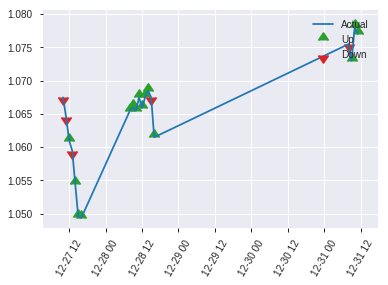


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19623965716655062
RMSE: 0.442989454915747
LogLoss: 0.5817182582553629
Mean Per-Class Error: 0.25156853281853286
AUC: 0.7882882882882883
pr_auc: 0.7383577653844028
Gini: 0.5765765765765767
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33940339215827153: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   49   0.4414   (49.0/111.0)
1      10   102  0.0893   (10.0/112.0)
Total  72   151  0.2646   (59.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339403     0.775665  150
max f2                       0.214985     0.856698  193
max f0point5                 0.417058     0.738255  120
max accuracy                 0.375841     0.748879  133
max precision                0.979883     1         0
max recall                   0.148274     1         205
max specificity              0.979883     1         0
max absolute_mcc             0.375841     0.507294  133
max min_per_class_accuracy   0.450467     0.723214  110
max mean_per_class_accuracy  0.375841     0.748431  133

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 46.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.975835           1.99107   1.99107            1                0.977984  1                           0.977984            0.0267857       0.0267857                  99.1071   99.1071
    2        0.0224215                   0.967242           0         1.19464            0                0.972212  0.6                         0.975675            0               0.0267857                  -100      19.4643
    3        0.0313901                   0.959869           1.99107   1.42219            1                0.964692  0.714286                    0.972537            0.0178571       0.0446429                  99.1071   42.2194
    4        0.0403587                   0.951532           1.99107   1.54861            1                0.955157  0.777778                    0.968675            0.0178571       0.0625                     99.1071   54.8611
    5        0.0538117                   0.939143           1.99107   1.65923            1                0.946983  0.833333                    0.963252            0.0267857       0.0892857                  99.1071   65.9226
    6        0.103139                    0.806239           1.44805   1.55823            0.727273         0.856133  0.782609                    0.912021            0.0714286       0.160714                   44.8052   55.823
    7        0.152466                    0.708373           1.81006   1.63971            0.909091         0.75857   0.823529                    0.862375            0.0892857       0.25                       81.0065   63.9706
    8        0.201794                    0.615888           1.62906   1.6371             0.818182         0.649004  0.822222                    0.810218            0.0803571       0.330357                   62.9058   63.7103
    9        0.300448                    0.562196           1.17654   1.48587            0.590909         0.589278  0.746269                    0.73767             0.116071        0.446429                   17.6542   48.5874
    10       0.399103                    0.484342           1.35755   1.45415            0.681818         0.52348   0.730337                    0.684724            0.133929        0.580357                   35.7549   45.4153
    11       0.502242                    0.447751           1.38509   1.43997            0.695652         0.465914  0.723214                    0.63979             0.142857        0.723214                   38.5093   43.9971
    12       0.600897                    0.375706           1.26705   1.41158            0.636364         0.408517  0.708955                    0.60182             0.125           0.848214                   26.7045   41.158
    13       0.699552                    0.336999           0.633523  1.30185            0.318182         0.353266  0.653846                    0.566767            0.0625          0.910714                   -36.6477  30.1854
    14       0.798206                    0.2819             0.362013  1.18569            0.181818         0.311998  0.595506                    0.535279            0.0357143       0.946429                   -63.7987  18.5694
    15       0.896861                    0.176579           0.362013  1.09509            0.181818         0.238326  0.55                        0.502614            0.0357143       0.982143                   -63.7987  9.50893
    16       1                           0.0353652          0.173137  1                  0.0869565        0.116104  0.502242                    0.46275            

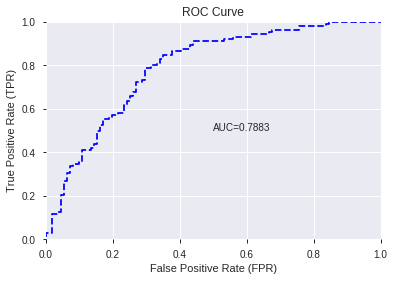

This function is available for GLM models only


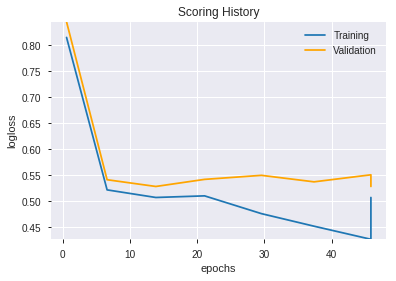

--2019-08-27 14:35:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_142754_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_142754_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'hour',
 'SUB',
 'DIV',
 'OBV',
 'MINUS_DI_8',
 'CDLHAMMER',
 'TRANGE',
 'SAREXT',
 'WILLR_14',
 'STOCHRSI_fastd',
 'CORREL_12',
 'aroonup_14',
 'CCI_8',
 'CORREL_24',
 'CCI_12',
 'CDLSHORTLINE',
 'WILLR_8',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'BETA_12',
 'WILLR_12',
 'AROONOSC_14',
 'CORREL_14',
 'AD',
 'BETA_8',
 'CDLMARUBOZU',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'CDLSHOOTINGSTAR',
 'PLUS_DI_8',
 'ADOSC',
 'aroonup_8',
 'WILLR_20',
 'CDLHIGHWAVE',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'is_month_start',
 'PLUS_DM_12',
 'CDLGRAVESTONEDOJI',
 'PLUS_DI_12',
 'AROONOSC_8',
 'Volume',
 'PLUS_DM_8',
 'CDLTAKURI',
 'CDL3OUTSIDE',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_143514_model_1  0.782819  0.57107              0.265404  0.440478  0.194021

variable  relative_importance  scaled_importance  percentage
0                  SUB             2.091614           1.000000    0.183300
1                  DIV             1.515234           0.724433    0.132789
2                  BOP             0.823048           0.393499    0.072128
3   CDLCLOSINGMARUBOZU             0.494237           0.236295    0.043313
4               ULTOSC             0.464848           0.222244    0.040737
5           MINUS_DI_8             0.455329           0.217693    0.039903
6             WILLR_14             0.432897           0.206968    0.037937
7                CCI_8             0.365406           0.174701    0.032023
8            CDLTAKURI             0.339747           0.162433    0.029774
9            PLUS_DI_8             0.339280           0.162209    0.029733
10    CDLDRAGONFLYDOJI             0.301160           0.143985    0.026392
11        STOCHF_fastk             0.291710           0.139467    0.025564
12           PLUS_DM_8             0.254797           0.121818    0.022329
13           CDLHAMMER             0.237916           0.113748    0.020850
14           aroonup_8             0.214313           0.102463    0.018781
15          AROONOSC_8             0.196630           0.094009    0.017232
16            WILLR_12             0.176049           0.084169    0.015428
17           CORREL_24             0.167035           0.079860    0.014638
18              CCI_12             0.166178           0.079450    0.014563
19         CDLLONGLINE             0.163536           0.078187    0.014332
20             BETA_12             0.155465           0.074328    0.013624
21     CDLSHOOTINGSTAR             0.150290           0.071854    0.013171
22         CDLMARUBOZU             0.144421           0.069047    0.012656
23                hour             0.132228           0.063218    0.011588
24         AROONOSC_14             0.127578           0.060995    0.011180
25              BETA_8             0.109716           0.052455    0.009615
26           CORREL_12             0.104831           0.050119    0.009187
27      STOCHRSI_fastd             0.082269           0.039333    0.007210
28          PLUS_DM_12             0.080861           0.038659    0.007086
29   CDLGRAVESTONEDOJI             0.077811           0.037201    0.006819
30              SAREXT             0.077373           0.036992    0.006781
31      CDLSPINNINGTOP             0.069315           0.033139    0.006074
32         CDL3OUTSIDE             0.067577           0.032308    0.005922
33          aroonup_14             0.066635           0.031858    0.005840
34              Volume             0.058027           0.027743    0.005085
35              TRANGE             0.057595           0.027536    0.005047
36          PLUS_DI_12             0.054101           0.025866    0.004741
37      is_month_start             0.040430           0.019329    0.003543
38         CDLBELTHOLD             0.038452           0.018384    0.003370
39       CDLHANGINGMAN             0.034011           0.016261    0.002981
40                 OBV             0.032025           0.015311    0.002807
41        CDLSHORTLINE             0.030064           0.014373    0.002635
42             WILLR_8             0.021455           0.010258    0.001880
43                  AD             0.020801           0.009945    0.001823
44        CDLENGULFING             0.020420           0.009763    0.001789
45      STOCHRSI_fastk             0.017169           0.008209    0.001505
46            WILLR_20             0.014613           0.006986    0.001281
47               ADOSC             0.012936           0.006185    0.001134
48         CDLHIGHWAVE             0.012812           0.006125    0.001123
49           CORREL_14             0.008632           0.004127    0.000756

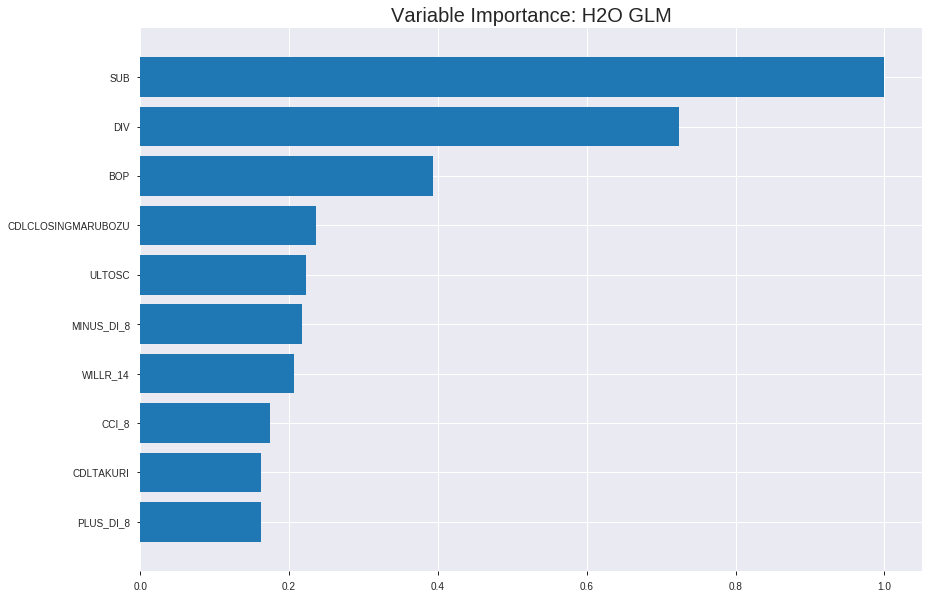

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_143514_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1735715919493564
RMSE: 0.4166192409735254
LogLoss: 0.5201621433886376
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2156.8657950370343
Residual deviance: 1618.7445902254403
AIC: 1720.7445902254403
AUC: 0.8196943835374246
pr_auc: 0.822653824393931
Gini: 0.6393887670748493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3904308203963759: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      459  310  0.4031   (310.0/769.0)
1      110  677  0.1398   (110.0/787.0)
Total  569  987  0.2699   (420.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390431     0.763247  253
max f2                       0.154932     0.854882  343
max f0point5                 0.664104     0.759253  134
max accuracy                 0.479982     0.743573  218
max precision                0.984991     1         0
max recall                   0.0198354    1         393
max specificity              0.984991     1         0
max absolute_mcc             0.479982     0.489125  218
max min_per_class_accuracy   0.526228     0.737321  196
max mean_per_class_accuracy  0.479982     0.742937  218

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.963505           1.97713   1.97713            1                0.972721   1                           0.972721            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.950249           1.97713   1.97713            1                0.95843    1                           0.965576            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.936358           1.84532   1.93506            0.933333         0.943106   0.978723                    0.958405            0.0177891       0.0584498                  84.532    93.5062
    4        0.0404884                   0.930653           1.60642   1.8516             0.8125           0.933728   0.936508                    0.952138            0.0165184       0.0749682                  60.6417   85.1596
    5        0.0501285                   0.915985           1.84532   1.85039            0.933333         0.922198   0.935897                    0.94638             0.0177891       0.0927573                  84.532    85.0389
    6        0.100257                    0.875535           1.87574   1.86306            0.948718         0.893661   0.942308                    0.92002             0.094028        0.186785                   87.5737   86.3063
    7        0.150386                    0.822048           1.749     1.82504            0.884615         0.848965   0.923077                    0.896335            0.0876747       0.27446                    74.8998   82.5042
    8        0.200514                    0.781              1.67295   1.78702            0.846154         0.803365   0.903846                    0.873093            0.0838628       0.358323                   67.2955   78.702
    9        0.300129                    0.693194           1.49241   1.68924            0.754839         0.740882   0.85439                     0.829211            0.148666        0.506989                   49.2413   68.9238
    10       0.400386                    0.609732           1.22937   1.57409            0.621795         0.650982   0.796148                    0.784583            0.123253        0.630241                   22.9368   57.4086
    11       0.5                         0.528381           1.03321   1.46633            0.522581         0.568925   0.741645                    0.741617            0.102922        0.733164                   3.3209    46.6328
    12       0.600257                    0.434608           0.937869  1.37806            0.474359         0.483347   0.697002                    0.69848             0.094028        0.827192                   -6.21314  37.8063
    13       0.699871                    0.315038           0.67605   1.27814            0.341935         0.37592    0.646465                    0.652569            0.0673443       0.894536                   -32.395   27.8144
    14       0.800129                    0.21611            0.544978  1.18628            0.275641         0.266415   0.6                         0.604184            0.0546379       0.949174                   -45.5022  18.6277
    15       0.899743                    0.113289           0.318892  1.09025            0.16129          0.164788   0.551429                    0.555537            0.0317662       0.98094                    -68.1108  9.02451
    16       1                           0.00258433         0.190108  1                  0.0961538        0.0592877  0.505784                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17719508879836918
RMSE: 0.420945470100783
LogLoss: 0.5311972457654347
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 616.9374079624531
Residual deviance: 472.7655487312369
AIC: 574.7655487312369
AUC: 0.8143457358703996
pr_auc: 0.8140788793532495
Gini: 0.6286914717407992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4172101744858455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      159  63   0.2838   (63.0/222.0)
1      46   177  0.2063   (46.0/223.0)
Total  205  240  0.2449   (109.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41721      0.764579  213
max f2                       0.0949787    0.853468  351
max f0point5                 0.524652     0.763547  174
max accuracy                 0.488459     0.755056  186
max precision                0.968075     1         0
max recall                   0.0279551    1         382
max specificity              0.968075     1         0
max absolute_mcc             0.41721      0.511522  213
max min_per_class_accuracy   0.459547     0.748879  196
max mean_per_class_accuracy  0.488459     0.75511   186

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 46.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.950174           1.99552   1.99552            1                0.956374   1                           0.956374            0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.929547           1.99552   1.99552            1                0.938373   1                           0.948374            0.0179372       0.0403587                  99.5516   99.5516
    3        0.0314607                   0.920352           1.59641   1.85298            0.8              0.925596   0.928571                    0.940239            0.0179372       0.058296                   59.6413   85.2979
    4        0.0404494                   0.915828           1.99552   1.88465            1                0.918469   0.944444                    0.935401            0.0179372       0.0762332                  99.5516   88.4654
    5        0.0516854                   0.910975           1.99552   1.90875            1                0.913773   0.956522                    0.930699            0.0224215       0.0986547                  99.5516   90.8754
    6        0.101124                    0.869785           1.90481   1.90683            0.954545         0.892253   0.955556                    0.911903            0.0941704       0.192825                   90.481    90.6826
    7        0.150562                    0.807509           1.81411   1.87638            0.909091         0.836483   0.940299                    0.887139            0.0896861       0.282511                   81.4105   87.638
    8        0.2                         0.766888           1.45128   1.7713             0.727273         0.784107   0.88764                     0.86167             0.0717489       0.35426                    45.1284   77.13
    9        0.301124                    0.677825           1.286     1.60833            0.644444         0.718808   0.80597                     0.813694            0.130045        0.484305                   28.5999   60.8326
    10       0.4                         0.566633           1.36058   1.54709            0.681818         0.625783   0.775281                    0.767244            0.134529        0.618834                   36.0579   54.7085
    11       0.501124                    0.458056           1.286     1.4944             0.644444         0.513982   0.748879                    0.716137            0.130045        0.748879                   28.5999   49.44
    12       0.6                         0.340936           0.816347  1.38266            0.409091         0.403733   0.692884                    0.664655            0.0807175       0.829596                   -18.3653  38.2661
    13       0.698876                    0.240605           0.680289  1.28329            0.340909         0.291081   0.643087                    0.611802            0.0672646       0.896861                   -31.9711  28.329
    14       0.8                         0.16229            0.443448  1.17713            0.222222         0.204751   0.589888                    0.560349            0.044843        0.941704                   -55.6552  17.713
    15       0.898876                    0.072912           0.408174  1.09254            0.204545         0.119526   0.5475                      0.511859            0.0403587       0.982063                   -59.1826  9.25448
    16       1                           0.00365885         0.177379  1                  0.0888889        0.0310025  0.501124                    0.4632


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:35:14  0.000 sec   2            .21E2     51            1.3614362825067925  1.361601498150941
     2019-08-27 14:35:14  0.013 sec   4            .13E2     51            1.3490387287736312  1.3490529096547639
     2019-08-27 14:35:14  0.024 sec   6            .83E1     51            1.3320391828155473  1.3317240437590188
     2019-08-27 14:35:14  0.044 sec   8            .51E1     51            1.3100091463108219  1.3090852125583283
     2019-08-27 14:35:14  0.060 sec   10           .32E1     51            1.2830466454511809  1.2812054275949842
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:35:15  0.365 sec   52           .14E-3    51            1.0403242867772755  1.0623944915308694
     2019-08-27 14:35:15  0.375 sec   53           .89E-4    51            1.0400141064376207  1.062396598764465
     2019-08-27 14:35:15  0.387 sec   54           .56E-4    51            1.0398274389436133  1.0624569652862654
     2019-08-27 14:35:15  0.394 sec   55           .34E-4    51            1.0397254821362596  1.062540276723851
     2019-08-27 14:35:15  0.401 sec   56           .21E-4    51            1.0396737973903956  1.0626271135399787


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7354260089686099)

('F1', 0.7773584905660378)

('auc', 0.7828185328185328)

('logloss', 0.5710696059813591)

('mean_per_class_error', 0.26451898326898327)

('rmse', 0.4404777446265985)

('mse', 0.19402064351133494)

glm prediction progress: |████████████████████████████████████████████████| 100%


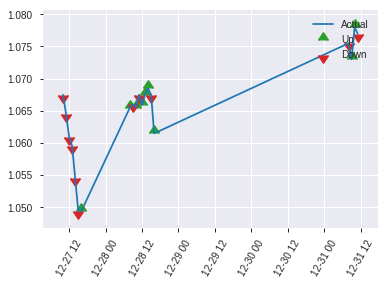


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19402064351133494
RMSE: 0.4404777446265985
LogLoss: 0.5710696059813591
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.15034943754756
Residual deviance: 254.69704426768615
AIC: 356.6970442676861
AUC: 0.7828185328185328
pr_auc: 0.7397385230906621
Gini: 0.5656370656370655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2609655964064331: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   50   0.4505   (50.0/111.0)
1      9    103  0.0804   (9.0/112.0)
Total  70   153  0.2646   (59.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.260966     0.777358  152
max f2                       0.220043     0.862069  160
max f0point5                 0.484201     0.739051  108
max accuracy                 0.484201     0.735426  108
max precision                0.956536     1         0
max recall                   0.0361518    1         211
max specificity              0.956536     1         0
max absolute_mcc             0.260966     0.505506  152
max min_per_class_accuracy   0.484201     0.723214  108
max mean_per_class_accuracy  0.484201     0.735481  108

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 44.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.927764           1.99107    1.99107            1                0.941031   1                           0.941031            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.906083           0.995536   1.59286            0.5              0.916116   0.8                         0.931065            0.00892857      0.0357143                  -0.446429  59.2857
    3        0.0313901                   0.889674           1.99107    1.70663            1                0.893415   0.857143                    0.920308            0.0178571       0.0535714                  99.1071    70.6633
    4        0.0403587                   0.867334           1.99107    1.76984            1                0.878033   0.888889                    0.910913            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.860474           1.32738    1.65923            0.666667         0.865025   0.833333                    0.899441            0.0178571       0.0892857                  32.7381    65.9226
    6        0.103139                    0.805833           1.62906    1.6448             0.818182         0.824442   0.826087                    0.863572            0.0803571       0.169643                   62.9058    64.4798
    7        0.152466                    0.758937           1.62906    1.63971            0.818182         0.783622   0.823529                    0.837706            0.0803571       0.25                       62.9058    63.9706
    8        0.201794                    0.719056           1.26705    1.54861            0.636364         0.737506   0.777778                    0.813213            0.0625          0.3125                     26.7045    54.8611
    9        0.300448                    0.598813           1.17654    1.42644            0.590909         0.666366   0.716418                    0.764994            0.116071        0.428571                   17.6542    42.6439
    10       0.399103                    0.540998           1.81006    1.52127            0.909091         0.57165    0.764045                    0.717201            0.178571        0.607143                   81.0065    52.1268
    11       0.502242                    0.479219           1.12539    1.43997            0.565217         0.506938   0.723214                    0.674022            0.116071        0.723214                   12.5388    43.9971
    12       0.600897                    0.364287           1.08604    1.38186            0.545455         0.420743   0.69403                     0.632439            0.107143        0.830357                   8.6039     38.1863
    13       0.699552                    0.245079           0.905032   1.31462            0.454545         0.303676   0.660256                    0.586075            0.0892857       0.919643                   -9.49675   31.4618
    14       0.798206                    0.158552           0.27151    1.18569            0.136364         0.20337    0.595506                    0.538775            0.0267857       0.946429                   -72.849    18.5694
    15       0.896861                    0.0773035          0.452516   1.10504            0.227273         0.111886   0.555                       0.491817            0.0446429       0.991071                   -54.7484   10.5045
    16       1                           0.00404525         0.0865683  1                  0.0434783        0.0

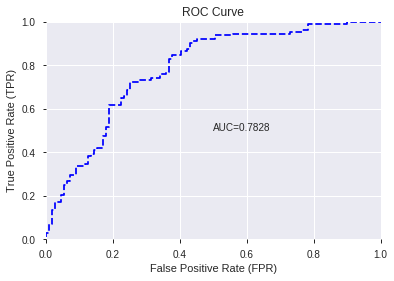

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


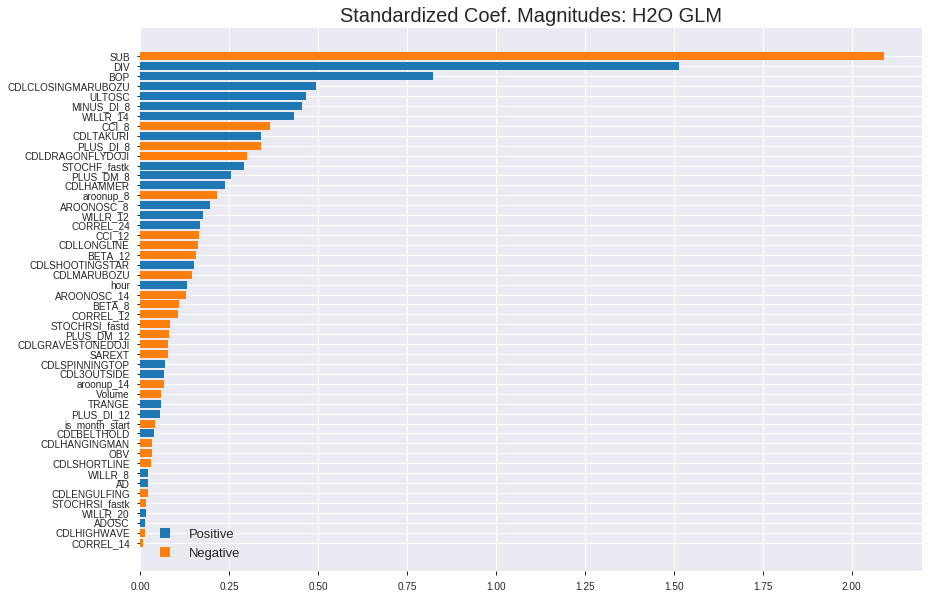

'log_likelihood'
--2019-08-27 14:35:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.104
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.104|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_143514_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_143514_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SUB',
 'DIV',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'MINUS_DI_8',
 'WILLR_14',
 'CCI_8',
 'CDLTAKURI',
 'PLUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'PLUS_DM_8',
 'CDLHAMMER',
 'aroonup_8',
 'AROONOSC_8',
 'WILLR_12',
 'CORREL_24',
 'CCI_12',
 'CDLLONGLINE',
 'BETA_12',
 'CDLSHOOTINGSTAR',
 'CDLMARUBOZU',
 'hour',
 'AROONOSC_14',
 'BETA_8',
 'CORREL_12',
 'STOCHRSI_fastd',
 'PLUS_DM_12',
 'CDLGRAVESTONEDOJI',
 'SAREXT',
 'CDLSPINNINGTOP',
 'CDL3OUTSIDE',
 'aroonup_14',
 'Volume',
 'TRANGE',
 'PLUS_DI_12',
 'is_month_start',
 'CDLBELTHOLD',
 'CDLHANGINGMAN',
 'OBV',
 'CDLSHORTLINE',
 'WILLR_8',
 'AD',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'WILLR_20',
 'ADOSC',
 'CDLHIGHWAVE',
 'CORREL_14']

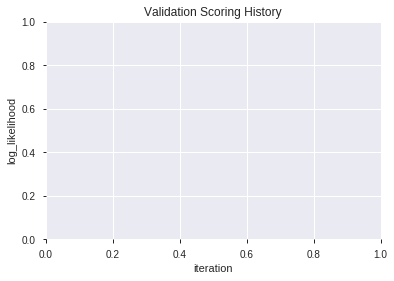

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_143525_model_4  0.804778  0.550338              0.269908  0.430959  0.185726
1  XGBoost_grid_1_AutoML_20190827_143525_model_3  0.792712  0.551100              0.265122  0.432219  0.186814
2  XGBoost_grid_1_AutoML_20190827_143525_model_2  0.790621  0.562405              0.247265  0.436167  0.190241
3  XGBoost_grid_1_AutoML_20190827_143525_model_6  0.789977  0.550827              0.251609  0.432872  0.187378
4               XGBoost_2_AutoML_20190827_143525  0.787725  0.568736              0.242479  0.440521  0.194059
5               XGBoost_3_AutoML_20190827_143525  0.785634  0.565270              0.246863  0.439572  0.193223
6               XGBoost_1_AutoML_20190827_143525  0.781049  0.568171              0.283301  0.441166  0.194627
7  XGBoost_grid_1_AutoML_20190827_143525_model_5  0.777831  0.572785              0.278676  0.441985  0.195350
8  XGBoost_grid_1_AutoML_20190827_143525_model_7  0.771638  0.571863              0.278596  0.442085  0.195439
9  XGBoost_grid_1_AutoML_20190827_143525_model_1  0.770833  0.576435              0.269385  0.444745  0.197798

variable  relative_importance  scaled_importance  percentage
0              BOP          1988.256958           1.000000    0.381164
1     STOCHF_fastk           496.256104           0.249594    0.095136
2              DIV           491.069916           0.246985    0.094142
3           ULTOSC           241.516953           0.121472    0.046301
4           TRANGE           167.915726           0.084454    0.032191
5             hour           157.453049           0.079191    0.030185
6            CCI_8           144.500305           0.072677    0.027702
7            ADOSC           139.617645           0.070221    0.026766
8          WILLR_8           127.288445           0.064020    0.024402
9        CORREL_24           116.610069           0.058649    0.022355
10  STOCHRSI_fastd           100.705452           0.050650    0.019306
11             SUB            99.765732           0.050177    0.019126
12      PLUS_DI_12            88.422218           0.044472    0.016951
13       aroonup_8            78.575737           0.039520    0.015064
14      MINUS_DI_8            76.021965           0.038235    0.014574
15              AD            56.361313           0.028347    0.010805
16         BETA_12            55.837345           0.028084    0.010704
17      PLUS_DM_12            55.600285           0.027964    0.010659
18          BETA_8            53.889690           0.027104    0.010331
19      aroonup_14            52.854095           0.026583    0.010133
20          SAREXT            45.494091           0.022881    0.008722
21       CORREL_14            41.065258           0.020654    0.007873
22        WILLR_20            39.605835           0.019920    0.007593
23       PLUS_DI_8            33.121765           0.016659    0.006350
24       PLUS_DM_8            33.043652           0.016619    0.006335
25        WILLR_14            32.300549           0.016246    0.006192
26          Volume            29.094147           0.014633    0.005578
27             OBV            28.058596           0.014112    0.005379
28       CORREL_12            26.554848           0.013356    0.005091
29  STOCHRSI_fastk            26.202650           0.013179    0.005023
30      AROONOSC_8            25.858889           0.013006    0.004957
31          CCI_12            25.090628           0.012619    0.004810
32        WILLR_12            24.512463           0.012329    0.004699
33     AROONOSC_14             9.547979           0.004802    0.001830
34  CDLSPINNINGTOP             8.201885           0.004125    0.001572

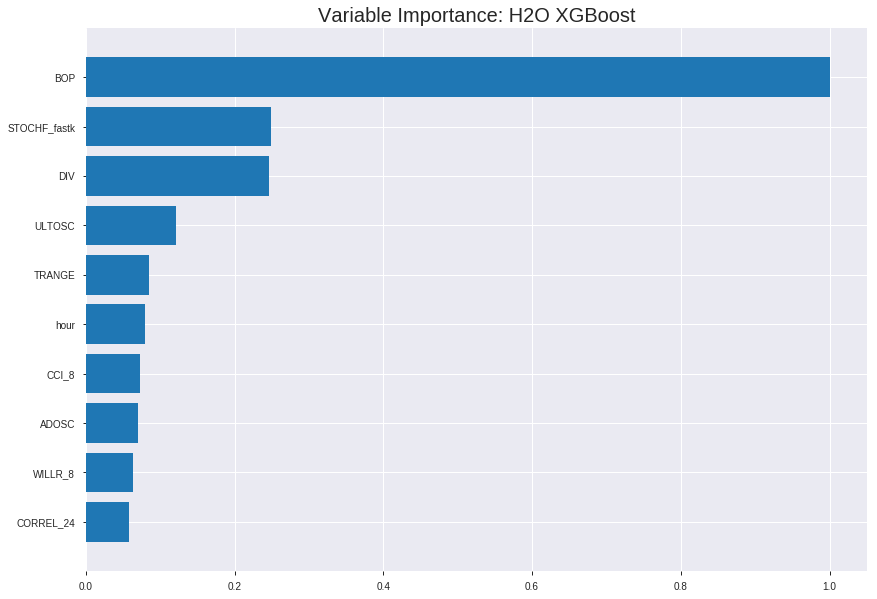

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_143525_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16407903126979262
RMSE: 0.4050666997789285
LogLoss: 0.5029585389906102
Mean Per-Class Error: 0.22673797056524836
AUC: 0.848208782838155
pr_auc: 0.843724478481775
Gini: 0.6964175656763101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46767468750476837: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      531  238  0.3095   (238.0/769.0)
1      128  659  0.1626   (128.0/787.0)
Total  659  897  0.2352   (366.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467675     0.78266   222
max f2                       0.250747     0.862892  320
max f0point5                 0.628668     0.792988  134
max accuracy                 0.536906     0.773136  186
max precision                0.898019     1         0
max recall                   0.121482     1         387
max specificity              0.898019     1         0
max absolute_mcc             0.536906     0.546553  186
max min_per_class_accuracy   0.526026     0.771283  191
max mean_per_class_accuracy  0.536906     0.773262  186

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.868256           1.97713    1.97713            1                0.880913  1                           0.880913            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.857609           1.97713    1.97713            1                0.862083  1                           0.871498            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.852602           1.71351    1.893              0.866667         0.855182  0.957447                    0.866291            0.0165184       0.0571792                  71.3511   89.2995
    4        0.0404884                   0.846503           1.85356    1.88298            0.9375           0.849377  0.952381                    0.861995            0.0190597       0.0762389                  85.3558   88.2979
    5        0.0501285                   0.837331           1.97713    1.90108            1                0.842305  0.961538                    0.858209            0.0190597       0.0952986                  97.7128   90.1085
    6        0.100257                    0.813822           1.79969    1.85039            0.910256         0.824223  0.935897                    0.841216            0.090216        0.185515                   79.9694   85.0389
    7        0.150386                    0.781678           1.77435    1.82504            0.897436         0.800198  0.923077                    0.827543            0.0889454       0.27446                    77.4346   82.5042
    8        0.200514                    0.743431           1.64761    1.78068            0.833333         0.760563  0.900641                    0.810798            0.0825921       0.357052                   64.7607   78.0683
    9        0.300129                    0.679146           1.65824    1.74004            0.83871          0.712328  0.880086                    0.778115            0.165184        0.522236                   65.8237   74.0042
    10       0.400386                    0.59642            1.34343    1.64073            0.679487         0.634975  0.829856                    0.742273            0.134689        0.656925                   34.3433   64.0731
    11       0.5                         0.530214           1.10974    1.53494            0.56129          0.565003  0.77635                     0.706956            0.110546        0.767471                   10.9743   53.4943
    12       0.600257                    0.445829           0.836477   1.41828            0.423077         0.488892  0.717345                    0.670534            0.0838628       0.851334                   -16.3523  41.8283
    13       0.699871                    0.34151            0.67605    1.31264            0.341935         0.395743  0.663912                    0.631422            0.0673443       0.918679                   -32.395   31.2639
    14       0.800129                    0.253313           0.443586   1.20375            0.224359         0.293559  0.608835                    0.589087            0.0444727       0.963151                   -55.6414  20.3746
    15       0.899743                    0.172997           0.280625   1.10154            0.141935         0.213195  0.557143                    0.547471            0.0279543       0.991105                   -71.9375  10.1543
    16       1                           0.0920313          0.0887173  1                  0.0448718        0.13918   0.505784                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19078489263930043
RMSE: 0.43678930005129524
LogLoss: 0.5639234448312508
Mean Per-Class Error: 0.2740879893346261
AUC: 0.7860663353936896
pr_auc: 0.7408039140922086
Gini: 0.5721326707873793
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2828456163406372: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  109  0.491    (109.0/222.0)
1      22   201  0.0987   (22.0/223.0)
Total  135  310  0.2944   (131.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282846     0.754221  281
max f2                       0.172002     0.860979  341
max f0point5                 0.492593     0.733138  176
max accuracy                 0.477879     0.725843  185
max precision                0.816906     0.857143  30
max recall                   0.109574     1         394
max specificity              0.867554     0.995495  0
max absolute_mcc             0.477879     0.452657  185
max min_per_class_accuracy   0.454244     0.721973  197
max mean_per_class_accuracy  0.477879     0.725912  185

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 46.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.861635           1.19731   1.19731            0.6              0.864854  0.6                         0.864854            0.0134529       0.0134529                  19.7309    19.7309
    2        0.0202247                   0.853479           0.997758  1.10862            0.5              0.85998   0.555556                    0.862688            0.00896861      0.0224215                  -0.224215  10.862
    3        0.0314607                   0.846033           1.99552   1.42537            1                0.850149  0.714286                    0.85821             0.0224215       0.044843                   99.5516    42.5368
    4        0.0404494                   0.837531           1.99552   1.55207            1                0.842417  0.777778                    0.8547              0.0179372       0.0627803                  99.5516    55.2068
    5        0.0516854                   0.832571           1.59641   1.56171            0.8              0.835423  0.782609                    0.85051             0.0179372       0.0807175                  59.6413    56.1708
    6        0.101124                    0.802309           1.63269   1.59641            0.818182         0.816654  0.8                         0.833958            0.0807175       0.161435                   63.2695    59.6413
    7        0.150562                    0.763485           1.81411   1.66789            0.909091         0.780434  0.835821                    0.816383            0.0896861       0.251121                   81.4105    66.7894
    8        0.2                         0.730155           1.63269   1.65919            0.818182         0.746996  0.831461                    0.799231            0.0807175       0.331839                   63.2695    65.9193
    9        0.301124                    0.643768           1.37469   1.56365            0.688889         0.68838   0.783582                    0.762005            0.139013        0.470852                   37.4689    56.365
    10       0.4                         0.552432           1.26987   1.49103            0.636364         0.590168  0.747191                    0.719528            0.125561        0.596413                   26.9874    49.1031
    11       0.501124                    0.452813           1.24165   1.44071            0.622222         0.4975    0.721973                    0.674724            0.125561        0.721973                   24.1654    44.0709
    12       0.6                         0.364124           0.997758  1.36771            0.5              0.404976  0.685393                    0.630272            0.0986547       0.820628                   -0.224215  36.7713
    13       0.698876                    0.281249           0.816347  1.28971            0.409091         0.323274  0.646302                    0.586838            0.0807175       0.901345                   -18.3653   28.9706
    14       0.8                         0.199195           0.443448  1.18274            0.222222         0.24434   0.592697                    0.543545            0.044843        0.946188                   -55.6552   18.2735
    15       0.898876                    0.147212           0.317468  1.08756            0.159091         0.168869  0.545                       0.50233             0.0313901       0.977578                   -68.2532   8.75561
    16       1                           0.103769           0.221724  1                  0.111111         0.126233  0.501124                    0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:35:35  3.780 sec   0                  0.5              0.693147            0.5             0                  1                0.494216                         0.5                0.693147              0.5               0                    1                  0.498876
    2019-08-27 14:35:35  3.893 sec   5                  0.475453         0.644966            0.803509        0.774259           1.87827          0.280848                         0.478088           0.650016              0.765816          0.735101             1.71044            0.280899
    2019-08-27 14:35:35  3.949 sec   10                 0.459102         0.61334             0.810585        0.799749           1.87307          0.279563                         0.464733           0.623906              0.772967          0.732186             1.59641            0.301124
    2019-08-27 14:35:35  4.010 sec   15                 0.446885         0.589483            0.816649        0.81181            1.85356          0.267995                         0.454424           0.603438              0.780057          0.746621             1.59641            0.292135
    2019-08-27 14:35:35  4.073 sec   20                 0.438432         0.572539            0.82064         0.815701           1.97713          0.260925                         0.448303           0.590745              0.782814          0.746872             1.59641            0.27191
    2019-08-27 14:35:35  4.135 sec   25                 0.431502         0.558425            0.824335        0.818654           1.72999          0.255141                         0.443777           0.581136              0.78337           0.747891             1.59641            0.303371
    2019-08-27 14:35:35  4.197 sec   30                 0.426498         0.547996            0.828579        0.824625           1.85356          0.26928                          0.441542           0.575929              0.782996          0.739662             1.19731            0.260674
    2019-08-27 14:35:35  4.268 sec   35                 0.42196          0.538422            0.831339        0.826484           1.85356          0.260283                         0.440374           0.572746              0.781734          0.741808             1.19731            0.31236
    2019-08-27 14:35:35  4.344 sec   40                 0.418603         0.531201            0.833407        0.830845           1.97713          0.256427                         0.440169           0.571707              0.780532          0.739129             1.19731            0.307865
    2019-08-27 14:35:35  4.409 sec   45                 0.415158         0.52409             0.836767        0.833392           1.97713          0.250643                         0.439185           0.569204              0.781511          0.739497             1.19731            0.289888
    2019-08-27 14:35:35  4.476 sec   50                 0.412412         0.518256            0.839531        0.835742           1.97713          0.248072                         0.438734           0.568095              0.782178          0.741111             1.19731            0.303371
    2019-08-27 14:35:35  4.554 sec   55                 0.409824         0.512686            0.841841        0.836762           1.97713          0.246144                         0.437932           0.566374              0.783753          0.7

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             1988.2569580078125     1.0                   0.3811643389818352
STOCHF_fastk    496.256103515625       0.2495935455007094    0.0951361587849105
DIV             491.0699157714844      0.2469851362992463    0.09414192621584068
ULTOSC          241.51695251464844     0.12147169989368117   0.04630068019497484
TRANGE          167.9157257080078      0.0844537347306736    0.032190751973164455
---             ---                    ---                   ---
AROONOSC_8      25.858888626098633     0.01300580818890162   0.004957350281247225
CCI_12          25.090627670288086     0.01261940895980986   0.004810068674507373
WILLR_12        24.512462615966797     0.012328619053609508  0.004699229932127927
AROONOSC_14     9.547979354858398      0.004802185812252986  0.0018304219807953569
CDLSPINNINGTOP  8.201885223388672      0.004125163596362701  0.001572365255399519


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.757847533632287)

('F1', 0.7744360902255638)

('auc', 0.8047779922779923)

('logloss', 0.550338051510852)

('mean_per_class_error', 0.24239864864864868)

('rmse', 0.4309591703180315)

('mse', 0.18572580648120607)

xgboost prediction progress: |████████████████████████████████████████████| 100%


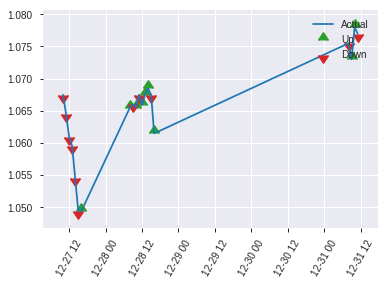


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18572580648120607
RMSE: 0.4309591703180315
LogLoss: 0.550338051510852
Mean Per-Class Error: 0.24239864864864868
AUC: 0.8047779922779923
pr_auc: 0.7662277638260384
Gini: 0.6095559845559846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2825947403907776: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   51   0.4595   (51.0/111.0)
1      9    103  0.0804   (9.0/112.0)
Total  69   154  0.2691   (60.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282595     0.774436  153
max f2                       0.255082     0.873786  169
max f0point5                 0.417266     0.748355  123
max accuracy                 0.417266     0.757848  123
max precision                0.892771     1         0
max recall                   0.129917     1         208
max specificity              0.892771     1         0
max absolute_mcc             0.417266     0.518466  123
max min_per_class_accuracy   0.454385     0.738739  111
max mean_per_class_accuracy  0.417266     0.757601  123

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 45.17 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.845387           1.32738    1.32738            0.666667         0.868533  0.666667                    0.868533            0.0178571       0.0178571                  32.7381   32.7381
    2        0.0224215                   0.831509           1.99107    1.59286            1                0.833862  0.8                         0.854664            0.0178571       0.0357143                  99.1071   59.2857
    3        0.0313901                   0.815863           1.99107    1.70663            1                0.822667  0.857143                    0.845522            0.0178571       0.0535714                  99.1071   70.6633
    4        0.0403587                   0.809462           1.99107    1.76984            1                0.813913  0.888889                    0.838498            0.0178571       0.0714286                  99.1071   76.9841
    5        0.0538117                   0.796977           1.99107    1.82515            1                0.802424  0.916667                    0.829479            0.0267857       0.0982143                  99.1071   82.5149
    6        0.103139                    0.753472           1.81006    1.81793            0.909091         0.770554  0.913043                    0.801298            0.0892857       0.1875                     81.0065   81.7935
    7        0.152466                    0.722491           1.44805    1.69827            0.727273         0.739168  0.852941                    0.781197            0.0714286       0.258929                   44.8052   69.8267
    8        0.201794                    0.678303           1.26705    1.59286            0.636364         0.70143   0.8                         0.761698            0.0625          0.321429                   26.7045   59.2857
    9        0.300448                    0.587106           1.35755    1.51559            0.681818         0.625464  0.761194                    0.716965            0.133929        0.455357                   35.7549   51.5592
    10       0.399103                    0.526363           1.53856    1.52127            0.772727         0.55382   0.764045                    0.676637            0.151786        0.607143                   53.8555   52.1268
    11       0.502242                    0.454385           1.29852    1.47553            0.652174         0.495818  0.741071                    0.639504            0.133929        0.741071                   29.8525   47.5526
    12       0.600897                    0.374093           0.905032   1.38186            0.454545         0.413369  0.69403                     0.602378            0.0892857       0.830357                   -9.49675  38.1863
    13       0.699552                    0.277899           0.905032   1.31462            0.454545         0.326762  0.660256                    0.563509            0.0892857       0.919643                   -9.49675  31.4618
    14       0.798206                    0.220803           0.543019   1.21925            0.272727         0.25509   0.61236                     0.52539             0.0535714       0.973214                   -45.6981  21.9252
    15       0.896861                    0.158794           0.181006   1.10504            0.0909091        0.194069  0.555                       0.488944            0.0178571       0.991071                   -81.8994  10.5045
    16       1                           0.0923135          0.0865683  1                  0.0434783        0.128016  0.502242                   

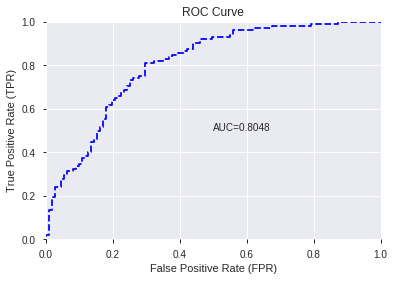

This function is available for GLM models only


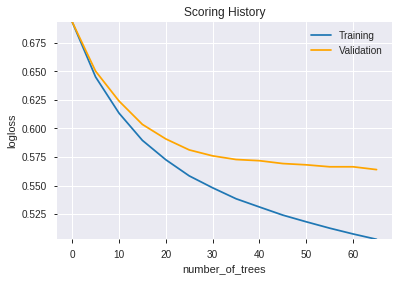

--2019-08-27 14:35:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_143525_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_143525_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'ULTOSC',
 'TRANGE',
 'hour',
 'CCI_8',
 'ADOSC',
 'WILLR_8',
 'CORREL_24',
 'STOCHRSI_fastd',
 'SUB',
 'PLUS_DI_12',
 'aroonup_8',
 'MINUS_DI_8',
 'AD',
 'BETA_12',
 'PLUS_DM_12',
 'BETA_8',
 'aroonup_14',
 'SAREXT',
 'CORREL_14',
 'WILLR_20',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'WILLR_14',
 'Volume',
 'OBV',
 'CORREL_12',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'CCI_12',
 'WILLR_12',
 'AROONOSC_14',
 'CDLSPINNINGTOP']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 918] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


77

['BOP',
 'CCI_8',
 'CMO_8',
 'MFI_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MINUS_DI_14',
 'MINUS_DM_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'MOM_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_143555_model_5  0.788851  0.573001              0.251569  0.444955  0.197985
1  DeepLearning_grid_1_AutoML_20190827_143555_model_9  0.782738  0.572090              0.256274  0.440654  0.194176
2  DeepLearning_grid_1_AutoML_20190827_143555_model_6  0.782255  0.573721              0.278837  0.444042  0.197173
3  DeepLearning_grid_1_AutoML_20190827_143555_model_8  0.776223  0.576056              0.265364  0.444135  0.197256
4  DeepLearning_grid_1_AutoML_20190827_143555_model_7  0.768742  0.629399              0.269868  0.451415  0.203775
5  DeepLearning_grid_1_AutoML_20190827_143555_model_3  0.763353  0.663345              0.282819  0.462604  0.214002
6               DeepLearning_1_AutoML_20190827_143555  0.762950  0.660170              0.283301  0.465953  0.217112
7  DeepLearning_grid_1_AutoML_20190827_143555_model_4  0.760457  0.707572              0.301239  0.472265  0.223034
8  DeepLearning_grid_1_AutoML_20190827_143555_model_2  0.750804  0.669717              0.318975  0.466295  0.217431
9  DeepLearning_grid_1_AutoML_20190827_143555_model_1  0.738417  0.954266              0.333132  0.505128  0.255155

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.032076
1   CDLCLOSINGMARUBOZU             0.858542           0.858542    0.027539
2                  SUB             0.692836           0.692836    0.022224
3               ULTOSC             0.659911           0.659911    0.021167
4               TRANGE             0.626550           0.626550    0.020097
..                 ...                  ...                ...         ...
72              CMO_12             0.319973           0.319973    0.010264
73              CMO_14             0.317311           0.317311    0.010178
74               RSI_8             0.317154           0.317154    0.010173
75              RSI_14             0.312029           0.312029    0.010009
76              RSI_12             0.309049           0.309049    0.009913

[77 rows x 4 columns]

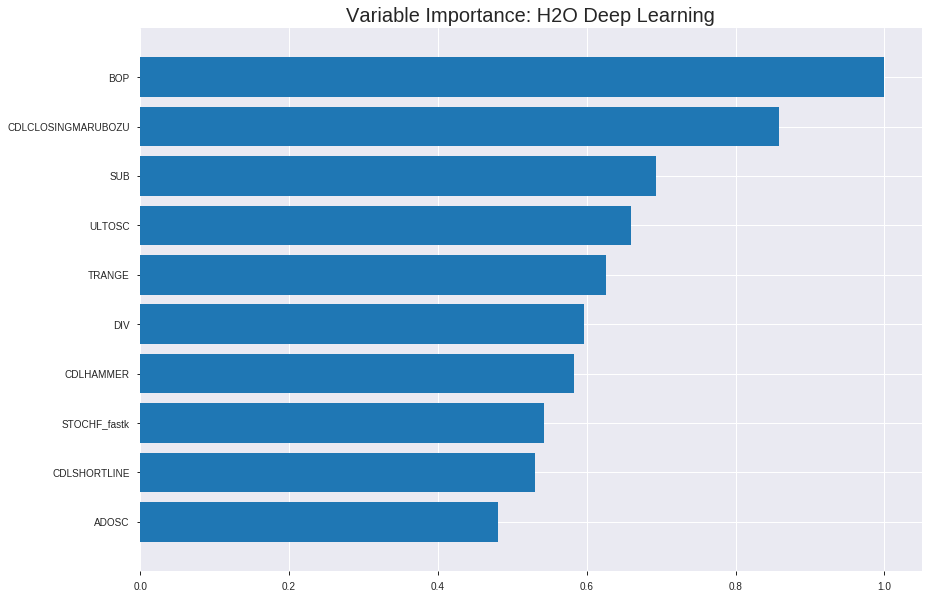

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_143555_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.179240902905413
RMSE: 0.4233685190297136
LogLoss: 0.5287392686204968
Mean Per-Class Error: 0.2723920734034696
AUC: 0.8118887381589318
pr_auc: 0.8139507062239507
Gini: 0.6237774763178636
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3724879945436456: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      389  380   0.4941   (380.0/769.0)
1      73   714   0.0928   (73.0/787.0)
Total  462  1094  0.2911   (453.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372488     0.759171  266
max f2                       0.254727     0.857365  325
max f0point5                 0.486333     0.742532  198
max accuracy                 0.486333     0.726864  198
max precision                0.995137     1         0
max recall                   0.0881929    1         375
max specificity              0.995137     1         0
max absolute_mcc             0.486333     0.458691  198
max min_per_class_accuracy   0.454493     0.721728  215
max mean_per_class_accuracy  0.486333     0.727608  198

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.988811           1.97713   1.97713            1                0.992778  1                           0.992778            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.983399           1.97713   1.97713            1                0.986322  1                           0.98955             0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.97432            1.97713   1.97713            1                0.978356  1                           0.985977            0.0190597       0.0597205                  97.7128   97.7128
    4        0.0404884                   0.956134           1.97713   1.97713            1                0.964623  1                           0.980554            0.0203304       0.0800508                  97.7128   97.7128
    5        0.0501285                   0.943871           1.84532   1.95178            0.933333         0.951058  0.987179                    0.974882            0.0177891       0.0978399                  84.532    95.1781
    6        0.100257                    0.867032           1.90108   1.92643            0.961538         0.903002  0.974359                    0.938942            0.0952986       0.193139                   90.1085   92.6433
    7        0.150386                    0.794581           1.64761   1.83349            0.833333         0.830643  0.92735                     0.902842            0.0825921       0.275731                   64.7607   83.3491
    8        0.200514                    0.722404           1.59691   1.77435            0.807692         0.759147  0.897436                    0.866918            0.0800508       0.355781                   59.6911   77.4346
    9        0.300129                    0.612604           1.41588   1.65537            0.716129         0.668524  0.837259                    0.80107             0.141042        0.496823                   41.5879   65.5369
    10       0.400386                    0.513226           1.15332   1.52966            0.583333         0.556726  0.773676                    0.739886            0.115629        0.612452                   15.3325   52.9656
    11       0.5                         0.45493            1.07148   1.43837            0.541935         0.480539  0.727506                    0.688217            0.106734        0.719187                   7.1476    43.8374
    12       0.600257                    0.40841            0.963216  1.35901            0.487179         0.43293   0.687366                    0.645578            0.0965693       0.815756                   -3.67836  35.9011
    13       0.699871                    0.372554           0.905652  1.29448            0.458065         0.391739  0.654729                    0.609448            0.090216        0.905972                   -9.43477  29.4483
    14       0.800129                    0.319969           0.443586  1.18787            0.224359         0.348549  0.600803                    0.576757            0.0444727       0.950445                   -55.6414  18.7865
    15       0.899743                    0.213715           0.369914  1.09731            0.187097         0.27575   0.555                       0.543431            0.0368488       0.987294                   -63.0086  9.73062
    16       1                           0.00302051         0.126739  1                  0.0641026        0.118748  0.505784                    0.500854         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1948640727627873
RMSE: 0.44143410919727
LogLoss: 0.5710597109437295
Mean Per-Class Error: 0.2833999919201713
AUC: 0.7809659435219973
pr_auc: 0.7698675495924965
Gini: 0.5619318870439947
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32189268671872867: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  113  0.509    (113.0/222.0)
1      21   202  0.0942   (21.0/223.0)
Total  130  315  0.3011   (134.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321893     0.750929  276
max f2                       0.091782     0.848624  371
max f0point5                 0.429594     0.71494   194
max accuracy                 0.378295     0.716854  240
max precision                0.998197     1         0
max recall                   0.0504262    1         382
max specificity              0.998197     1         0
max absolute_mcc             0.377817     0.445765  241
max min_per_class_accuracy   0.42585      0.70852   198
max mean_per_class_accuracy  0.378295     0.7166    240

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 47.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.992202           1.99552   1.99552            1                0.994729   1                           0.994729            0.0224215       0.0224215                  99.5516    99.5516
    2        0.0202247                   0.987869           1.49664   1.77379            0.75             0.989155   0.888889                    0.992252            0.0134529       0.0358744                  49.6637    77.3792
    3        0.0314607                   0.984615           1.99552   1.85298            1                0.986801   0.928571                    0.990305            0.0224215       0.058296                   99.5516    85.2979
    4        0.0404494                   0.975145           1.99552   1.88465            1                0.980975   0.944444                    0.988232            0.0179372       0.0762332                  99.5516    88.4654
    5        0.0516854                   0.963299           1.99552   1.90875            1                0.96978    0.956522                    0.984221            0.0224215       0.0986547                  99.5516    90.8754
    6        0.101124                    0.898544           1.7234    1.81814            0.863636         0.932347   0.911111                    0.95886             0.0852018       0.183857                   72.34      81.8137
    7        0.150562                    0.803207           1.63269   1.75725            0.818182         0.849766   0.880597                    0.923038            0.0807175       0.264574                   63.2695    75.7245
    8        0.2                         0.749846           1.26987   1.63677            0.636364         0.777467   0.820225                    0.887055            0.0627803       0.327354                   26.9874    63.6771
    9        0.301124                    0.567699           1.33034   1.53387            0.666667         0.647385   0.768657                    0.806569            0.134529        0.461883                   33.0344    53.3867
    10       0.4                         0.474177           1.08846   1.42377            0.545455         0.521819   0.713483                    0.736181            0.107623        0.569507                   8.84631    42.3767
    11       0.501124                    0.42488            1.37469   1.41386            0.688889         0.445116   0.70852                     0.677446            0.139013        0.70852                    37.4689    41.3863
    12       0.6                         0.383475           0.997758  1.34529            0.5              0.404402   0.674157                    0.63245             0.0986547       0.807175                   -0.224215  34.5291
    13       0.698876                    0.330121           0.907053  1.28329            0.454545         0.357768   0.643087                    0.593588            0.0896861       0.896861                   -9.29474   28.329
    14       0.8                         0.256682           0.443448  1.17713            0.222222         0.295479   0.589888                    0.555906            0.044843        0.941704                   -55.6552   17.713
    15       0.898876                    0.139663           0.317468  1.08257            0.159091         0.198399   0.5425                      0.51658             0.0313901       0.973094                   -68.2532   8.25673
    16       1                           0.00883192         0.266069  1                  0.133333         0.0702518  0.501124    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:39:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:39:08  1 min  8.098 sec  1272 obs/sec      1.69152   1             2632       0.439795         0.567336            0.226218       0.77689         0.779474           1.97713          0.30527                          0.448773           0.586661              0.194406         0.771452          0.75269              1.59641            0.283146
    2019-08-27 14:39:15  1 min 14.946 sec  1897 obs/sec      10.223    6             15907      0.43028          0.546278            0.259337       0.799891        0.81269            1.97713          0.31491                          0.442439           0.576571              0.216988         0.789924          0.78921              1.99552            0.28764
    2019-08-27 14:39:21  1 min 20.941 sec  2103 obs/sec      18.7024   11            29101      0.423369         0.528739            0.28294        0.811889        0.813951           1.97713          0.291131                         0.441434           0.57106               0.22054          0.780966          0.769868             1.99552            0.301124
    2019-08-27 14:39:27  1 min 26.589 sec  2232 obs/sec      27.1684   16            42274      0.413575         0.505833            0.315732       0.8259          0.824766           1.97713          0.283419                         0.436174           0.573248              0.239006         0.789248          0.780964             1.99552            0.283146
    2019-08-27 14:39:32  1 min 32.128 sec  2316 obs/sec      35.644    21            55462      0.413385         0.502739            0.316359       0.82178         0.804784           1.97713          0.290488                         0.446794           0.607362              0.201498         0.77432           0.767192             1.99552            0.292135
    2019-08-27 14:39:38  1 min 37.584 sec  2379 obs/sec      44.1279   26            68663      0.398936         0.474106            0.363316       0.850467        0.847828           1.97713          0.269923                         0.443212           0.601118              0.214247         0.779289          0.758713             1.99552            0.298876
    2019-08-27 14:39:38  1 min 38.142 sec  2377 obs/sec      44.1279   26            68663      0.423369         0.528739            0.28294        0.811889        0.813951           1.97713          0.291131                         0.441434           0.57106               0.22054          0.780966          0.769868             1.99552            0.301124

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.032076157380499355
CDLCLOSINGMARUBOZU  0.8585424423217773     0.8585424423217773   0.02753874249775162
SUB                 0.6928359270095825     0.6928359270095825   0.022223514233623533
ULTOSC              0.6599107980728149     0.6599107980728149   0.021167402616074544
TRANGE              0.626550018787384      0.626550018787384    0.020097317009378956
---                 ---                    ---                  ---
CMO_12              0.3199734389781952     0.3199734389781952   0.010263518386244196
CMO_14              0.3173106908798218     0.3173106908798218   0.010178107659176145
RSI_8               0.31715425848960876    0.31715425848960876  0.010173089909208264
RSI_14              0.31202927231788635    0.31202927231788635  0.010008700046191213
RSI_12              0.30904895067214966    0.30904895067214966  0.009913102780038055


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.7723577235772358)

('auc', 0.7888513513513513)

('logloss', 0.5730007559438293)

('mean_per_class_error', 0.25156853281853286)

('rmse', 0.4449554851226272)

('mse', 0.19798538374071256)

deeplearning prediction progress: |███████████████████████████████████████| 100%


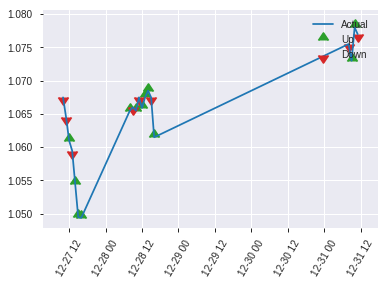


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19798538374071256
RMSE: 0.4449554851226272
LogLoss: 0.5730007559438293
Mean Per-Class Error: 0.25156853281853286
AUC: 0.7888513513513513
pr_auc: 0.7496716507421574
Gini: 0.5777027027027026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37468207252299285: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   39   0.3514   (39.0/111.0)
1      17   95   0.1518   (17.0/112.0)
Total  89   134  0.2511   (56.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374682     0.772358  133
max f2                       0.151979     0.868545  190
max f0point5                 0.374682     0.733025  133
max accuracy                 0.374682     0.748879  133
max precision                0.989759     1         0
max recall                   0.122545     1         196
max specificity              0.989759     1         0
max absolute_mcc             0.374682     0.507294  133
max min_per_class_accuracy   0.399154     0.702703  111
max mean_per_class_accuracy  0.374682     0.748431  133

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 43.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.977547           1.32738   1.32738            0.666667         0.984361   0.666667                    0.984361            0.0178571       0.0178571                  32.7381   32.7381
    2        0.0224215                   0.974239           1.99107   1.59286            1                0.976193   0.8                         0.981094            0.0178571       0.0357143                  99.1071   59.2857
    3        0.0313901                   0.968502           1.99107   1.70663            1                0.971209   0.857143                    0.978269            0.0178571       0.0535714                  99.1071   70.6633
    4        0.0403587                   0.964824           1.99107   1.76984            1                0.96698    0.888889                    0.97576             0.0178571       0.0714286                  99.1071   76.9841
    5        0.0538117                   0.95058            1.99107   1.82515            1                0.95771    0.916667                    0.971248            0.0267857       0.0982143                  99.1071   82.5149
    6        0.103139                    0.859937           1.44805   1.6448             0.727273         0.895392   0.826087                    0.934969            0.0714286       0.169643                   44.8052   64.4798
    7        0.152466                    0.742684           1.62906   1.63971            0.818182         0.795653   0.823529                    0.889896            0.0803571       0.25                       62.9058   63.9706
    8        0.201794                    0.629104           1.44805   1.59286            0.727273         0.68363    0.8                         0.839475            0.0714286       0.321429                   44.8052   59.2857
    9        0.300448                    0.506669           1.26705   1.48587            0.636364         0.558674   0.746269                    0.747272            0.125           0.446429                   26.7045   48.5874
    10       0.399103                    0.445022           1.35755   1.45415            0.681818         0.472194   0.730337                    0.679275            0.133929        0.580357                   35.7549   45.4153
    11       0.502242                    0.399154           1.21196   1.40442            0.608696         0.417968   0.705357                    0.625614            0.125           0.705357                   21.1957   40.4416
    12       0.600897                    0.37417            1.44805   1.41158            0.727273         0.386101   0.708955                    0.586291            0.142857        0.848214                   44.8052   41.158
    13       0.699552                    0.325964           0.633523  1.30185            0.318182         0.352885   0.653846                    0.553375            0.0625          0.910714                   -36.6477  30.1854
    14       0.798206                    0.222706           0.452516  1.19688            0.227273         0.27825    0.601124                    0.51937             0.0446429       0.955357                   -54.7484  19.688
    15       0.896861                    0.112569           0.452516  1.115              0.227273         0.162864   0.56                        0.480155            0.0446429       1                          -54.7484  11.5
    16       1                           0.00827217         0         1                  0                0.0690289  0.502242                    0.43

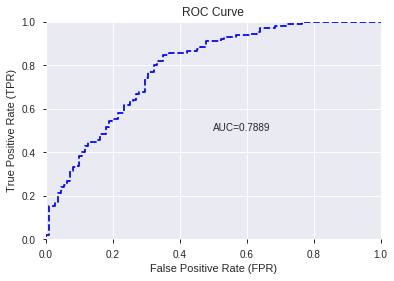

This function is available for GLM models only


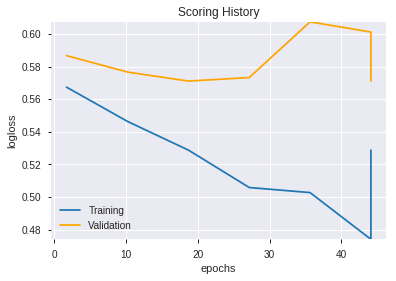

--2019-08-27 14:43:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.89.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.89.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_143555_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_143555_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'ULTOSC',
 'TRANGE',
 'DIV',
 'CDLHAMMER',
 'STOCHF_fastk',
 'CDLSHORTLINE',
 'ADOSC',
 'CDLLONGLINE',
 'CCI_8',
 'CCI_12',
 'WILLR_14',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'MINUS_DM_14',
 'STOCHRSI_fastd',
 'WILLR_12',
 'WILLR_8',
 'MFI_8',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'MINUS_DM_12',
 'MINUS_DI_14',
 'STOCH_slowk',
 'ROCR_20',
 'ROC_8',
 'STOCHF_fastd',
 'CCI_30',
 'MINUS_DM_8',
 'MOM_12',
 'CCI_24',
 'ROCP_20',
 'WILLR_30',
 'CCI_14',
 'ROC_12',
 'ROCR100_20',
 'ROCR100_12',
 'ROCR_12',
 'STOCH_slowd',
 'LINEARREG_ANGLE_8',
 'ROC_20',
 'MOM_20',
 'ROCR_8',
 'ROCR100_30',
 'WILLR_24',
 'LINEARREG_SLOPE_8',
 'ROCP_8',
 'ROCP_30',
 'RSI_30',
 'MINUS_DI_8',
 'ROCP_14',
 'MOM_30',
 'ROCR100_8',
 'ROCR100_14',
 'CCI_20',
 'ROCP_12',
 'RSI_24',
 'RSI_20',
 'MINUS_DI_12',
 'ROCR_30',
 'ROC_14',
 'CMO_30',
 'MOM_8',
 'ROC_30',
 'CMO_24',
 'WILLR_20',
 'MOM_14',
 'CMO_8',
 'ROCR_14',
 'CMO_20',
 'CMO_12',
 'CMO_14',
 'RSI_8',
 'RSI_14',
 'RSI_12']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_144337_model_1  0.78684  0.562037              0.269908  0.436796  0.190791

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.778292           1.000000    0.113893
1   CDLCLOSINGMARUBOZU             0.444544           0.571179    0.065053
2                CCI_8             0.417945           0.537004    0.061161
3               ULTOSC             0.410721           0.527721    0.060104
4                  SUB             0.364696           0.468585    0.053369
..                 ...                  ...                ...         ...
72      STOCHRSI_fastk             0.003760           0.004831    0.000550
73          MINUS_DI_8             0.003194           0.004104    0.000467
74            WILLR_24             0.001406           0.001807    0.000206
75              MOM_14             0.000647           0.000832    0.000095
76              CMO_12             0.000181           0.000233    0.000027

[77 rows x 4 columns]

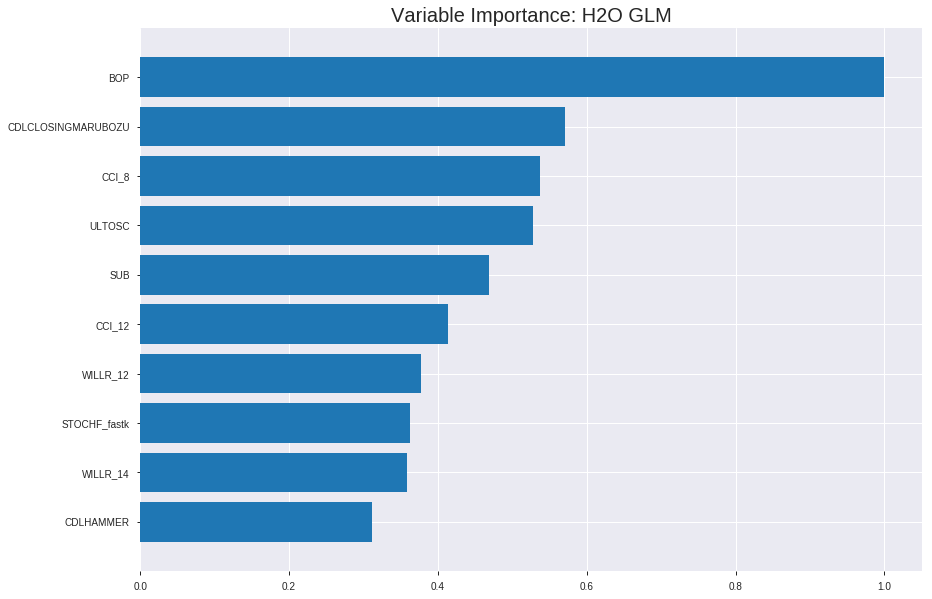

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_144337_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1792946642429681
RMSE: 0.42343200663503
LogLoss: 0.5339681204064363
Null degrees of freedom: 1555
Residual degrees of freedom: 1478
Null deviance: 2156.8657950370343
Residual deviance: 1661.7087907048297
AIC: 1817.7087907048297
AUC: 0.8083609962277121
pr_auc: 0.8164833081143715
Gini: 0.6167219924554241
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36913097525747784: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      410  359   0.4668   (359.0/769.0)
1      95   692   0.1207   (95.0/787.0)
Total  505  1051  0.2918   (454.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369131     0.752992  260
max f2                       0.120107     0.849945  358
max f0point5                 0.677675     0.746098  122
max accuracy                 0.533593     0.726221  193
max precision                0.978849     1         0
max recall                   0.012626     1         399
max specificity              0.978849     1         0
max absolute_mcc             0.559722     0.452847  179
max min_per_class_accuracy   0.531467     0.724269  194
max mean_per_class_accuracy  0.533593     0.726274  193

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.950343           1.97713   1.97713            1                0.959035   1                           0.959035            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.938418           1.85356   1.91534            0.9375           0.944118   0.96875                     0.951576            0.0190597       0.0393901                  85.3558   91.5343
    3        0.0302057                   0.921308           1.84532   1.893              0.933333         0.928304   0.957447                    0.944149            0.0177891       0.0571792                  84.532    89.2995
    4        0.0404884                   0.908224           1.97713   1.91436            1                0.914419   0.968254                    0.936599            0.0203304       0.0775095                  97.7128   91.4362
    5        0.0501285                   0.895911           1.97713   1.92643            1                0.901455   0.974359                    0.92984             0.0190597       0.0965693                  97.7128   92.6433
    6        0.100257                    0.842134           1.77435   1.85039            0.897436         0.870035   0.935897                    0.899938            0.0889454       0.185515                   77.4346   85.0389
    7        0.150386                    0.798403           1.77435   1.82504            0.897436         0.817762   0.923077                    0.872546            0.0889454       0.27446                    77.4346   82.5042
    8        0.200514                    0.747803           1.67295   1.78702            0.846154         0.774048   0.903846                    0.847921            0.0838628       0.358323                   67.2955   78.702
    9        0.300129                    0.673487           1.44139   1.6723             0.729032         0.709067   0.845824                    0.801835            0.143583        0.501906                   44.139    67.2303
    10       0.400386                    0.600891           1.10263   1.52966            0.557692         0.63567    0.773676                    0.760227            0.110546        0.612452                   10.2629   52.9656
    11       0.5                         0.531136           1.1225    1.44854            0.567742         0.564299   0.732648                    0.721192            0.111817        0.724269                   12.2499   44.8539
    12       0.600257                    0.44712            0.887173  1.35478            0.448718         0.492128   0.685225                    0.682933            0.0889454       0.813215                   -11.2827  35.4777
    13       0.699871                    0.349055           0.803607  1.27633            0.406452         0.395063   0.645546                    0.64196             0.0800508       0.893266                   -19.6393  27.6328
    14       0.800129                    0.251872           0.494282  1.17834            0.25             0.301206   0.595984                    0.599263            0.0495553       0.942821                   -50.5718  17.8337
    15       0.899743                    0.130952           0.395426  1.09166            0.2              0.18996    0.552143                    0.553947            0.0393901       0.982211                   -60.4574  9.16573
    16       1                           0.0116111          0.177435  1                  0.0897436        0.0735488  0.505784                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17856433470542835
RMSE: 0.422568733705451
LogLoss: 0.5294927117212842
Null degrees of freedom: 444
Residual degrees of freedom: 367
Null deviance: 616.9374079624531
Residual deviance: 471.24851343194297
AIC: 627.2485134319429
AUC: 0.8096392356482042
pr_auc: 0.8137967456518135
Gini: 0.6192784712964083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3362440576702377: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  94   0.4234   (94.0/222.0)
1      30   193  0.1345   (30.0/223.0)
Total  158  287  0.2787   (124.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336244     0.756863  257
max f2                       0.169812     0.85703   335
max f0point5                 0.524527     0.747843  179
max accuracy                 0.499276     0.741573  192
max precision                0.961829     1         0
max recall                   0.037799     1         381
max specificity              0.961829     1         0
max absolute_mcc             0.499276     0.483292  192
max min_per_class_accuracy   0.493963     0.735426  195
max mean_per_class_accuracy  0.499276     0.741597  192

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.939526           1.99552   1.99552            1                0.948391   1                           0.948391            0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.927695           1.99552   1.99552            1                0.932112   1                           0.941156            0.0179372       0.0403587                  99.5516   99.5516
    3        0.0314607                   0.92079            1.99552   1.99552            1                0.924257   1                           0.935121            0.0224215       0.0627803                  99.5516   99.5516
    4        0.0404494                   0.908266           1.99552   1.99552            1                0.915018   1                           0.930653            0.0179372       0.0807175                  99.5516   99.5516
    5        0.0516854                   0.90473            1.59641   1.90875            0.8              0.906334   0.956522                    0.925366            0.0179372       0.0986547                  59.6413   90.8754
    6        0.101124                    0.85259            1.99552   1.95117            1                0.879431   0.977778                    0.902909            0.0986547       0.197309                   99.5516   95.1171
    7        0.150562                    0.788879           1.7234    1.87638            0.863636         0.819644   0.940299                    0.875568            0.0852018       0.282511                   72.34     87.638
    8        0.2                         0.742358           1.45128   1.7713             0.727273         0.765551   0.88764                     0.848373            0.0717489       0.35426                    45.1284   77.13
    9        0.301124                    0.65988            1.37469   1.63811            0.688889         0.700017   0.820896                    0.798552            0.139013        0.493274                   37.4689   63.811
    10       0.4                         0.567778           1.17917   1.52466            0.590909         0.606503   0.764045                    0.751079            0.116592        0.609865                   17.9168   52.4664
    11       0.501124                    0.493045           1.24165   1.46755            0.622222         0.529808   0.735426                    0.706428            0.125561        0.735426                   24.1654   46.7554
    12       0.6                         0.392122           0.816347  1.36024            0.409091         0.44637    0.681648                    0.663572            0.0807175       0.816143                   -18.3653  36.0239
    13       0.698876                    0.296729           0.770995  1.27687            0.386364         0.335916   0.639871                    0.617216            0.0762332       0.892377                   -22.9005  27.6873
    14       0.8                         0.206661           0.532138  1.18274            0.266667         0.248628   0.592697                    0.570624            0.0538117       0.946188                   -46.7862  18.2735
    15       0.898876                    0.0962889          0.408174  1.09753            0.204545         0.157053   0.55                        0.525131            0.0403587       0.986547                   -59.1826  9.75336
    16       1                           0.00827868         0.133034  1                  0.0666667        0.0471136  0.501124                    0.4


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 14:43:37  0.000 sec   2            .21E2     78            1.3542023933462985  1.356416596185079
     2019-08-27 14:43:37  0.020 sec   4            .13E2     78            1.3426795154312885  1.3453483806423379
     2019-08-27 14:43:37  0.039 sec   6            .83E1     78            1.3285016138510117  1.3313592188010785
     2019-08-27 14:43:37  0.062 sec   8            .51E1     78            1.311028951522726   1.3135236091191174
     2019-08-27 14:43:37  0.082 sec   10           .32E1     78            1.289545643366424   1.2908772039904959
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 14:43:37  0.390 sec   38           .4E-2     78            1.065359437958935   1.0590986074837883
     2019-08-27 14:43:37  0.412 sec   40           .25E-2    78            1.0631139070250475  1.0603645962826418
     2019-08-27 14:43:37  0.433 sec   42           .16E-2    78            1.0609958973671698  1.0625176677753339
     2019-08-27 14:43:37  0.459 sec   44           .97E-3    78            1.0589651154438695  1.0653024584377428
     2019-08-27 14:43:37  0.482 sec   46           .6E-3     78            1.0571101594021906  1.0685041549896899


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.7744360902255638)

('auc', 0.7868404118404118)

('logloss', 0.5620367092533285)

('mean_per_class_error', 0.26986808236808235)

('rmse', 0.43679624337025913)

('mse', 0.19079095822237066)

glm prediction progress: |████████████████████████████████████████████████| 100%


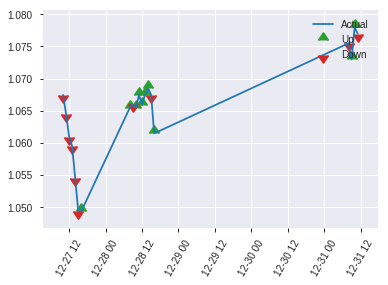


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19079095822237066
RMSE: 0.43679624337025913
LogLoss: 0.5620367092533285
Null degrees of freedom: 222
Residual degrees of freedom: 145
Null deviance: 309.15034943754756
Residual deviance: 250.66837232698447
AIC: 406.66837232698447
AUC: 0.7868404118404118
pr_auc: 0.7541032618094629
Gini: 0.5736808236808235
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2951094303853303: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   51   0.4595   (51.0/111.0)
1      9    103  0.0804   (9.0/112.0)
Total  69   154  0.2691   (60.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.295109     0.774436  153
max f2                       0.182322     0.864     176
max f0point5                 0.507875     0.724206  97
max accuracy                 0.304642     0.730942  151
max precision                0.952052     1         0
max recall                   0.0268828    1         215
max specificity              0.952052     1         0
max absolute_mcc             0.295109     0.497756  153
max min_per_class_accuracy   0.467473     0.711712  111
max mean_per_class_accuracy  0.304642     0.730132  151

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 45.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.928259           1.99107   1.99107            1                0.942545  1                           0.942545            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.897661           1.99107   1.99107            1                0.902719  1                           0.926615            0.0178571       0.0446429                  99.1071    99.1071
    3        0.0313901                   0.883213           0.995536  1.70663            0.5              0.888106  0.857143                    0.915612            0.00892857      0.0535714                  -0.446429  70.6633
    4        0.0403587                   0.880704           1.99107   1.76984            1                0.882597  0.888889                    0.908275            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.868473           1.99107   1.82515            1                0.874742  0.916667                    0.899892            0.0267857       0.0982143                  99.1071    82.5149
    6        0.103139                    0.782115           1.44805   1.6448             0.727273         0.820471  0.826087                    0.861908            0.0714286       0.169643                   44.8052    64.4798
    7        0.152466                    0.734709           1.62906   1.63971            0.818182         0.756194  0.823529                    0.827706            0.0803571       0.25                       62.9058    63.9706
    8        0.201794                    0.7067             1.26705   1.54861            0.636364         0.718292  0.777778                    0.800961            0.0625          0.3125                     26.7045    54.8611
    9        0.300448                    0.621258           1.44805   1.51559            0.727273         0.664219  0.761194                    0.75606             0.142857        0.455357                   44.8052    51.5592
    10       0.399103                    0.543357           1.44805   1.4989             0.727273         0.585062  0.752809                    0.713791            0.142857        0.598214                   44.8052    49.8896
    11       0.502242                    0.467473           1.12539   1.42219            0.565217         0.501952  0.714286                    0.670289            0.116071        0.714286                   12.5388    42.2194
    12       0.600897                    0.364529           1.08604   1.367              0.545455         0.412895  0.686567                    0.62803             0.107143        0.821429                   8.6039     36.7004
    13       0.699552                    0.293323           0.995536  1.31462            0.5              0.323764  0.660256                    0.585121            0.0982143       0.919643                   -0.446429  31.4618
    14       0.798206                    0.17096            0.452516  1.20807            0.227273         0.239868  0.606742                    0.542449            0.0446429       0.964286                   -54.7484   20.8066
    15       0.896861                    0.0928914          0.181006  1.09509            0.0909091        0.132798  0.55                        0.497387            0.0178571       0.982143                   -81.8994   9.50893
    16       1                           0.00316206         0.173137  1                  0.0869565        0.044565  0.502242                    

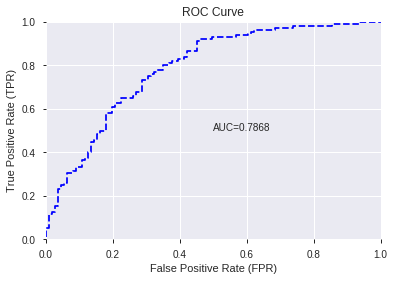

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


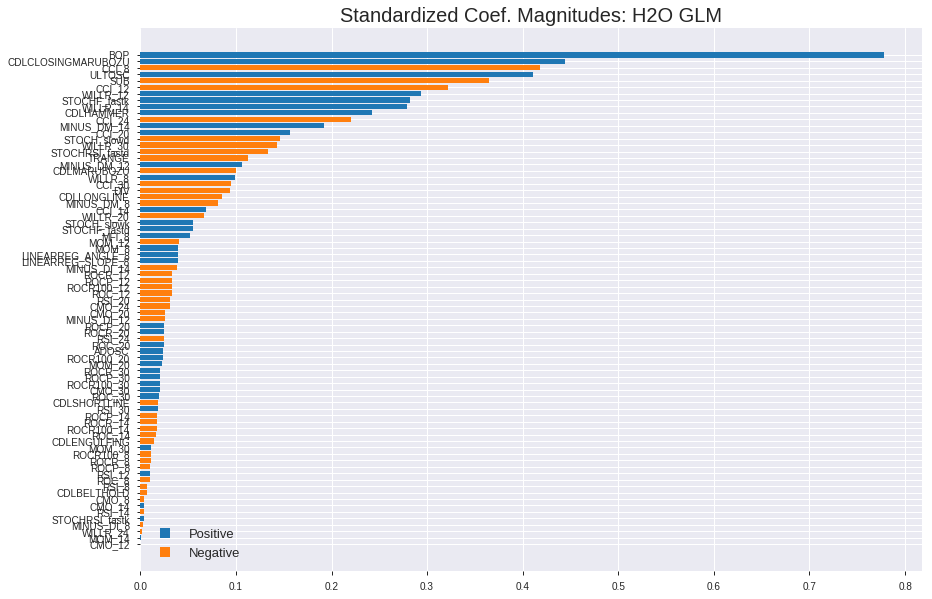

'log_likelihood'
--2019-08-27 14:43:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.180
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.180|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_144337_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_144337_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'ULTOSC',
 'SUB',
 'CCI_12',
 'WILLR_12',
 'STOCHF_fastk',
 'WILLR_14',
 'CDLHAMMER',
 'CCI_24',
 'MINUS_DM_14',
 'CCI_20',
 'STOCH_slowd',
 'WILLR_30',
 'STOCHRSI_fastd',
 'TRANGE',
 'MINUS_DM_12',
 'CDLMARUBOZU',
 'WILLR_8',
 'CCI_30',
 'DIV',
 'CDLLONGLINE',
 'MINUS_DM_8',
 'CCI_14',
 'WILLR_20',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MFI_8',
 'MOM_12',
 'MOM_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'MINUS_DI_14',
 'ROCR_12',
 'ROCP_12',
 'ROCR100_12',
 'ROC_12',
 'RSI_20',
 'CMO_24',
 'CMO_20',
 'MINUS_DI_12',
 'ROCP_20',
 'ROCR_20',
 'RSI_24',
 'ROC_20',
 'ADOSC',
 'ROCR100_20',
 'MOM_20',
 'ROCR_30',
 'ROCP_30',
 'ROCR100_30',
 'CMO_30',
 'ROC_30',
 'CDLSHORTLINE',
 'RSI_30',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'ROC_14',
 'CDLENGULFING',
 'MOM_30',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'RSI_12',
 'ROC_8',
 'RSI_8',
 'CDLBELTHOLD',
 'CMO_8',
 'CMO_14',
 'RSI_14',
 'STOCHRSI_fastk',
 'MINUS_DI_8',
 'WILLR_24',
 'MOM_14',
 'CMO_12']

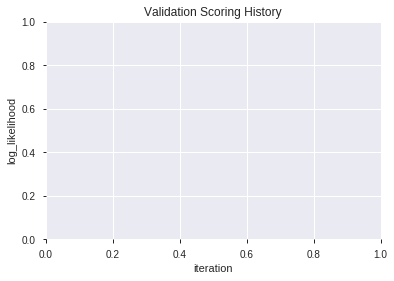

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_144348_model_4  0.798263  0.557469              0.287926  0.434614  0.188889
1  XGBoost_grid_1_AutoML_20190827_144348_model_3  0.797217  0.558118              0.306025  0.435813  0.189933
2  XGBoost_grid_1_AutoML_20190827_144348_model_6  0.795286  0.556635              0.283261  0.435778  0.189903
3               XGBoost_1_AutoML_20190827_144348  0.793999  0.559496              0.283221  0.436901  0.190882
4  XGBoost_grid_1_AutoML_20190827_144348_model_2  0.791667  0.563410              0.301601  0.438244  0.192058
5               XGBoost_2_AutoML_20190827_144348  0.784427  0.567640              0.292511  0.440721  0.194235
6  XGBoost_grid_1_AutoML_20190827_144348_model_7  0.784025  0.570784              0.265283  0.441637  0.195043
7               XGBoost_3_AutoML_20190827_144348  0.783382  0.568479              0.274212  0.441263  0.194713
8  XGBoost_grid_1_AutoML_20190827_144348_model_1  0.781210  0.570025              0.301560  0.441328  0.194771
9  XGBoost_grid_1_AutoML_20190827_144348_model_5  0.766570  0.596827              0.269908  0.453926  0.206049

variable  relative_importance  scaled_importance  percentage
0                 BOP          2024.151245           1.000000    0.394584
1                 DIV           532.922058           0.263282    0.103887
2        STOCHF_fastk           517.636475           0.255730    0.100907
3              ULTOSC           210.392822           0.103941    0.041014
4              TRANGE           164.273849           0.081157    0.032023
5               ADOSC           148.919556           0.073571    0.029030
6                 SUB           147.149857           0.072697    0.028685
7               CCI_8           137.936249           0.068145    0.026889
8      STOCHRSI_fastd           107.118156           0.052920    0.020881
9             WILLR_8            98.200699           0.048515    0.019143
10             CCI_24            77.884293           0.038478    0.015183
11        STOCH_slowd            74.556549           0.036833    0.014534
12     STOCHRSI_fastk            74.496773           0.036804    0.014522
13             CCI_20            69.120850           0.034148    0.013474
14              MFI_8            59.184219           0.029239    0.011537
15        MINUS_DI_14            47.675587           0.023553    0.009294
16             ROC_30            44.960590           0.022212    0.008765
17        STOCH_slowk            44.874207           0.022169    0.008748
18             CCI_12            43.367264           0.021425    0.008454
19             CCI_14            41.879890           0.020690    0.008164
20        MINUS_DM_12            35.840820           0.017707    0.006987
21           WILLR_12            35.628792           0.017602    0.006945
22           WILLR_20            33.668720           0.016634    0.006563
23             MOM_20            32.620197           0.016115    0.006359
24             CMO_30            32.038227           0.015828    0.006245
25             MOM_30            31.505093           0.015565    0.006142
26             CMO_24            28.475168           0.014068    0.005551
27             MOM_12            23.127064           0.011426    0.004508
28              ROC_8            20.343361           0.010050    0.003966
29  LINEARREG_ANGLE_8            19.723862           0.009744    0.003845
30             MOM_14            18.924747           0.009349    0.003689
31         MINUS_DI_8            18.732201           0.009254    0.003652
32         MINUS_DM_8            18.400784           0.009091    0.003587
33        MINUS_DM_14            17.561951           0.008676    0.003423
34        MINUS_DI_12            16.692425           0.008247    0.003254
35             ROC_12            13.308736           0.006575    0.002594
36             ROC_20            13.157600           0.006500    0.002565
37             CMO_20            11.203751           0.005535    0.002184
38           WILLR_14             8.939255           0.004416    0.001743
39             CMO_14             8.225872           0.004064    0.001604
40              CMO_8             7.574730           0.003742    0.001477
41           WILLR_30             7.381074           0.003647    0.001439
42              MOM_8             5.086746           0.002513    0.000992
43             CCI_30             4.978421           0.002460    0.000970

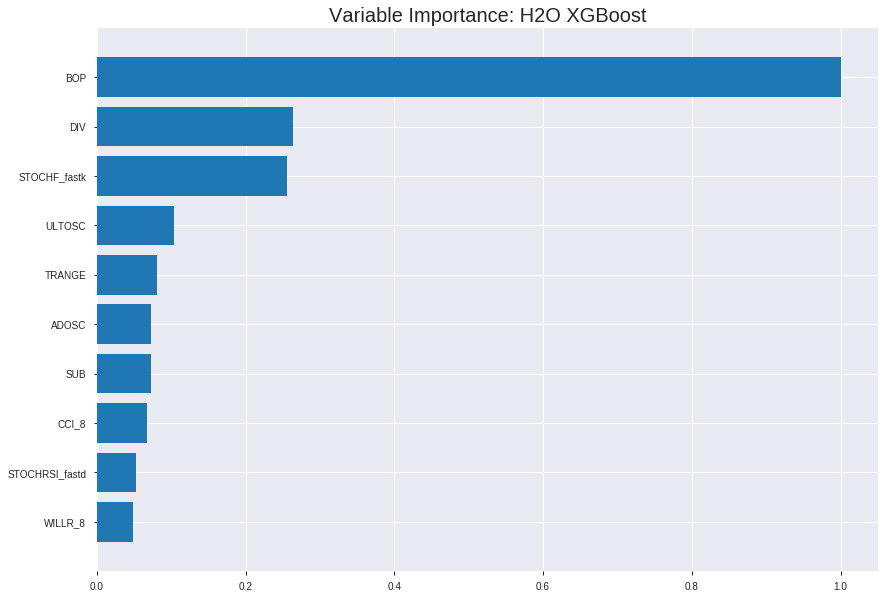

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_144348_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16487609232442474
RMSE: 0.4060493717818373
LogLoss: 0.5044127813224005
Mean Per-Class Error: 0.22812758694190216
AUC: 0.8472496005472544
pr_auc: 0.8482288752016506
Gini: 0.6944992010945088
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4825347661972046: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      556  213  0.277    (213.0/769.0)
1      144  643  0.183    (144.0/787.0)
Total  700  856  0.2294   (357.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482535     0.782715  214
max f2                       0.239076     0.864755  326
max f0point5                 0.556611     0.785067  174
max accuracy                 0.525287     0.771851  192
max precision                0.903464     1         0
max recall                   0.107109     1         395
max specificity              0.903464     1         0
max absolute_mcc             0.556611     0.543963  174
max min_per_class_accuracy   0.525287     0.770013  192
max mean_per_class_accuracy  0.525287     0.771872  192

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.87137            1.97713   1.97713            1                0.882947  1                           0.882947            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.862631           1.97713   1.97713            1                0.866542  1                           0.874744            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.85353            1.71351   1.893              0.866667         0.857759  0.957447                    0.869324            0.0165184       0.0571792                  71.3511   89.2995
    4        0.0404884                   0.847499           1.97713   1.91436            1                0.850147  0.968254                    0.864453            0.0203304       0.0775095                  97.7128   91.4362
    5        0.0501285                   0.839722           1.84532   1.90108            0.933333         0.844349  0.961538                    0.860587            0.0177891       0.0952986                  84.532    90.1085
    6        0.100257                    0.813155           1.90108   1.90108            0.961538         0.827074  0.961538                    0.84383             0.0952986       0.190597                   90.1085   90.1085
    7        0.150386                    0.777681           1.64761   1.81659            0.833333         0.795925  0.918803                    0.827862            0.0825921       0.273189                   64.7607   81.6592
    8        0.200514                    0.74098            1.79969   1.81237            0.910256         0.760127  0.916667                    0.810928            0.090216        0.363405                   79.9694   81.2368
    9        0.300129                    0.671791           1.61997   1.74851            0.819355         0.706077  0.884368                    0.776127            0.161372        0.524778                   61.997    74.851
    10       0.400386                    0.602583           1.21669   1.61534            0.615385         0.637911  0.817014                    0.741518            0.121982        0.64676                    21.6694   61.5342
    11       0.5                         0.52607            1.21179   1.53494            0.612903         0.562469  0.77635                     0.705846            0.120712        0.767471                   21.1788   53.4943
    12       0.600257                    0.437566           0.81113   1.41405            0.410256         0.482435  0.715203                    0.668531            0.0813215       0.848793                   -18.887   41.4049
    13       0.699871                    0.348649           0.663295  1.30719            0.335484         0.396977  0.661157                    0.62988             0.0660737       0.914867                   -33.6705  30.7192
    14       0.800129                    0.251939           0.45626   1.20057            0.230769         0.298588  0.607229                    0.588369            0.0457433       0.96061                    -54.374   20.0569
    15       0.899743                    0.180804           0.280625  1.09872            0.141935         0.217227  0.555714                    0.547278            0.0279543       0.988564                   -71.9375  9.87185
    16       1                           0.0942737          0.114065  1                  0.0576923        0.138744  0.505784                    0.50632           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1902457174872567
RMSE: 0.4361716605732847
LogLoss: 0.5620666648214475
Mean Per-Class Error: 0.27205793237183373
AUC: 0.7878236981375996
pr_auc: 0.7493336541750963
Gini: 0.5756473962751991
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3243958652019501: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  96   0.4324   (96.0/222.0)
1      27   196  0.1211   (27.0/223.0)
Total  153  292  0.2764   (123.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324396     0.761165  258
max f2                       0.206014     0.857941  322
max f0point5                 0.473669     0.725883  184
max accuracy                 0.392098     0.72809   223
max precision                0.875578     1         0
max recall                   0.124989     1         383
max specificity              0.875578     1         0
max absolute_mcc             0.324396     0.470008  258
max min_per_class_accuracy   0.439557     0.716216  199
max mean_per_class_accuracy  0.392098     0.727942  223

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 46.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.860916           1.59641   1.59641            0.8              0.869995  0.8                         0.869995            0.0179372       0.0179372                  59.6413   59.6413
    2        0.0202247                   0.848215           1.49664   1.55207            0.75             0.853355  0.777778                    0.8626              0.0134529       0.0313901                  49.6637   55.2068
    3        0.0314607                   0.842479           1.59641   1.56791            0.8              0.84515   0.785714                    0.856368            0.0179372       0.0493274                  59.6413   56.7905
    4        0.0404494                   0.833357           1.99552   1.66293            1                0.83662   0.833333                    0.851979            0.0179372       0.0672646                  99.5516   66.293
    5        0.0516854                   0.826174           1.19731   1.56171            0.6              0.830602  0.782609                    0.847332            0.0134529       0.0807175                  19.7309   56.1708
    6        0.101124                    0.793334           1.7234    1.64076            0.863636         0.810089  0.822222                    0.829124            0.0852018       0.165919                   72.34     64.0757
    7        0.150562                    0.756425           1.7234    1.66789            0.863636         0.776968  0.835821                    0.811998            0.0852018       0.251121                   72.34     66.7894
    8        0.2                         0.724484           1.45128   1.61435            0.727273         0.743283  0.808989                    0.795012            0.0717489       0.32287                    45.1284   61.435
    9        0.301124                    0.643161           1.37469   1.53387            0.688889         0.691268  0.768657                    0.760173            0.139013        0.461883                   37.4689   53.3867
    10       0.4                         0.540148           1.36058   1.49103            0.681818         0.595976  0.747191                    0.719585            0.134529        0.596413                   36.0579   49.1031
    11       0.501124                    0.439532           1.19731   1.43176            0.6              0.484591  0.717489                    0.672165            0.121076        0.717489                   19.7309   43.176
    12       0.6                         0.368486           1.08846   1.37519            0.545455         0.40681   0.689139                    0.628436            0.107623        0.825112                   8.84631   37.5187
    13       0.698876                    0.285792           0.725642  1.28329            0.363636         0.328274  0.643087                    0.585969            0.0717489       0.896861                   -27.4358  28.329
    14       0.8                         0.212059           0.620827  1.19955            0.311111         0.24256   0.601124                    0.542561            0.0627803       0.959641                   -37.9173  19.9552
    15       0.898876                    0.146779           0.181411  1.08756            0.0909091        0.177711  0.545                       0.502427            0.0179372       0.977578                   -81.8589  8.75561
    16       1                           0.105175           0.221724  1                  0.111111         0.126568  0.501124                    0.464419            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:43:58  3.857 sec   0                  0.5              0.693147            0.5             0                  1                0.494216                         0.5                0.693147              0.5               0                    1                  0.498876
    2019-08-27 14:43:59  3.991 sec   5                  0.47528          0.644625            0.805216        0.788766           1.76529          0.283419                         0.477228           0.648333              0.769674          0.735954             1.66293            0.316854
    2019-08-27 14:43:59  4.063 sec   10                 0.458997         0.613093            0.808116        0.796933           1.76901          0.273136                         0.463959           0.622328              0.772997          0.744723             1.77379            0.319101
    2019-08-27 14:43:59  4.124 sec   15                 0.447274         0.590051            0.813164        0.808015           1.86083          0.276992                         0.454609           0.603549              0.775361          0.745221             1.74608            0.316854
    2019-08-27 14:43:59  4.187 sec   20                 0.438666         0.572836            0.818575        0.810452           1.86083          0.271851                         0.448207           0.590274              0.780269          0.752725             1.99552            0.301124
    2019-08-27 14:43:59  4.261 sec   25                 0.431939         0.559002            0.821807        0.816508           1.86083          0.268638                         0.443808           0.580904              0.781037          0.747941             1.99552            0.307865
    2019-08-27 14:43:59  4.330 sec   30                 0.427218         0.549127            0.82523         0.820881           1.86729          0.249357                         0.440958           0.574553              0.783713          0.750364             1.99552            0.301124
    2019-08-27 14:43:59  4.406 sec   35                 0.423133         0.5405              0.82786         0.825229           1.86083          0.242931                         0.43955            0.571064              0.782845          0.742212             1.19731            0.307865
    2019-08-27 14:43:59  4.484 sec   40                 0.419546         0.532646            0.830022        0.82781            1.85356          0.260925                         0.438279           0.567989              0.783693          0.736562             1.19731            0.310112
    2019-08-27 14:43:59  4.555 sec   45                 0.416714         0.526599            0.832473        0.832014           1.85356          0.260283                         0.43784            0.566795              0.784541          0.739808             1.19731            0.285393
    2019-08-27 14:43:59  4.629 sec   50                 0.413814         0.52043             0.836015        0.837313           1.97713          0.245501                         0.437519           0.565653              0.785238          0.744245             1.59641            0.292135
    2019-08-27 14:43:59  4.708 sec   55                 0.411115         0.514723            0.839119        0.839694           1.97713          0.242288                         0.43698            0.564199              0.786107          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2024.1512451171875     1.0                    0.3945836393141531
DIV           532.9220581054688      0.2632817381561897     0.10388666640662526
STOCHF_fastk  517.636474609375       0.255730136697076      0.10090692802023811
ULTOSC        210.392822265625       0.10394125575998862    0.041013518972659486
TRANGE        164.2738494873047      0.0811569045957305     0.032023186770854854
---           ---                    ---                    ---
CMO_14        8.225872039794922      0.0040638623520045745  0.0016035335965257388
CMO_8         7.574729919433594      0.0037421758565255123  0.0014766013684213946
WILLR_30      7.381073951721191      0.003646503179802588   0.0014388504954571367
MOM_8         5.086745738983154      0.0025130265098785437  0.0009915991459608202
CCI_30        4.978421211242676      0.0024595104853216893  0.0009704825982295511


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7443946188340808)

('F1', 0.762962962962963)

('auc', 0.7982625482625483)

('logloss', 0.557469292980254)

('mean_per_class_error', 0.25583172458172454)

('rmse', 0.4346137323915047)

('mse', 0.18888909638327445)

xgboost prediction progress: |████████████████████████████████████████████| 100%


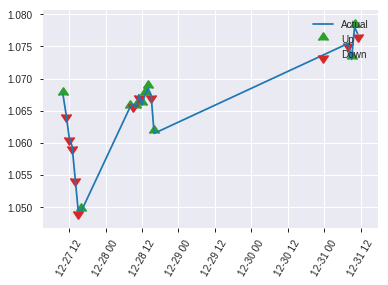


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18888909638327445
RMSE: 0.4346137323915047
LogLoss: 0.557469292980254
Mean Per-Class Error: 0.25583172458172454
AUC: 0.7982625482625483
pr_auc: 0.7623298160632429
Gini: 0.5965250965250966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2634983956813812: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   55   0.4955   (55.0/111.0)
1      9    103  0.0804   (9.0/112.0)
Total  65   158  0.287    (64.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.263498     0.762963  157
max f2                       0.195601     0.874404  180
max f0point5                 0.45651      0.744485  107
max accuracy                 0.412011     0.744395  122
max precision                0.886576     1         0
max recall                   0.11057      1         216
max specificity              0.886576     1         0
max absolute_mcc             0.393053     0.49187   124
max min_per_class_accuracy   0.442973     0.72973   111
max mean_per_class_accuracy  0.412011     0.744168  122

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 44.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.846348           1.99107    1.99107            1                0.871436  1                           0.871436            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.841987           1.99107    1.99107            1                0.844545  1                           0.86068             0.0178571       0.0446429                  99.1071    99.1071
    3        0.0313901                   0.831415           0.995536   1.70663            0.5              0.837865  0.857143                    0.854161            0.00892857      0.0535714                  -0.446429  70.6633
    4        0.0403587                   0.818029           1.99107    1.76984            1                0.827939  0.888889                    0.848334            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.806477           1.99107    1.82515            1                0.811034  0.916667                    0.839009            0.0267857       0.0982143                  99.1071    82.5149
    6        0.103139                    0.767792           1.44805    1.6448             0.727273         0.779138  0.826087                    0.810375            0.0714286       0.169643                   44.8052    64.4798
    7        0.152466                    0.727036           1.81006    1.69827            0.909091         0.743314  0.852941                    0.788679            0.0892857       0.258929                   81.0065    69.8267
    8        0.201794                    0.674148           1.26705    1.59286            0.636364         0.698402  0.8                         0.766611            0.0625          0.321429                   26.7045    59.2857
    9        0.300448                    0.594174           1.44805    1.54531            0.727273         0.636307  0.776119                    0.723825            0.142857        0.464286                   44.8052    54.5309
    10       0.399103                    0.507208           1.35755    1.4989             0.681818         0.546009  0.752809                    0.67987             0.133929        0.598214                   35.7549    49.8896
    11       0.502242                    0.442973           1.29852    1.45775            0.652174         0.479064  0.732143                    0.638633            0.133929        0.732143                   29.8525    45.7749
    12       0.600897                    0.349003           0.995536   1.38186            0.5              0.40139   0.69403                     0.599683            0.0982143       0.830357                   -0.446429  38.1863
    13       0.699552                    0.266506           0.814529   1.30185            0.409091         0.31474   0.653846                    0.559499            0.0803571       0.910714                   -18.5471   30.1854
    14       0.798206                    0.208831           0.633523   1.21925            0.318182         0.243552  0.61236                     0.520449            0.0625          0.973214                   -36.6477   21.9252
    15       0.896861                    0.153958           0.181006   1.10504            0.0909091        0.180802  0.555                       0.483088            0.0178571       0.991071                   -81.8994   10.5045
    16       1                           0.098265           0.0865683  1                  0.0434783        0.125314  0.502242  

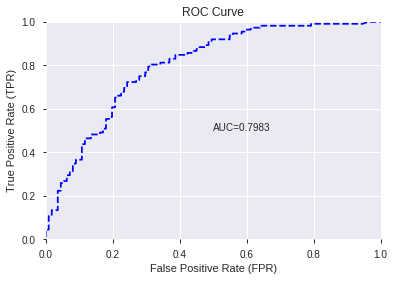

This function is available for GLM models only


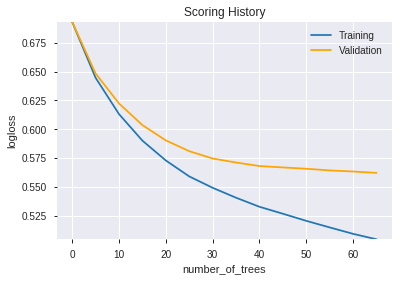

--2019-08-27 14:44:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.135.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.135.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_144348_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_144348_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'ULTOSC',
 'TRANGE',
 'ADOSC',
 'SUB',
 'CCI_8',
 'STOCHRSI_fastd',
 'WILLR_8',
 'CCI_24',
 'STOCH_slowd',
 'STOCHRSI_fastk',
 'CCI_20',
 'MFI_8',
 'MINUS_DI_14',
 'ROC_30',
 'STOCH_slowk',
 'CCI_12',
 'CCI_14',
 'MINUS_DM_12',
 'WILLR_12',
 'WILLR_20',
 'MOM_20',
 'CMO_30',
 'MOM_30',
 'CMO_24',
 'MOM_12',
 'ROC_8',
 'LINEARREG_ANGLE_8',
 'MOM_14',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MINUS_DM_14',
 'MINUS_DI_12',
 'ROC_12',
 'ROC_20',
 'CMO_20',
 'WILLR_14',
 'CMO_14',
 'CMO_8',
 'WILLR_30',
 'MOM_8',
 'CCI_30']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

84

['BBANDS_lowerband_20_2_4',
 'BBANDS_middleband_20_3_3',
 'BBANDS_lowerband_20_3_3',
 'MA_20_5',
 'MAVP_20_5',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_upperband_20_5_4',
 'BBANDS_upperband_20_5_5',
 'MAVP_20_6',
 'BBANDS_upperband_20_6_3',
 'BBANDS_lowerband_24_7_5',
 'BBANDS_upperband_30_7_2',
 'BOP',
 'ADXR_8',
 'CMO_8',
 'MACDFIX_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'WILLR_8',
 'aroonup_12',
 'AROONOSC_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROCR_12',
 'ROCR100_12',
 'WILLR_12',
 'MFI_14',
 'MINUS_DM_14',
 'MOM_14',
 'PLUS_DI_14',
 'ROCR_14',
 'aroonup_20',
 'CMO_20',
 'DX_20',
 'MINUS_DM_20',
 'PLUS_DM_20',
 'ROCR100_20',
 'WILLR_20',
 'AROONOSC_24',
 'CCI_24',
 'MACDFIX_24',
 'MACDFIX_signal_24',
 'MINUS_DM_24',
 'ROCR_24',
 'ROCR100_24',
 'WILLR_24',
 'aroondown_30',
 'CCI_30',
 'CMO_30',
 'MFI_30',
 'PLUS_DI_30',
 'ROC_30',
 'ROCR100_30',
 'RSI_30',
 'WILLR_30',
 'APO',
 'MACDEXT_signal',
 'STOCH_slowk',
 'STOCHF

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_144520_model_8  0.780968  0.573480              0.260376  0.442840  0.196107
1               DeepLearning_1_AutoML_20190827_144520  0.779440  0.591160              0.256073  0.443968  0.197107
2  DeepLearning_grid_1_AutoML_20190827_144520_model_9  0.777671  0.580430              0.287926  0.444090  0.197216
3  DeepLearning_grid_1_AutoML_20190827_144520_model_3  0.771718  0.627474              0.283221  0.445851  0.198783
4  DeepLearning_grid_1_AutoML_20190827_144520_model_6  0.766168  0.578208              0.256355  0.444470  0.197554
5  DeepLearning_grid_1_AutoML_20190827_144520_model_2  0.765685  0.598794              0.332971  0.450500  0.202951
6  DeepLearning_grid_1_AutoML_20190827_144520_model_5  0.762870  0.583546              0.256314  0.446967  0.199779
7  DeepLearning_grid_1_AutoML_20190827_144520_model_7  0.745817  0.681060              0.364302  0.470668  0.221529
8  DeepLearning_grid_1_AutoML_20190827_144520_model_4  0.730936  0.807047              0.323480  0.496944  0.246953
9  DeepLearning_grid_1_AutoML_20190827_144520_model_1  0.724582  0.977532              0.327944  0.517686  0.267999

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.034275
1                  BOP             0.943414           0.943414    0.032336
2               TRANGE             0.868357           0.868357    0.029763
3               ULTOSC             0.629292           0.629292    0.021569
4         CDLSHORTLINE             0.535837           0.535837    0.018366
..                 ...                  ...                ...         ...
79             MA_20_5             0.257649           0.257649    0.008831
80   LINEARREG_ANGLE_8             0.254783           0.254783    0.008733
81            WILLR_20             0.245436           0.245436    0.008412
82           MAVP_20_5             0.242001           0.242001    0.008295
83               CMO_8             0.228140           0.228140    0.007820

[84 rows x 4 columns]

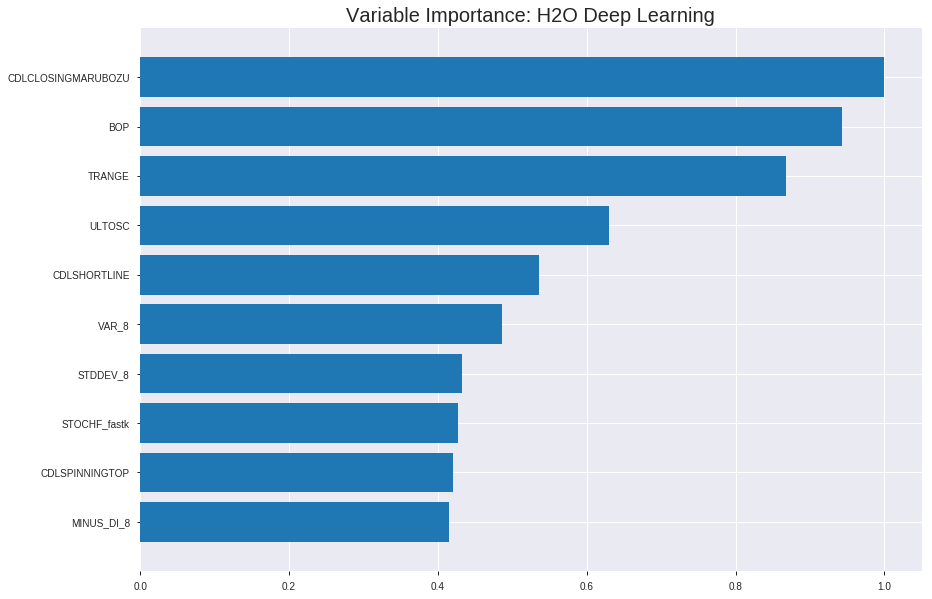

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_144520_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17254540602773238
RMSE: 0.41538585198310785
LogLoss: 0.5165924527383486
Mean Per-Class Error: 0.24472449740004598
AUC: 0.8388441564235473
pr_auc: 0.8430793453485012
Gini: 0.6776883128470945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.414518795029063: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      440  329   0.4278   (329.0/769.0)
1      79   708   0.1004   (79.0/787.0)
Total  519  1037  0.2622   (408.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414519     0.776316  250
max f2                       0.288064     0.862069  310
max f0point5                 0.549019     0.776014  166
max accuracy                 0.473676     0.755784  214
max precision                0.987859     1         0
max recall                   0.0619858    1         393
max specificity              0.987859     1         0
max absolute_mcc             0.473676     0.512779  214
max min_per_class_accuracy   0.489465     0.745124  205
max mean_per_class_accuracy  0.473676     0.755276  214

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.979427           1.97713   1.97713            1                0.983182  1                           0.983182            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.972798           1.97713   1.97713            1                0.975945  1                           0.979563            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.9667             1.97713   1.97713            1                0.970604  1                           0.976704            0.0190597       0.0597205                  97.7128   97.7128
    4        0.0404884                   0.959114           1.85356   1.94575            0.9375           0.962872  0.984127                    0.973191            0.0190597       0.0787802                  85.3558   94.5745
    5        0.0501285                   0.94044            1.97713   1.95178            1                0.953124  0.987179                    0.969332            0.0190597       0.0978399                  97.7128   95.1781
    6        0.100257                    0.85038            1.87574   1.91376            0.948718         0.897095  0.967949                    0.933214            0.094028        0.191868                   87.5737   91.3759
    7        0.150386                    0.747938           1.77435   1.86729            0.897436         0.794744  0.944444                    0.887057            0.0889454       0.280813                   77.4346   86.7288
    8        0.200514                    0.671211           1.749     1.83772            0.884615         0.71236   0.929487                    0.843383            0.0876747       0.368488                   74.8998   83.7715
    9        0.300129                    0.568221           1.49241   1.72311            0.754839         0.615237  0.87152                     0.76766             0.148666        0.517154                   49.2413   72.3108
    10       0.400386                    0.519984           1.15332   1.58043            0.583333         0.539016  0.799358                    0.710407            0.115629        0.632783                   15.3325   58.0433
    11       0.5                         0.489485           1.10974   1.48666            0.56129          0.505179  0.751928                    0.66952             0.110546        0.743329                   10.9743   48.6658
    12       0.600257                    0.445885           1.03926   1.41193            0.525641         0.470102  0.714133                    0.636212            0.104193        0.847522                   3.92598   41.1932
    13       0.699871                    0.395909           0.663295  1.30538            0.335484         0.42191   0.660239                    0.60571             0.0660737       0.913596                   -33.6705  30.5377
    14       0.800129                    0.323512           0.468934  1.20057            0.237179         0.363791  0.607229                    0.575398            0.047014        0.96061                    -53.1066  20.0569
    15       0.899743                    0.211288           0.267869  1.09731            0.135484         0.265108  0.555                       0.541044            0.0266836       0.987294                   -73.2131  9.73062
    16       1                           0.0282627          0.126739  1                  0.0641026        0.144639  0.505784                    0.501302         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19780359347346926
RMSE: 0.44475115904679696
LogLoss: 0.5748350813927684
Mean Per-Class Error: 0.28304649941421234
AUC: 0.7771785238152952
pr_auc: 0.7700841024619728
Gini: 0.5543570476305903
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35285762189104913: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  107  0.482    (107.0/222.0)
1      29   194  0.13     (29.0/223.0)
Total  144  301  0.3056   (136.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352858     0.740458  267
max f2                       0.171655     0.849421  358
max f0point5                 0.478816     0.724638  182
max accuracy                 0.478816     0.716854  182
max precision                0.990559     1         0
max recall                   0.0946772    1         383
max specificity              0.990559     1         0
max absolute_mcc             0.478816     0.435582  182
max min_per_class_accuracy   0.466353     0.704036  196
max mean_per_class_accuracy  0.478816     0.716954  182

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 45.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.975235           1.99552   1.99552            1                0.982372  1                           0.982372            0.0224215       0.0224215                  99.5516    99.5516
    2        0.0202247                   0.971082           1.99552   1.99552            1                0.972536  1                           0.978               0.0179372       0.0403587                  99.5516    99.5516
    3        0.0314607                   0.968685           1.99552   1.99552            1                0.970061  1                           0.975165            0.0224215       0.0627803                  99.5516    99.5516
    4        0.0404494                   0.954604           1.99552   1.99552            1                0.961399  1                           0.972106            0.0179372       0.0807175                  99.5516    99.5516
    5        0.0516854                   0.949881           1.99552   1.99552            1                0.952154  1                           0.967769            0.0224215       0.103139                   99.5516    99.5516
    6        0.101124                    0.840267           1.54199   1.77379            0.772727         0.887483  0.888889                    0.928518            0.0762332       0.179372                   54.1989    77.3792
    7        0.150562                    0.698799           1.54199   1.69768            0.772727         0.746609  0.850746                    0.868787            0.0762332       0.255605                   54.1989    69.7678
    8        0.2                         0.576434           1.36058   1.61435            0.681818         0.629641  0.808989                    0.809672            0.0672646       0.32287                    36.0579    61.435
    9        0.301124                    0.525176           1.41903   1.54876            0.711111         0.546834  0.776119                    0.721406            0.143498        0.466368                   41.9033    54.8758
    10       0.4                         0.493288           1.26987   1.47982            0.636364         0.510978  0.741573                    0.66939             0.125561        0.591928                   26.9874    47.9821
    11       0.501124                    0.46561            1.10862   1.40491            0.555556         0.480355  0.704036                    0.631244            0.112108        0.704036                   10.862     40.4915
    12       0.6                         0.401689           0.997758  1.33782            0.5              0.431907  0.670412                    0.598394            0.0986547       0.802691                   -0.224215  33.7818
    13       0.698876                    0.341367           0.725642  1.25121            0.363636         0.366502  0.62701                     0.565586            0.0717489       0.874439                   -27.4358   25.1208
    14       0.8                         0.267976           0.620827  1.17152            0.311111         0.301476  0.587079                    0.532202            0.0627803       0.93722                    -37.9173   17.1525
    15       0.898876                    0.174061           0.408174  1.08756            0.204545         0.219237  0.545                       0.497776            0.0403587       0.977578                   -59.1826   8.75561
    16       1                           0.0425567          0.221724  1                  0.111111         0.112287  0.501124                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:51:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:51:39  1 min 14.981 sec  598 obs/sec       0.526992  1             820        0.51916          0.826194            -0.0782506     0.681313        0.698112           1.85356          0.426093                         0.544416           0.96008               -0.185559        0.654648          0.650933             1.59641            0.417978
    2019-08-27 14:51:49  1 min 24.720 sec  985 obs/sec       6.44409   12            10027      0.439135         0.569047            0.228538       0.783175        0.794031           1.97713          0.308483                         0.45856            0.613808              0.158887         0.752171          0.75592              1.99552            0.301124
    2019-08-27 14:51:59  1 min 34.328 sec  1113 obs/sec      13.4878   25            20987      0.423574         0.533745            0.282243       0.811871        0.809489           1.85356          0.292416                         0.441117           0.576288              0.221659         0.778875          0.771344             1.99552            0.307865
    2019-08-27 14:52:08  1 min 43.913 sec  1194 obs/sec      21.1131   39            32852      0.42576          0.536509            0.274817       0.8248          0.832216           1.97713          0.275064                         0.452472           0.599803              0.181074         0.780713          0.767116             1.59641            0.316854
    2019-08-27 14:52:18  1 min 53.480 sec  1257 obs/sec      29.2198   54            45466      0.417435         0.519946            0.302897       0.834462        0.840129           1.97713          0.249357                         0.443812           0.578839              0.212118         0.777684          0.774148             1.99552            0.307865
    2019-08-27 14:52:27  2 min  2.877 sec  1301 obs/sec      37.2995   69            58038      0.415386         0.516592            0.309726       0.838844        0.843079           1.97713          0.262211                         0.444751           0.574835              0.208782         0.777179          0.770084             1.99552            0.305618
    2019-08-27 14:52:37  2 min 12.570 sec  1341 obs/sec      45.9781   85            71542      0.407693         0.496337            0.335055       0.84049         0.852651           1.97713          0.275707                         0.448823           0.587118              0.194227         0.765453          0.760395             1.99552            0.359551
    2019-08-27 14:52:47  2 min 22.572 sec  1375 obs/sec      55.1639   102           85835      0.394051         0.465852            0.378813       0.862275        0.858946           1.97713          0.239717                         0.446308           0.584893              0.203233         0.768796          0.761672             1.99552            0.305618
    2019-08-27 14:52:48

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.034275073719520766
BOP                 0.9434137344360352     0.9434137344360352   0.03233557529580349
TRANGE              0.8683574795722961     0.8683574795722961   0.029763016627237696
ULTOSC              0.6292915940284729     0.6292915940284729   0.021569015776400642
CDLSHORTLINE        0.5358374714851379     0.5358374714851379   0.01836586883683471
---                 ---                    ---                  ---
MA_20_5             0.2576489746570587     0.2576489746570587   0.008830937600129625
LINEARREG_ANGLE_8   0.25478309392929077    0.25478309392929077  0.008732709326914025
WILLR_20            0.2454359233379364     0.2454359233379364   0.008412334365826417
MAVP_20_5           0.24200069904327393    0.24200069904327393  0.008294591799883773
CMO_8               0.22813966870307922    0.22813966870307922  0.007819503963145085


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7399103139013453)

('F1', 0.7563025210084034)

('auc', 0.7809684684684685)

('logloss', 0.5734801411719281)

('mean_per_class_error', 0.2601351351351351)

('rmse', 0.4428400806942564)

('mse', 0.19610733706929553)

deeplearning prediction progress: |███████████████████████████████████████| 100%


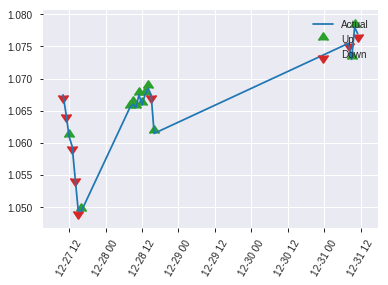


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19610733706929553
RMSE: 0.4428400806942564
LogLoss: 0.5734801411719281
Mean Per-Class Error: 0.2601351351351351
AUC: 0.7809684684684685
pr_auc: 0.7609062610009908
Gini: 0.5619369369369369
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42812390593177435: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   36   0.3243   (36.0/111.0)
1      22   90   0.1964   (22.0/112.0)
Total  97   126  0.2601   (58.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428124     0.756303  125
max f2                       0.171296     0.860215  202
max f0point5                 0.464912     0.739437  113
max accuracy                 0.464912     0.73991   113
max precision                0.987142     1         0
max recall                   0.171296     1         202
max specificity              0.987142     1         0
max absolute_mcc             0.428124     0.483347  125
max min_per_class_accuracy   0.466397     0.72973   111
max mean_per_class_accuracy  0.464912     0.739865  113

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 46.52 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.977288           1.99107    1.99107            1                0.980865  1                           0.980865            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.973809           1.99107    1.99107            1                0.975599  1                           0.978758            0.0178571       0.0446429                  99.1071    99.1071
    3        0.0313901                   0.970439           0.995536   1.70663            0.5              0.973568  0.857143                    0.977275            0.00892857      0.0535714                  -0.446429  70.6633
    4        0.0403587                   0.95571            1.99107    1.76984            1                0.968013  0.888889                    0.975217            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.930512           1.99107    1.82515            1                0.943609  0.916667                    0.967315            0.0267857       0.0982143                  99.1071    82.5149
    6        0.103139                    0.807304           1.62906    1.73137            0.818182         0.862367  0.869565                    0.917123            0.0803571       0.178571                   62.9058    73.1366
    7        0.152466                    0.682416           1.62906    1.69827            0.818182         0.738624  0.852941                    0.859373            0.0803571       0.258929                   62.9058    69.8267
    8        0.201794                    0.588273           1.44805    1.6371             0.727273         0.645907  0.822222                    0.807192            0.0714286       0.330357                   44.8052    63.7103
    9        0.300448                    0.517373           1.17654    1.48587            0.590909         0.54134   0.746269                    0.719898            0.116071        0.446429                   17.6542    48.5874
    10       0.399103                    0.501995           1.53856    1.4989             0.772727         0.509     0.752809                    0.667766            0.151786        0.598214                   53.8555    49.8896
    11       0.502242                    0.466397           1.29852    1.45775            0.652174         0.486292  0.732143                    0.630499            0.133929        0.732143                   29.8525    45.7749
    12       0.600897                    0.412478           0.814529   1.35215            0.409091         0.438457  0.679104                    0.59897             0.0803571       0.8125                     -18.5471   35.2146
    13       0.699552                    0.357685           0.543019   1.23804            0.272727         0.384524  0.621795                    0.568727            0.0535714       0.866071                   -45.6981   23.8038
    14       0.798206                    0.287512           0.633523   1.16332            0.318182         0.321284  0.58427                     0.538144            0.0625          0.928571                   -36.6477   16.3323
    15       0.896861                    0.185257           0.633523   1.10504            0.318182         0.240489  0.555                       0.505402            0.0625          0.991071                   -36.6477   10.5045
    16       1                           0.004507           0.0865683  1                  0.0434783        0.115197  0.502242  

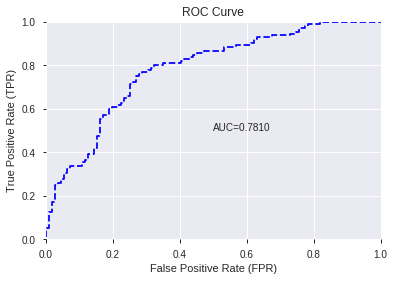

This function is available for GLM models only


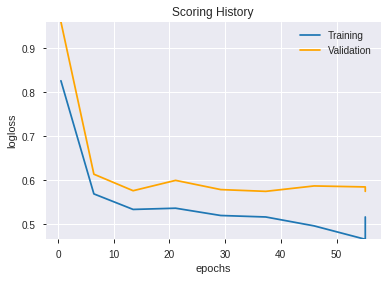

--2019-08-27 14:53:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_144520_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_144520_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'TRANGE',
 'ULTOSC',
 'CDLSHORTLINE',
 'VAR_8',
 'STDDEV_8',
 'STOCHF_fastk',
 'CDLSPINNINGTOP',
 'MINUS_DI_8',
 'aroondown_30',
 'DX_20',
 'STOCHRSI_fastd',
 'ADXR_8',
 'AROONOSC_12',
 'AD',
 'WILLR_8',
 'STOCH_slowk',
 'PLUS_DM_8',
 'MFI_14',
 'aroonup_12',
 'STOCHRSI_fastk',
 'aroonup_20',
 'AROONOSC_24',
 'CDLHIGHWAVE',
 'PLUS_DI_8',
 'PLUS_DM_20',
 'MFI_30',
 'MFI_8',
 'BBANDS_upperband_20_5_5',
 'WILLR_12',
 'BBANDS_upperband_20_5_4',
 'ROCR100_20',
 'MINUS_DM_12',
 'CCI_24',
 'ATR_24',
 'ROCR100_12',
 'RSI_30',
 'ROCR100_30',
 'MINUS_DM_24',
 'MOM_12',
 'NATR_8',
 'NATR_30',
 'MINUS_DM_14',
 'PLUS_DI_14',
 'ROCR_12',
 'ROC_30',
 'BBANDS_lowerband_24_7_5',
 'BBANDS_upperband_20_6_3',
 'ROCR_14',
 'MOM_14',
 'CCI_30',
 'MACDFIX_signal_24',
 'MINUS_DM_20',
 'BBANDS_lowerband_20_2_4',
 'MACDFIX_hist_8',
 'ROCR_24',
 'APO',
 'LINEARREG_SLOPE_8',
 'MACDEXT_signal',
 'ROCR100_24',
 'WILLR_30',
 'NATR_20',
 'ROCR_8',
 'BBANDS_upperband_30_7_2',
 'CMO_30',

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_145405_model_1  0.778153  0.576007              0.274292  0.444145  0.197265

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.575757           1.000000    0.101350
1                    TRANGE             0.395821           0.687479    0.069676
2                    ULTOSC             0.335647           0.582967    0.059084
3        CDLCLOSINGMARUBOZU             0.333914           0.579956    0.058779
4              STOCHF_fastk             0.169535           0.294456    0.029843
..                      ...                  ...                ...         ...
79                      APO             0.003212           0.005578    0.000565
80           MACDFIX_hist_8             0.002225           0.003864    0.000392
81              CDLHIGHWAVE             0.000260           0.000451    0.000046
82                  WILLR_8             0.000112           0.000195    0.000020
83  BBANDS_upperband_30_7_2             0.000037           0.000064    0.000006

[84 rows x 4 columns]

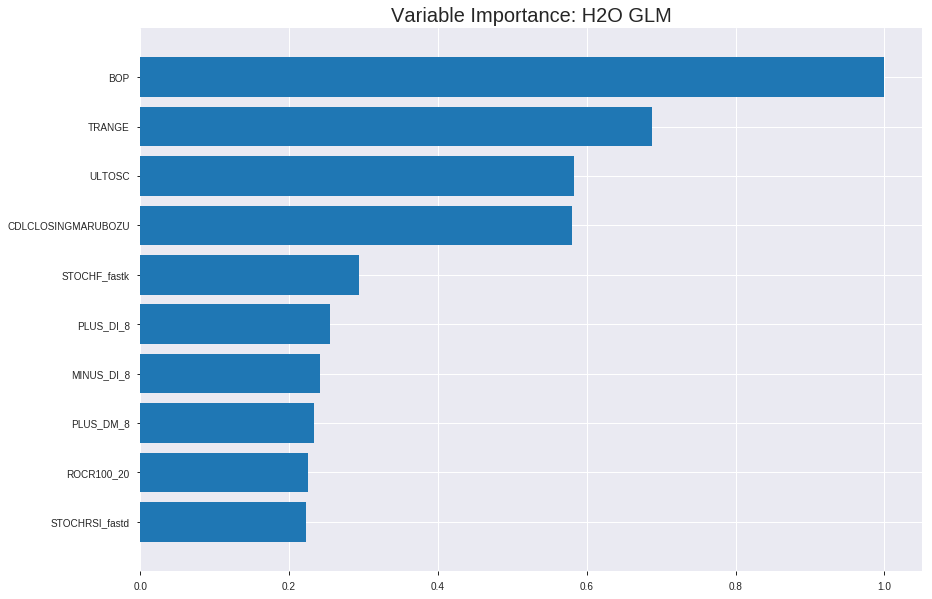

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_145405_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1834975778815503
RMSE: 0.4283661726625368
LogLoss: 0.5449821345558493
Null degrees of freedom: 1555
Residual degrees of freedom: 1471
Null deviance: 2156.8657950370343
Residual deviance: 1695.984402737803
AIC: 1865.984402737803
AUC: 0.8007561099333611
pr_auc: 0.8055950188720776
Gini: 0.6015122198667222
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3851472619656575: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      396  373   0.485    (373.0/769.0)
1      99   688   0.1258   (99.0/787.0)
Total  495  1061  0.3033   (472.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385147     0.744589  259
max f2                       0.249542     0.852643  318
max f0point5                 0.640308     0.738899  136
max accuracy                 0.50545      0.724936  204
max precision                0.95459      1         0
max recall                   0.0291338    1         397
max specificity              0.95459      1         0
max absolute_mcc             0.50545      0.450066  204
max min_per_class_accuracy   0.524907     0.720457  195
max mean_per_class_accuracy  0.50545      0.724601  204

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.928241           1.85356   1.85356            0.9375           0.940506   0.9375                      0.940506            0.0190597       0.0190597                  85.3558   85.3558
    2        0.0205656                   0.91315            1.97713   1.91534            1                0.92011    0.96875                     0.930308            0.0203304       0.0393901                  97.7128   91.5343
    3        0.0302057                   0.899322           1.97713   1.93506            1                0.907956   0.978723                    0.923174            0.0190597       0.0584498                  97.7128   93.5062
    4        0.0404884                   0.881818           1.97713   1.94575            1                0.890722   0.984127                    0.914933            0.0203304       0.0787802                  97.7128   94.5745
    5        0.0501285                   0.868619           1.71351   1.90108            0.866667         0.874376   0.961538                    0.907133            0.0165184       0.0952986                  71.3511   90.1085
    6        0.100257                    0.799964           1.72365   1.81237            0.871795         0.83583    0.916667                    0.871481            0.0864041       0.181703                   72.365    81.2368
    7        0.150386                    0.760571           1.749     1.79124            0.884615         0.77866    0.905983                    0.840541            0.0876747       0.269377                   74.8998   79.1244
    8        0.200514                    0.721845           1.72365   1.77435            0.871795         0.742011   0.897436                    0.815908            0.0864041       0.355781                   72.365    77.4346
    9        0.300129                    0.656894           1.36486   1.63843            0.690323         0.689898   0.828694                    0.774085            0.135959        0.491741                   36.4856   63.8434
    10       0.400386                    0.593894           1.15332   1.51696            0.583333         0.624107   0.767255                    0.73653             0.115629        0.60737                    15.3325   51.6962
    11       0.5                         0.525687           1.09699   1.43329            0.554839         0.559194   0.724936                    0.7012              0.109276        0.716645                   9.69873   43.3291
    12       0.600257                    0.452904           0.937869  1.35054            0.474359         0.488164   0.683084                    0.665618            0.094028        0.810673                   -6.21314  35.0544
    13       0.699871                    0.368254           0.727073  1.2618             0.367742         0.410228   0.6382                      0.629267            0.0724269       0.8831                     -27.2927  26.1804
    14       0.800129                    0.279026           0.659043  1.18628            0.333333         0.325174   0.6                         0.591164            0.0660737       0.949174                   -34.0957  18.6277
    15       0.899743                    0.172507           0.267869  1.0846             0.135484         0.228739   0.548571                    0.551038            0.0266836       0.975858                   -73.2131  8.45961
    16       1                           0.0152491          0.240804  1                  0.121795         0.0996557  0.505784                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18919290126619503
RMSE: 0.4349631033388867
LogLoss: 0.5599733584179674
Null degrees of freedom: 444
Residual degrees of freedom: 360
Null deviance: 616.9374079624531
Residual deviance: 498.37628899199103
AIC: 668.376288991991
AUC: 0.7895002625944331
pr_auc: 0.7782750877851773
Gini: 0.5790005251888661
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3011428643652215: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  107  0.482    (107.0/222.0)
1      22   201  0.0987   (22.0/223.0)
Total  137  308  0.2899   (129.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301143     0.757062  278
max f2                       0.158457     0.850313  344
max f0point5                 0.535137     0.734494  156
max accuracy                 0.46174      0.723596  195
max precision                0.96527      1         0
max recall                   0.030704     1         394
max specificity              0.96527      1         0
max absolute_mcc             0.301143     0.454238  278
max min_per_class_accuracy   0.449256     0.716216  199
max mean_per_class_accuracy  0.46174      0.723619  195

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 45.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.91242            1.59641   1.59641            0.8              0.931959   0.8                         0.931959            0.0179372       0.0179372                  59.6413   59.6413
    2        0.0202247                   0.895756           1.99552   1.77379            1                0.90158    0.888889                    0.918457            0.0179372       0.0358744                  99.5516   77.3792
    3        0.0314607                   0.888607           1.99552   1.85298            1                0.893308   0.928571                    0.909476            0.0224215       0.058296                   99.5516   85.2979
    4        0.0404494                   0.87923            1.99552   1.88465            1                0.883625   0.944444                    0.903731            0.0179372       0.0762332                  99.5516   88.4654
    5        0.0516854                   0.856747           1.99552   1.90875            1                0.868428   0.956522                    0.896056            0.0224215       0.0986547                  99.5516   90.8754
    6        0.101124                    0.79147            1.81411   1.86248            0.909091         0.82457    0.933333                    0.861107            0.0896861       0.188341                   81.4105   86.2481
    7        0.150562                    0.732897           1.7234    1.81681            0.863636         0.760062   0.910448                    0.827928            0.0852018       0.273543                   72.34     81.6813
    8        0.2                         0.6859             1.17917   1.65919            0.590909         0.71285    0.831461                    0.799482            0.058296        0.331839                   17.9168   65.9193
    9        0.301124                    0.623145           1.37469   1.56365            0.688889         0.655682   0.783582                    0.751191            0.139013        0.470852                   37.4689   56.365
    10       0.4                         0.531844           1.40593   1.52466            0.704545         0.576661   0.764045                    0.708049            0.139013        0.609865                   40.5932   52.4664
    11       0.501124                    0.449256           1.06428   1.43176            0.533333         0.489619   0.717489                    0.663971            0.107623        0.717489                   6.4275    43.176
    12       0.6                         0.368133           0.8617    1.33782            0.431818         0.414934   0.670412                    0.622931            0.0852018       0.802691                   -13.83    33.7818
    13       0.698876                    0.289032           1.04311   1.29612            0.522727         0.330159   0.649518                    0.58151             0.103139        0.90583                    4.31105   29.6123
    14       0.8                         0.212506           0.266069  1.16592            0.133333         0.252788   0.58427                     0.539958            0.0269058       0.932735                   -73.3931  16.5919
    15       0.898876                    0.117236           0.408174  1.08257            0.204545         0.167239   0.5425                      0.498959            0.0403587       0.973094                   -59.1826  8.25673
    16       1                           0.0174939          0.266069  1                  0.133333         0.0600901  0.501124                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:54:06  0.000 sec   2            21        85            1.36317           1.36502
    2019-08-27 14:54:06  0.029 sec   4            13        85            1.3535            1.35602
    2019-08-27 14:54:06  0.056 sec   6            8.3       85            1.34101           1.34428
    2019-08-27 14:54:06  0.078 sec   8            5.1       85            1.32512           1.32912
    2019-08-27 14:54:06  0.102 sec   10           3.2       85            1.30532           1.30989
    2019-08-27 14:54:06  0.124 sec   12           2         85            1.2814            1.28625
    2019-08-27 14:54:06  0.149 sec   14           1.2       85            1.25404           1.25884
    2019-08-27 14:54:06  0.172 sec   16           0.76      85            1.22476           1.22921
    2019-08-27 14:54:06  0.195 sec   18           0.47      85            1.19556           1.19976
    2019-08-27 14:54:06  0.218 sec   20           0.29      85            1.16836           1.17296
    2019-08-27 14:54:06  0.241 sec   22           0.18      85            1.14459           1.15088
    2019-08-27 14:54:06  0.264 sec   24           0.11      85            1.12498           1.13474
    2019-08-27 14:54:06  0.287 sec   26           0.07      85            1.10963           1.12479
    2019-08-27 14:54:06  0.310 sec   28           0.044     85            1.09823           1.12027
    2019-08-27 14:54:06  0.348 sec   30           0.027     85            1.08996           1.11995
    2019-08-27 14:54:06  0.387 sec   32           0.017     85            1.08412           1.12233
    2019-08-27 14:54:06  0.431 sec   34           0.01      85            1.0799            1.12629
    2019-08-27 14:54:06  0.474 sec   36           0.0065    85            1.0769            1.13043
    2019-08-27 14:54:06  0.498 sec   38           0.004     85            1.07443           1.13423
    2019-08-27 14:54:06  0.521 sec   40           0.0025    85            1.07244           1.13776

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7399103139013453)

('F1', 0.7662835249042146)

('auc', 0.7781531531531531)

('logloss', 0.5760072690059367)

('mean_per_class_error', 0.26041666666666674)

('rmse', 0.4441449688870142)

('mse', 0.19726475338764685)

glm prediction progress: |████████████████████████████████████████████████| 100%


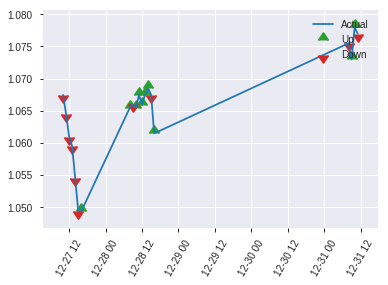


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19726475338764685
RMSE: 0.4441449688870142
LogLoss: 0.5760072690059367
Null degrees of freedom: 222
Residual degrees of freedom: 138
Null deviance: 309.15034943754756
Residual deviance: 256.8992419766477
AIC: 426.8992419766477
AUC: 0.7781531531531531
pr_auc: 0.7554506753030471
Gini: 0.5563063063063063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30491963556181484: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   49   0.4414   (49.0/111.0)
1      12   100  0.1071   (12.0/112.0)
Total  74   149  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.30492      0.766284  148
max f2                       0.222971     0.856     176
max f0point5                 0.374484     0.729167  127
max accuracy                 0.374484     0.73991   127
max precision                0.93014      1         0
max recall                   0.0721504    1         209
max specificity              0.93014      1         0
max absolute_mcc             0.359        0.487308  131
max min_per_class_accuracy   0.422691     0.702703  111
max mean_per_class_accuracy  0.374484     0.739583  127

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 43.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.895535           1.99107   1.99107            1                0.917875   1                           0.917875            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.888938           1.99107   1.99107            1                0.893318   1                           0.908052            0.0178571       0.0446429                  99.1071    99.1071
    3        0.0313901                   0.879512           0.995536  1.70663            0.5              0.88391    0.857143                    0.901155            0.00892857      0.0535714                  -0.446429  70.6633
    4        0.0403587                   0.837131           1.99107   1.76984            1                0.863792   0.888889                    0.892852            0.0178571       0.0714286                  99.1071    76.9841
    5        0.0538117                   0.803287           1.99107   1.82515            1                0.819521   0.916667                    0.874519            0.0267857       0.0982143                  99.1071    82.5149
    6        0.103139                    0.753887           1.81006   1.81793            0.909091         0.770143   0.913043                    0.8246              0.0892857       0.1875                     81.0065    81.7935
    7        0.152466                    0.709726           1.08604   1.58114            0.545455         0.727832   0.794118                    0.793293            0.0535714       0.241071                   8.6039     58.1145
    8        0.201794                    0.655736           1.44805   1.54861            0.727273         0.682514   0.777778                    0.766214            0.0714286       0.3125                     44.8052    54.8611
    9        0.300448                    0.580692           1.44805   1.51559            0.727273         0.610963   0.761194                    0.715236            0.142857        0.455357                   44.8052    51.5592
    10       0.399103                    0.505116           1.17654   1.43178            0.590909         0.542259   0.719101                    0.672478            0.116071        0.571429                   17.6542    43.1782
    11       0.502242                    0.422691           1.29852   1.40442            0.652174         0.471348   0.705357                    0.631174            0.133929        0.705357                   29.8525    40.4416
    12       0.600897                    0.346261           1.26705   1.38186            0.636364         0.389091   0.69403                     0.591429            0.125           0.830357                   26.7045    38.1863
    13       0.699552                    0.273358           0.814529  1.30185            0.409091         0.314323   0.653846                    0.55235             0.0803571       0.910714                   -18.5471   30.1854
    14       0.798206                    0.214467           0.452516  1.19688            0.227273         0.243546   0.601124                    0.514183            0.0446429       0.955357                   -54.7484   19.688
    15       0.896861                    0.103299           0.181006  1.08513            0.0909091        0.164462   0.545                       0.475714            0.0178571       0.973214                   -81.8994   8.51339
    16       1                           0.00211094         0.259705  1                  0.130435         0.0595647  0.502242   

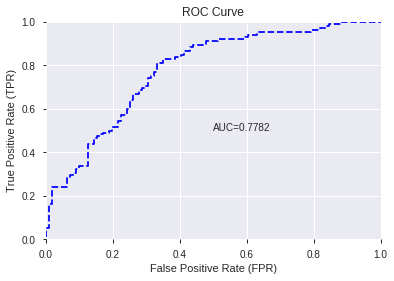

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


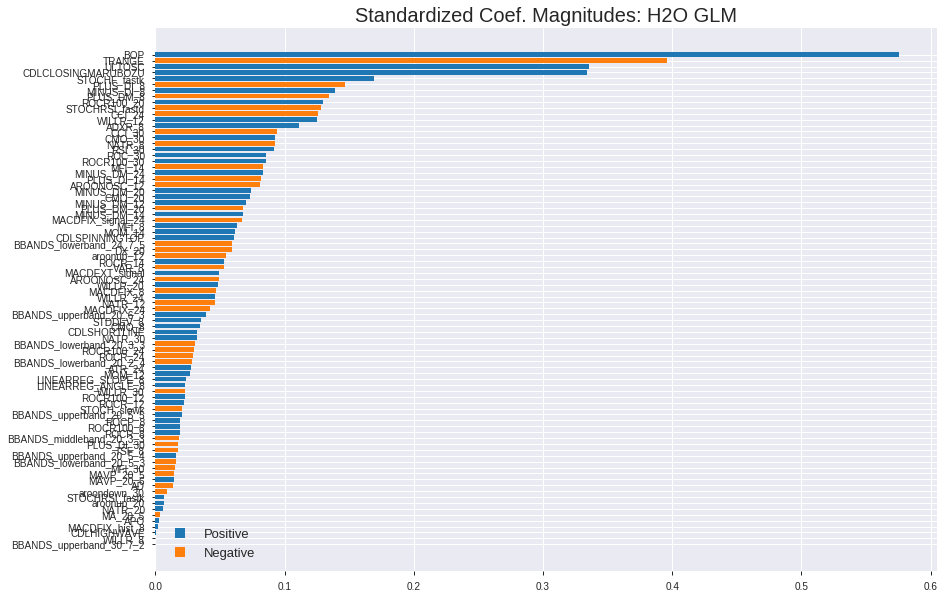

'log_likelihood'
--2019-08-27 14:54:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_145405_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_145405_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'MINUS_DI_8',
 'PLUS_DM_8',
 'ROCR100_20',
 'STOCHRSI_fastd',
 'CCI_24',
 'WILLR_12',
 'ADXR_8',
 'CCI_30',
 'CMO_30',
 'NATR_8',
 'RSI_30',
 'ROC_30',
 'ROCR100_30',
 'MFI_14',
 'MINUS_DM_24',
 'PLUS_DI_14',
 'AROONOSC_12',
 'MINUS_DM_20',
 'CMO_20',
 'MINUS_DM_12',
 'PLUS_DM_20',
 'MINUS_DM_14',
 'MACDFIX_signal_24',
 'MFI_8',
 'MOM_14',
 'CDLSPINNINGTOP',
 'BBANDS_lowerband_24_7_5',
 'DX_20',
 'aroonup_12',
 'ROCR_14',
 'VAR_8',
 'MACDEXT_signal',
 'AROONOSC_24',
 'WILLR_20',
 'MACDFIX_8',
 'WILLR_24',
 'NATR_12',
 'MACDFIX_24',
 'BBANDS_upperband_20_6_3',
 'STDDEV_8',
 'CMO_8',
 'CDLSHORTLINE',
 'NATR_30',
 'BBANDS_lowerband_20_3_3',
 'ROCR100_24',
 'ROCR_24',
 'BBANDS_lowerband_20_2_4',
 'ATR_24',
 'MOM_12',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'WILLR_30',
 'ROCR100_12',
 'ROCR_12',
 'STOCH_slowk',
 'BBANDS_upperband_20_5_5',
 'ROCP_8',
 'ROCR100_8',
 'ROCR_8',
 'BBANDS_middleband_20_3_3',

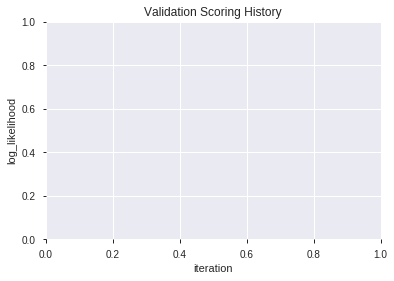

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_145418  0.812098  0.531807              0.251729  0.422751  0.178718
1               XGBoost_2_AutoML_20190827_145418  0.807513  0.546988              0.247466  0.429866  0.184785
2  XGBoost_grid_1_AutoML_20190827_145418_model_4  0.805985  0.553754              0.260899  0.432429  0.186995
3               XGBoost_3_AutoML_20190827_145418  0.798263  0.553159              0.247346  0.433021  0.187507
4  XGBoost_grid_1_AutoML_20190827_145418_model_7  0.795206  0.549831              0.251689  0.431703  0.186367
5  XGBoost_grid_1_AutoML_20190827_145418_model_6  0.795125  0.555174              0.260779  0.432858  0.187366
6  XGBoost_grid_1_AutoML_20190827_145418_model_2  0.785473  0.562039              0.269747  0.437167  0.191115
7  XGBoost_grid_1_AutoML_20190827_145418_model_3  0.782255  0.566435              0.278716  0.438836  0.192577
8  XGBoost_grid_1_AutoML_20190827_145418_model_5  0.781451  0.574138              0.310529  0.442293  0.195623
9  XGBoost_grid_1_AutoML_20190827_145418_model_1  0.781129  0.567471              0.278756  0.441747  0.195141

variable  relative_importance  scaled_importance  percentage
0                  BOP          1838.670044           1.000000    0.189327
1               TRANGE           780.765686           0.424636    0.080395
2         STOCHF_fastk           499.547729           0.271690    0.051438
3               ULTOSC           414.912415           0.225659    0.042723
4   CDLCLOSINGMARUBOZU           273.407684           0.148699    0.028153
..                 ...                  ...                ...         ...
79         CDLHIGHWAVE            12.809691           0.006967    0.001319
80              MOM_14            12.402308           0.006745    0.001277
81              RSI_30            11.621510           0.006321    0.001197
82          ROCR100_24             9.208706           0.005008    0.000948
83      CDLSPINNINGTOP             5.890076           0.003203    0.000606

[84 rows x 4 columns]

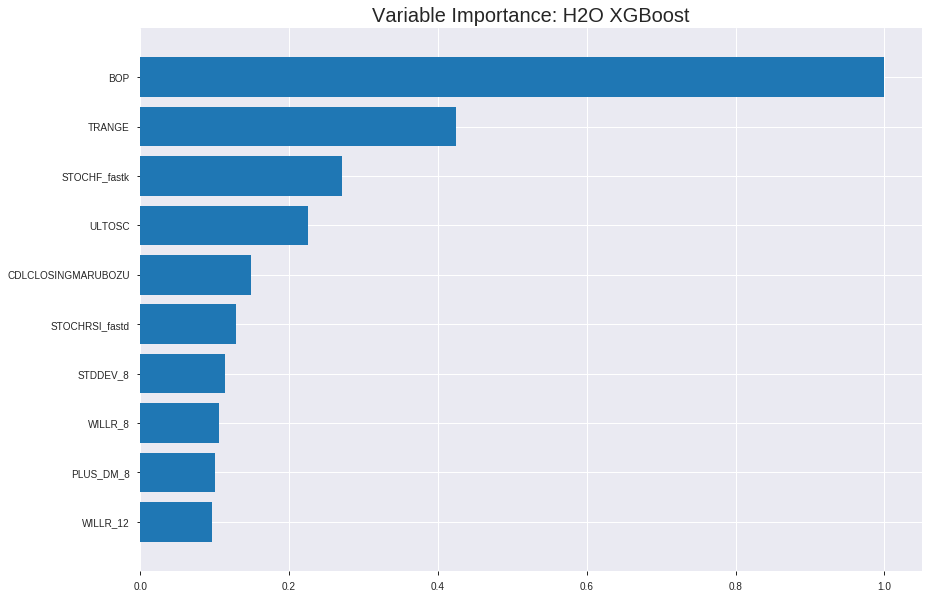

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_145418


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09983551602071492
RMSE: 0.31596758697802363
LogLoss: 0.3501093916161053
Mean Per-Class Error: 0.09342650317331547
AUC: 0.9654595234987269
pr_auc: 0.9656664123710955
Gini: 0.9309190469974538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5362417797247568: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      721  48   0.0624   (48.0/769.0)
1      98   689  0.1245   (98.0/787.0)
Total  819  737  0.0938   (146.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536242     0.904199  185
max f2                       0.410673     0.925425  235
max f0point5                 0.568934     0.927633  173
max accuracy                 0.539353     0.90617   184
max precision                0.958894     1         0
max recall                   0.185431     1         334
max specificity              0.958894     1         0
max absolute_mcc             0.539353     0.81458   184
max min_per_class_accuracy   0.501515     0.898348  200
max mean_per_class_accuracy  0.539353     0.906573  184

Gains/Lift Table: Avg response rate: 50.58 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.947732           1.97713    1.97713            1                0.951291  1                           0.951291            0.0203304       0.0203304                  97.7128   97.7128
    2        0.0205656                   0.937353           1.97713    1.97713            1                0.942478  1                           0.946884            0.0203304       0.0406607                  97.7128   97.7128
    3        0.0302057                   0.929385           1.97713    1.97713            1                0.934161  1                           0.942824            0.0190597       0.0597205                  97.7128   97.7128
    4        0.0404884                   0.918085           1.97713    1.97713            1                0.924537  1                           0.938179            0.0203304       0.0800508                  97.7128   97.7128
    5        0.0501285                   0.909345           1.97713    1.97713            1                0.913877  1                           0.933506            0.0190597       0.0991105                  97.7128   97.7128
    6        0.100257                    0.869422           1.97713    1.97713            1                0.88766   1                           0.910583            0.0991105       0.198221                   97.7128   97.7128
    7        0.150386                    0.835209           1.97713    1.97713            1                0.851393  1                           0.890853            0.0991105       0.297332                   97.7128   97.7128
    8        0.200514                    0.798615           1.95178    1.97079            0.987179         0.818849  0.996795                    0.872852            0.0978399       0.395172                   95.1781   97.0791
    9        0.300129                    0.721703           1.88784    1.94326            0.954839         0.761343  0.982869                    0.835842            0.188056        0.583227                   88.7839   94.3259
    10       0.400386                    0.628111           1.86306    1.92318            0.942308         0.677668  0.972713                    0.796235            0.186785        0.770013                   86.3063   92.3178
    11       0.5                         0.50378            1.25006    1.78907            0.632258         0.565526  0.904884                    0.750271            0.124524        0.894536                   25.0055   78.9072
    12       0.600257                    0.385555           0.621021   1.59398            0.314103         0.450532  0.80621                     0.700207            0.0622618       0.956798                   -37.8979  59.398
    13       0.699871                    0.291378           0.331647   1.41431            0.167742         0.334812  0.715335                    0.6482              0.0330368       0.989835                   -66.8353  41.4309
    14       0.800129                    0.204361           0.0887173  1.24821            0.0448718        0.250611  0.631325                    0.598381            0.00889454      0.998729                   -91.1283  24.8211
    15       0.899743                    0.13571            0.0127557  1.11143            0.00645161       0.170523  0.562143                    0.551011            0.00127065      1                          -98.7244  11.1429
    16       1                           0.0538524          0          1                  0                0.101837  0.505784                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18971748636944605
RMSE: 0.43556570844069675
LogLoss: 0.5582011916081749
Mean Per-Class Error: 0.27198723387064194
AUC: 0.7888538762978224
pr_auc: 0.7707633222808239
Gini: 0.5777077525956449
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3195257782936096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  97   0.4369   (97.0/222.0)
1      26   197  0.1166   (26.0/223.0)
Total  151  294  0.2764   (123.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319526     0.762089  265
max f2                       0.191859     0.865231  328
max f0point5                 0.502135     0.726202  180
max accuracy                 0.426339     0.72809   216
max precision                0.954527     1         0
max recall                   0.0696829    1         397
max specificity              0.954527     1         0
max absolute_mcc             0.319526     0.471477  265
max min_per_class_accuracy   0.455362     0.716216  202
max mean_per_class_accuracy  0.426339     0.728013  216

Gains/Lift Table: Avg response rate: 50.11 %, avg score: 46.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.938659           1.99552   1.99552            1                0.946548  1                           0.946548            0.0224215       0.0224215                  99.5516   99.5516
    2        0.0202247                   0.925293           1.99552   1.99552            1                0.931059  1                           0.939664            0.0179372       0.0403587                  99.5516   99.5516
    3        0.0314607                   0.914961           1.59641   1.85298            0.8              0.921481  0.928571                    0.93317             0.0179372       0.058296                   59.6413   85.2979
    4        0.0404494                   0.90621            1.99552   1.88465            1                0.910208  0.944444                    0.928067            0.0179372       0.0762332                  99.5516   88.4654
    5        0.0516854                   0.891332           1.59641   1.82199            0.8              0.896647  0.913043                    0.921237            0.0179372       0.0941704                  59.6413   82.1993
    6        0.101124                    0.816749           1.7234    1.77379            0.863636         0.853719  0.888889                    0.888228            0.0852018       0.179372                   72.34     77.3792
    7        0.150562                    0.777179           1.54199   1.69768            0.772727         0.794742  0.850746                    0.857531            0.0762332       0.255605                   54.1989   69.7678
    8        0.2                         0.724869           1.63269   1.68161            0.818182         0.749501  0.842697                    0.830827            0.0807175       0.336323                   63.2695   68.1614
    9        0.301124                    0.624563           1.19731   1.51897            0.6              0.672973  0.761194                    0.777817            0.121076        0.457399                   19.7309   51.8975
    10       0.4                         0.539002           1.40593   1.49103            0.704545         0.58274   0.747191                    0.729595            0.139013        0.596413                   40.5932   49.1031
    11       0.501124                    0.455359           1.19731   1.43176            0.6              0.496741  0.717489                    0.682607            0.121076        0.717489                   19.7309   43.176
    12       0.6                         0.367144           0.770995  1.32287            0.386364         0.413047  0.662921                    0.638185            0.0762332       0.793722                   -22.9005  32.287
    13       0.698876                    0.280502           1.04311   1.28329            0.522727         0.326432  0.643087                    0.594078            0.103139        0.896861                   4.31105   28.329
    14       0.8                         0.19767            0.576482  1.19395            0.288889         0.234953  0.598315                    0.548683            0.058296        0.955157                   -42.3518  19.3946
    15       0.898876                    0.151319           0.317468  1.09753            0.159091         0.174865  0.55                        0.507563            0.0313901       0.986547                   -68.2532  9.75336
    16       1                           0.0591304          0.133034  1                  0.0666667        0.110709  0.501124                    0.467432            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:54:19  0.008 sec   0                  0.5              0.693147            0.5             0                  1                0.494216                         0.5                0.693147              0.5               0                    1                  0.498876
    2019-08-27 14:54:19  0.179 sec   5                  0.466116         0.627195            0.871034        0.879473           1.97713          0.215296                         0.477899           0.649549              0.757898          0.728646             1.82922            0.303371
    2019-08-27 14:54:19  0.270 sec   10                 0.44083          0.579468            0.893347        0.883998           1.97713          0.192802                         0.462284           0.618897              0.779178          0.755686             1.99552            0.292135
    2019-08-27 14:54:19  0.360 sec   15                 0.420399         0.541217            0.903845        0.909013           1.97713          0.179949                         0.453969           0.601867              0.77627           0.762071             1.99552            0.283146
    2019-08-27 14:54:19  0.454 sec   20                 0.404525         0.511284            0.911153        0.917049           1.97713          0.172879                         0.447965           0.589076              0.777825          0.768394             1.99552            0.280899
    2019-08-27 14:54:19  0.543 sec   25                 0.390758         0.485394            0.920623        0.925371           1.97713          0.169023                         0.444775           0.58165               0.77835           0.767933             1.99552            0.278652
    2019-08-27 14:54:19  0.633 sec   30                 0.378304         0.462117            0.92778         0.931787           1.97713          0.161954                         0.44075            0.572615              0.782471          0.769674             1.99552            0.280899
    2019-08-27 14:54:19  0.722 sec   35                 0.368012         0.443111            0.935019        0.937239           1.97713          0.145244                         0.440588           0.571158              0.780542          0.766342             1.99552            0.296629
    2019-08-27 14:54:19  0.809 sec   40                 0.358965         0.426565            0.941322        0.944087           1.97713          0.133676                         0.440177           0.569634              0.780279          0.765239             1.99552            0.292135
    2019-08-27 14:54:19  0.899 sec   45                 0.350802         0.411036            0.943805        0.946099           1.97713          0.128535                         0.437935           0.564248              0.785016          0.76969              1.99552            0.28764
    2019-08-27 14:54:20  0.989 sec   50                 0.342807         0.396362            0.948548        0.950324           1.97713          0.12018                          0.436662           0.560961              0.788258          0.773371             1.99552            0.28764
    2019-08-27 14:54:20  1.080 sec   55                 0.335544         0.383748            0.953882        0.954375           1.97713          0.116324                         0.435571           0.558263              0.789409          0.7

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1838.6700439453125     1.0                    0.18932663721305593
TRANGE              780.7656860351562      0.42463610510553274    0.08039492581888029
STOCHF_fastk        499.5477294921875      0.27168970916624424    0.051438099001838204
ULTOSC              414.91241455078125     0.22565898428436135    0.04272325665147197
CDLCLOSINGMARUBOZU  273.4076843261719      0.1486986124707342     0.02815260825733149
---                 ---                    ---                    ---
CDLHIGHWAVE         12.809691429138184     0.00696682445625311    0.0013190054463560782
MOM_14              12.402307510375977     0.006745260005304605   0.0012770573939320405
RSI_30              11.621509552001953     0.006320606348197845   0.0011966591450517916
ROCR100_24          9.20870590209961       0.00500835151604477    0.0009482143505136668
CDLSPINNINGTOP      5.89007568359375       0.0032034435449631647  0.0006064971938697469


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7795275590551181)

('auc', 0.8120978120978121)

('logloss', 0.531806974488203)

('mean_per_class_error', 0.24710424710424705)

('rmse', 0.4227506855258906)

('mse', 0.17871814211261045)

xgboost prediction progress: |████████████████████████████████████████████| 100%


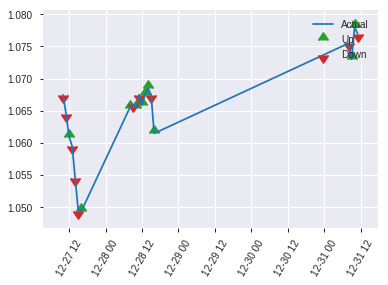


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17871814211261045
RMSE: 0.4227506855258906
LogLoss: 0.531806974488203
Mean Per-Class Error: 0.24710424710424705
AUC: 0.8120978120978121
pr_auc: 0.7894168555486271
Gini: 0.6241956241956241
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3717862665653229: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   43   0.3874   (43.0/111.0)
1      13   99   0.1161   (13.0/112.0)
Total  81   142  0.2511   (56.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371786     0.779528  141
max f2                       0.251392     0.868506  167
max f0point5                 0.505294     0.740385  101
max accuracy                 0.391189     0.753363  134
max precision                0.947327     1         0
max recall                   0.124943     1         210
max specificity              0.947327     1         0
max absolute_mcc             0.391189     0.517409  134
max min_per_class_accuracy   0.454767     0.720721  111
max mean_per_class_accuracy  0.391189     0.752896  134

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 47.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0134529                   0.938431           1.99107    1.99107            1                0.944259  1                           0.944259            0.0267857       0.0267857                  99.1071    99.1071
    2        0.0224215                   0.931036           1.99107    1.99107            1                0.934053  1                           0.940176            0.0178571       0.0446429                  99.1071    99.1071
    3        0.0313901                   0.915644           1.99107    1.99107            1                0.923709  1                           0.935471            0.0178571       0.0625                     99.1071    99.1071
    4        0.0403587                   0.904732           0.995536   1.76984            0.5              0.912936  0.888889                    0.930464            0.00892857      0.0714286                  -0.446429  76.9841
    5        0.0538117                   0.888735           1.99107    1.82515            1                0.896632  0.916667                    0.922006            0.0267857       0.0982143                  99.1071    82.5149
    6        0.103139                    0.827188           1.81006    1.81793            0.909091         0.855229  0.913043                    0.890069            0.0892857       0.1875                     81.0065    81.7935
    7        0.152466                    0.767832           1.81006    1.81539            0.909091         0.799375  0.911765                    0.860727            0.0892857       0.276786                   81.0065    81.5389
    8        0.201794                    0.702789           1.26705    1.68135            0.636364         0.722074  0.844444                    0.826834            0.0625          0.339286                   26.7045    68.1349
    9        0.300448                    0.629514           1.26705    1.54531            0.636364         0.667331  0.776119                    0.77446             0.125           0.464286                   26.7045    54.5309
    10       0.399103                    0.548453           1.26705    1.47652            0.636364         0.582295  0.741573                    0.726958            0.125           0.589286                   26.7045    47.6525
    11       0.502242                    0.454767           1.29852    1.43997            0.652174         0.502931  0.723214                    0.680953            0.133929        0.723214                   29.8525    43.9971
    12       0.600897                    0.392149           1.26705    1.41158            0.636364         0.425755  0.708955                    0.639055            0.125           0.848214                   26.7045    41.158
    13       0.699552                    0.29603            0.724026   1.31462            0.363636         0.344736  0.660256                    0.597548            0.0714286       0.919643                   -27.5974   31.4618
    14       0.798206                    0.2257             0.452516   1.20807            0.227273         0.253987  0.606742                    0.555086            0.0446429       0.964286                   -54.7484   20.8066
    15       0.896861                    0.162373           0.27151    1.10504            0.136364         0.191522  0.555                       0.515094            0.0267857       0.991071                   -72.849    10.5045
    16       1                           0.0754712          0.0865683  1                  0.0434783        0.121225  0.502242   

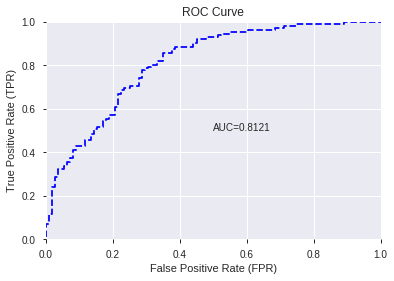

This function is available for GLM models only


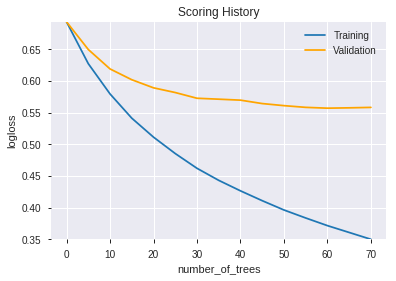

--2019-08-27 14:54:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.83.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.83.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_145418',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_145418',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b10b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_b10b',
   'ty

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'STDDEV_8',
 'WILLR_8',
 'PLUS_DM_8',
 'WILLR_12',
 'DX_20',
 'PLUS_DM_20',
 'AD',
 'NATR_8',
 'MFI_30',
 'MFI_8',
 'STOCHRSI_fastk',
 'BBANDS_lowerband_24_7_5',
 'PLUS_DI_8',
 'CCI_24',
 'MACDEXT_signal',
 'LINEARREG_ANGLE_8',
 'ROCR100_20',
 'ADXR_8',
 'MINUS_DI_8',
 'NATR_30',
 'WILLR_20',
 'STOCH_slowk',
 'ROC_30',
 'MACDFIX_signal_24',
 'MACDFIX_hist_8',
 'AROONOSC_12',
 'MA_20_5',
 'aroonup_12',
 'PLUS_DI_30',
 'MINUS_DM_12',
 'MFI_14',
 'MINUS_DM_20',
 'ROCP_8',
 'PLUS_DI_14',
 'WILLR_30',
 'ROCR_14',
 'CMO_30',
 'CDLSHORTLINE',
 'NATR_12',
 'ATR_24',
 'BBANDS_upperband_20_6_3',
 'MOM_12',
 'MINUS_DM_14',
 'CCI_30',
 'ROCR_24',
 'VAR_8',
 'AROONOSC_24',
 'MINUS_DM_24',
 'BBANDS_lowerband_20_5_3',
 'WILLR_24',
 'BBANDS_lowerband_20_3_3',
 'APO',
 'BBANDS_upperband_20_5_5',
 'aroondown_30',
 'TSF_8',
 'BBANDS_lowerband_20_2_4',
 'BBANDS_upperband_20_5_4',
 'CMO_20',
 'MAVP_20_5',
 'ROCR100_30

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.758
GLM             0.740
XGBoost         0.758
dtype: float64

DeepLearning    GLM  XGBoost
All          0.722  0.731    0.753
DLF          0.758  0.735    0.758
Fwe          0.749  0.731    0.744
RFE          0.740  0.740    0.753
XGBF         0.749  0.735    0.758





F1


DeepLearning    0.776
GLM             0.777
XGBoost         0.784
dtype: float64

DeepLearning    GLM  XGBoost
All          0.759  0.759    0.784
DLF          0.775  0.777    0.774
Fwe          0.772  0.774    0.763
RFE          0.756  0.766    0.780
XGBF         0.776  0.777    0.774





auc


DeepLearning    0.791
GLM             0.787
XGBoost         0.812
dtype: float64

DeepLearning    GLM  XGBoost
All          0.781  0.765    0.810
DLF          0.791  0.783    0.805
Fwe          0.789  0.787    0.798
RFE          0.781  0.778    0.812
XGBF         0.788  0.783    0.805





logloss


DeepLearning    0.582
GLM             0.590
XGBoost         0.557
dtype: float64

DeepLearning    GLM  XGBoost
All          0.568  0.590    0.543
DLF          0.578  0.571    0.550
Fwe          0.573  0.562    0.557
RFE          0.573  0.576    0.532
XGBF         0.582  0.571    0.550





mean_per_class_error


DeepLearning    0.279
GLM             0.270
XGBoost         0.256
dtype: float64

DeepLearning    GLM  XGBoost
All          0.279  0.270    0.247
DLF          0.242  0.265    0.242
Fwe          0.252  0.270    0.256
RFE          0.260  0.260    0.247
XGBF         0.252  0.265    0.242





rmse


DeepLearning    0.445
GLM             0.451
XGBoost         0.435
dtype: float64

DeepLearning    GLM  XGBoost
All          0.439  0.451    0.427
DLF          0.440  0.440    0.431
Fwe          0.445  0.437    0.435
RFE          0.443  0.444    0.423
XGBF         0.443  0.440    0.431





mse


DeepLearning    0.198
GLM             0.204
XGBoost         0.189
dtype: float64

DeepLearning    GLM  XGBoost
All          0.193  0.204    0.182
DLF          0.194  0.194    0.186
Fwe          0.198  0.191    0.189
RFE          0.196  0.197    0.179
XGBF         0.196  0.194    0.186

{'F1':       DeepLearning    GLM  XGBoost
 All          0.759    NaN      NaN
 DLF          0.775    NaN      NaN
 DLF            NaN  0.777      NaN
 DLF            NaN    NaN    0.774
 All            NaN  0.759      NaN
 All            NaN    NaN    0.784
 XGBF         0.776    NaN      NaN
 XGBF           NaN  0.777      NaN
 XGBF           NaN    NaN    0.774
 Fwe          0.772    NaN      NaN
 Fwe            NaN  0.774      NaN
 Fwe            NaN    NaN    0.763
 RFE          0.756    NaN      NaN
 RFE            NaN  0.766      NaN
 RFE            NaN    NaN    0.780,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.722    NaN      NaN
 DLF          0.758    NaN      NaN
 DLF            NaN  0.735      NaN
 DLF            NaN    NaN    0.758
 All            NaN  0.731      NaN
 All            NaN    NaN    0.753
 XGBF         0.749    NaN      NaN
 XGBF           NaN  0.735      NaN
 XGBF           NaN    NaN    0.758
 Fwe          0.749    NaN      NaN
 Fwe     